# Progetto di Machine Learning 2023
Il presente notebook Python descrive si focalizza sull'applicazione di tecniche di **machine learning** per affrontare un **problema di regressione** sui **prezzi delle case**. Prima di procedere con l'implementazione dei modelli di regressione, sono state eseguite diverse fasi di **preprocessing** e **analisi dei dati** al fine di ottenere un dataset coerente e di qualità.

Successivamente, sono stati implementati vari **modelli di regressione** al fine di predire i prezzi delle case. L'obiettivo principale è identificare il modello più accurato e performante per questo specifico problema. A tal fine, sono stati adottati approcci di **feature selection** per selezionare le caratteristiche più rilevanti e ridurre la dimensionalità del dataset. Inoltre, è stata utilizzata la tecnica della **Principal Component Analysis (PCA)** per ridurre ulteriormente la complessità dei dati, mantenendo al contempo la maggior parte delle informazioni rilevanti. Infine, vengono analizzati i risultati dei diversi modelli.


Inizialmente, sono state importate delle librerie necessarie per lo svolgimento del progetto; tra i più importanti:
- **sklearn**: fornisce un ampio set di strumenti e algoritmi per la creazione, la valutazione e la messa in produzione di modelli di machine learning;
- **pandas**: utilizzata per la manipolazione e l'analisi dei dati;
- **seaborn**: utilizzata per la visualizzazione dei dati in grafici.

In [1]:
from pprint import pprint
from typing import List, Tuple, Dict, Any

import numpy as np
import pandas as pd
import seaborn as sns
import sm as sm
from sklearn.model_selection import train_test_split
from pandas import DataFrame, Series
from matplotlib import pyplot as plt

initial_training_set = pd.read_csv('../dataset/train.csv')
print(initial_training_set.shape)
print(initial_training_set.columns)

(1460, 81)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

Osserviamo che il dataset originale ha un **numero di colonne** (features) pari a **81** e un **numero di righe** pari **1460**.
Analizzando il dataset e il file [data_description](../dataset/data_description.txt) notiamo che alcune colonne, anche se corrispondono ad un valore numerico, in realtà corrispondono ad una descrizione di quella specifica colonna; quindi, è stato necessario cambiare il tipo di queste colonne da **int** a **object**:

In [2]:
columns_to_convert = ['MSSubClass', 'YrSold', 'GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'OverallCond', 'OverallQual']
initial_training_set[columns_to_convert] = initial_training_set[columns_to_convert].astype('object')

Consideriamo solo le colonne numeriche:

In [3]:
numerical_cols = initial_training_set.select_dtypes(include='number').columns.to_list()
numerical_train = initial_training_set[numerical_cols]
print(numerical_cols)
print("Numero di colonne numeriche: ", numerical_train.columns.shape[0])

['Id', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SalePrice']
Numero di colonne numeriche:  31


Consideriamo solo le colonne categoriche:

In [4]:
categorical_cols = initial_training_set.select_dtypes(include='object').columns.to_list()
categorical_train = initial_training_set[categorical_cols]
print(categorical_cols)
print("Numero di colonne categoriche: ", categorical_train.columns.shape[0])

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'YrSold', 'SaleType', 'SaleCondition']
Numero di colonne categoriche:  50


Osserviamo che **31 colonne** sono **numeriche** e **50 colonne** sono **categoriche**.

# 1. Data Exploration
La fase iniziale del progetto consiste nel **preprocessare** i dati raccolti, che includono informazioni sulle caratteristiche delle case e i relativi prezzi. Durante questa fase, sono state adottate diverse strategie per gestire i **dati mancanti**, **ridurre il rumore** e **standardizzare** le caratteristiche. Inoltre, sono state esplorate le **correlazioni* tra le variabili e valutata l'**importanza** di ciascuna caratteristica rispetto al target.

Sui file [valutazioneFeatures](valutazioneFeatures.ipynb) e [csv](./dataset/valutazioneFeatures.csv) si ha una visione più completa delle diverse relazioni tra tutte le features.

## 1.1 Matrice di correlazione
Una matrice di correlazione è un'importante strumento statistico utilizzato per analizzare le relazioni tra le variabili e identificare eventuali pattern o dipendenze.
La matrice di correlazione è utile nel machine learning per diverse ragioni:
- **Identificazione delle relazioni**: è utile per comprendere quali variabili sono correlate tra loro e e per fornire informazioni su come una variabile può essere influenzata dalle altre;
- **Selezione delle feature**: è utile per identificare le variabili che sono altamente correlate tra loro, e di conseguenza, ridurre la ridondanza delle feature, evitando di includere nel modello variabili che offrono informazioni simili;
- **Gestione del multicollinearità**: si verifica quando due o più variabili sono altamente correlate tra loro e potrebbero causare problemi durante la modellazione, ad esempio, aumentando la complessità del modello o rendendo i coefficienti delle variabili poco interpretabili. Quindi, è utile per identificare le variabili coinvolte nella multicollinearità e adottare le opportune strategie per gestirla, ad esempio, rimuovendo una delle variabili correlate o utilizzando tecniche di riduzione della dimensionalità come l'analisi delle componenti principali (PCA).


Dato che il numero di features è elevato, risulta difficile osservare tutta la matrice di correlazione, quindi, consideriamo solo le feature che hanno un'alta correlazione con un'altra al di sopra di una certo soglia.


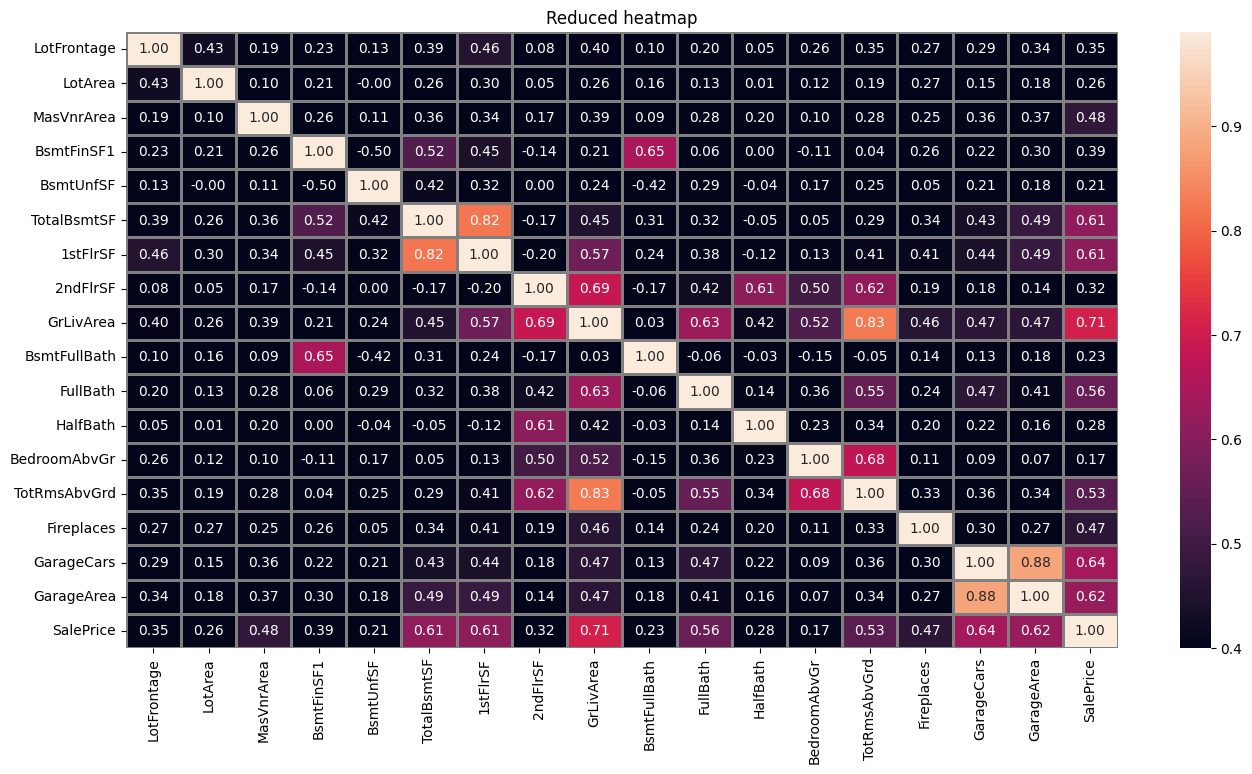

In [5]:
def correlazione_matrice(df_train: DataFrame, threshold: float, val_max: float):
    """Calcola la matrice di correlazione (ndarray) a partire da un dataframe di feature tutte numeriche"""
    corr = df_train.corr().to_numpy()
    # seleziona gli elementi che sono compresi tra il threshold e un valore massimo
    ind_x, = np.where(np.all(np.logical_or(corr < threshold, corr > val_max), axis=0))
    corr = np.delete(corr, ind_x, 1)  # si eliminano

    # stessa cosa per le righe
    ind_y, = np.where(np.all(np.logical_or(corr < threshold, corr > val_max), axis=1))
    corr = np.delete(corr, ind_y, 0)
    # si aggiornano le colonne selezionando solamente quelle filtrate

    return corr, ind_x, ind_y


def correlation_matrix_filtered_plot(df_train: DataFrame, threshold=0.6):
    # threshold: valore minimo di correlazione da considerare
    val_max = 0.99
    # si selezionano le colonne
    labels = df_train.columns
    corr, ind_x, ind_y = correlazione_matrice(df_train, threshold, val_max)
    # si aggiornano le colonne selezionando solamente quelle filtrate
    map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
    map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]
    # plot heatmap
    plt.figure(figsize=(16, 8))
    heatmap = sns.heatmap(corr, annot=True, fmt='.2f',
                          xticklabels=map_labels_x,
                          yticklabels=map_labels_y,
                          vmin=threshold,
                          vmax=val_max,
                          linewidths=1.0,
                          linecolor="grey")

    heatmap.set_title("Reduced heatmap")
    plt.show()


correlation_matrix_filtered_plot(numerical_train, 0.4)

Analizzando la matrice di correlazone, osserviamo che le feature che hanno maggiore correlazione con un'altra sono:
- **1stFlrSF** correlata con **TotalBsmtSF** con un valore pari a 0.82;
- **TotRmsAbvGrd** correlata con **GrLivArea** con un valore pari a 0.83;
- **Garage Cars** correlata con **Garage Area** con un valori pari a 0.88.


Definiamo una classe di Correlazione per stabilire quali feature hanno un'alta correlazione sia con un'altra e sia con il target **SalePrice**. Dopo un'attenta analisi, si è deciso di considerare una correlazione **>0.6**.

In [6]:
def correlazione_dataframe(df_train, threshold, val_max):
    # si selezionano le colonne
    labels = df_train.columns

    corr, ind_x, ind_y = correlazione_matrice(df_train, threshold, val_max)
    map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
    map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]

    return pd.DataFrame(corr, columns=map_labels_x, index=map_labels_y)


class Correlazione:
    def __init__(self, feature1, feature2, correlazione, correlazione_f1_target, correlazione_f2_target):
        self.feature1 = feature1
        self.feature2 = feature2
        self.correlazione = correlazione
        self.correlazione_f1_target = correlazione_f1_target
        self.correlazione_f2_target = correlazione_f2_target

    def __str__(self):
        return f"({self.feature1, self.feature2, self.correlazione, self.correlazione_f1_target, self.correlazione_f2_target})"

    def __repr__(self):
        return f"({self.feature1, self.feature2, self.correlazione, self.correlazione_f1_target, self.correlazione_f2_target})"

    def __gt__(self, other):
        return self.correlazione > other.correlazione

    def __lt__(self, other):
        return self.correlazione < other.correlazione


def feature_in_correlazione(corr: DataFrame, thresh: float) -> List[Correlazione]:
    colonne = corr.columns
    corr_list = []
    target_index = len(colonne) - 1
    # per ogni riga del dataframe della matrice di correlazione
    for (i, r) in enumerate(corr):
        # e per ogni colonna
        for (j, c) in enumerate(corr[r]):
            # se una coppia di feature diverse ha correlazione elevata, la aggiungiamo alla lista
            if c > thresh and i != j and colonne[i] != "SalePrice" and colonne[j] != "SalePrice":
                # calcoliamo la correlazione delle due feature con la colonna target
                corr_f1_target = corr.iloc[i, target_index]
                corr_f2_target = corr.iloc[j, target_index]
                corr_list.append(Correlazione(colonne[i], colonne[j], c, corr_f1_target, corr_f2_target))

    corr_list.sort()
    return corr_list


min_correlation = 0.6
# trasformo la matrice di correlazione di tutto il dataset in un dataframe
corr = correlazione_dataframe(numerical_train, min_correlation, 0.99)
# poi stampo la lista di feature in correlazione
feature_correlate = feature_in_correlazione(corr, min_correlation)
pprint(feature_correlate)

[(('2ndFlrSF', 'HalfBath', 0.6097073002717436, 0.31933380283206736, 0.28410767559478256)),
 (('HalfBath', '2ndFlrSF', 0.6097073002717436, 0.28410767559478256, 0.31933380283206736)),
 (('2ndFlrSF', 'TotRmsAbvGrd', 0.6164226354915431, 0.31933380283206736, 0.5337231555820284)),
 (('TotRmsAbvGrd', '2ndFlrSF', 0.6164226354915431, 0.5337231555820284, 0.31933380283206736)),
 (('GrLivArea', 'FullBath', 0.6300116462511148, 0.7086244776126515, 0.5606637627484453)),
 (('FullBath', 'GrLivArea', 0.6300116462511148, 0.5606637627484453, 0.7086244776126515)),
 (('BsmtFinSF1', 'BsmtFullBath', 0.6492117535742649, 0.3864198062421535, 0.22712223313149427)),
 (('BsmtFullBath', 'BsmtFinSF1', 0.6492117535742649, 0.22712223313149427, 0.3864198062421535)),
 (('BedroomAbvGr', 'TotRmsAbvGrd', 0.676619935742649, 0.16821315430073963, 0.5337231555820284)),
 (('TotRmsAbvGrd', 'BedroomAbvGr', 0.676619935742649, 0.5337231555820284, 0.16821315430073963)),
 (('2ndFlrSF', 'GrLivArea', 0.6875010641666033, 0.31933380283206

Analizziamo queste feature con un **diagramma di dispersione** (scatterplot) che rappresenta il metodo grafico più utilizzato in statistica descrittiva per valutare la possibile relazione tra due variabili quantitative.

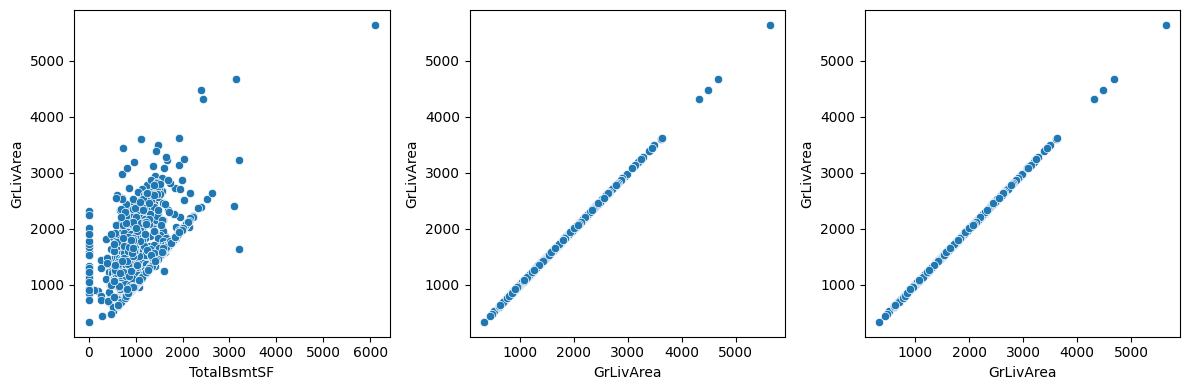

In [7]:
def scatter_plot(feature1, feature2):
    sns.scatterplot(x=feature1, y=feature2)
    plt.xlabel(feature1.name)
    plt.ylabel(feature2.name)


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
scatter_plot(numerical_train["TotalBsmtSF"], numerical_train["GrLivArea"])
plt.subplot(1, 3, 2)
scatter_plot(numerical_train["GrLivArea"], numerical_train["GrLivArea"])
plt.subplot(1, 3, 3)
scatter_plot(numerical_train["GrLivArea"], numerical_train["GrLivArea"])
plt.tight_layout()

Tra le due feature correlate, consideriamo quella che ha una correlazione maggiore con il SalePrice, mentree l'altra verrà successivamente eliminata.

In [8]:
best_features = set()
worst_features = set()
for c in feature_correlate:
    c: Correlazione = c
    if c.correlazione_f1_target > c.correlazione_f2_target:
        best_features.add((c.feature1, c.correlazione_f1_target))
        worst_features.add(c.feature2)
    else:
        best_features.add((c.feature2, c.correlazione_f2_target))
        worst_features.add(c.feature1)

best_features_list = list(best_features)
worst_features_list = list(worst_features)
best_features_list.sort(key=lambda x: x[1], reverse=True)
pprint(best_features_list)
print("feature correlate con altre: ", worst_features_list)

[('GrLivArea', 0.7086244776126515),
 ('GarageCars', 0.6404091972583519),
 ('TotalBsmtSF', 0.6135805515591943),
 ('TotRmsAbvGrd', 0.5337231555820284),
 ('BsmtFinSF1', 0.3864198062421535),
 ('2ndFlrSF', 0.31933380283206736)]
feature correlate con altre:  ['TotRmsAbvGrd', 'BsmtFullBath', 'GarageArea', 'BedroomAbvGr', 'FullBath', '1stFlrSF', '2ndFlrSF', 'HalfBath']


Analizziamo queste feature con un **diagramma di dispersione** (scatterplot) per valutare la possibile relazione tra la feature più importanti con il valore target **SalePrice**. Consideriamo prima le colonne numeriche:


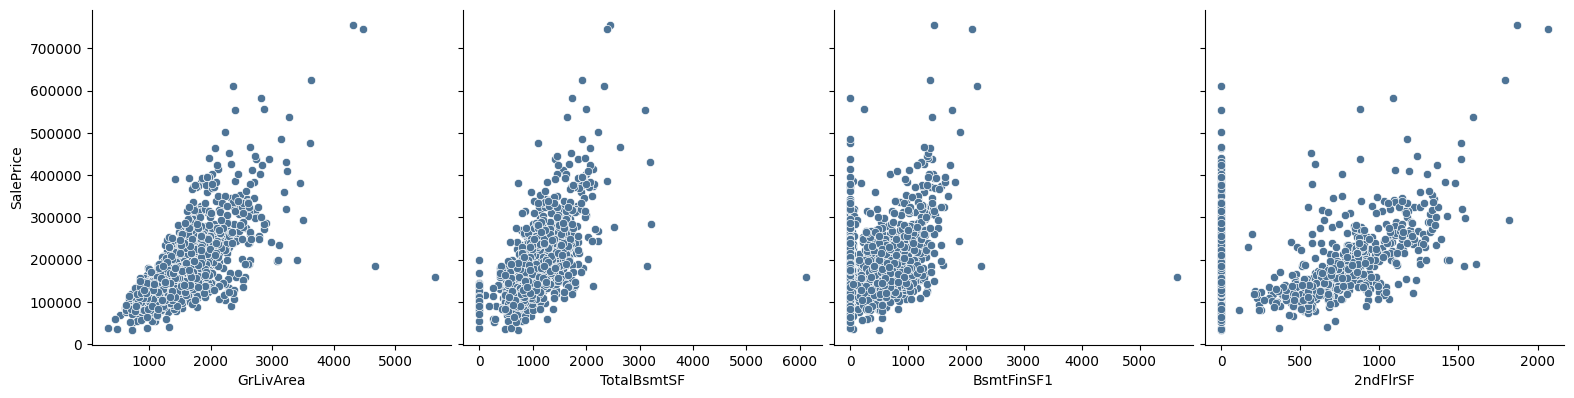

In [9]:
features_pair_plot = ['GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '2ndFlrSF']
sns.pairplot(initial_training_set, x_vars=features_pair_plot, y_vars="SalePrice", height=4, diag_kind='kde',
             plot_kws=dict(color='xkcd:cadet blue'),
             diag_kws=dict(fill=True, alpha=.7, color='xkcd:pale orange'))

Da questi grafici, notiamo un andamento lineare; infatti, all'aumentare delle feature aumenta anche il relatio target. Inoltre, in ogni caso è possibile notare che nonostante gli elementi tengono a crescere in relazione con il target ci sono degli outliers che si comportano in modo anomalo. In seguito, per risolvere questo problemaè stata utilizzata una tecnica di normalizzazione.

Visualizziamo le colonne categoriche rispetto al valore target **SalePrice**:

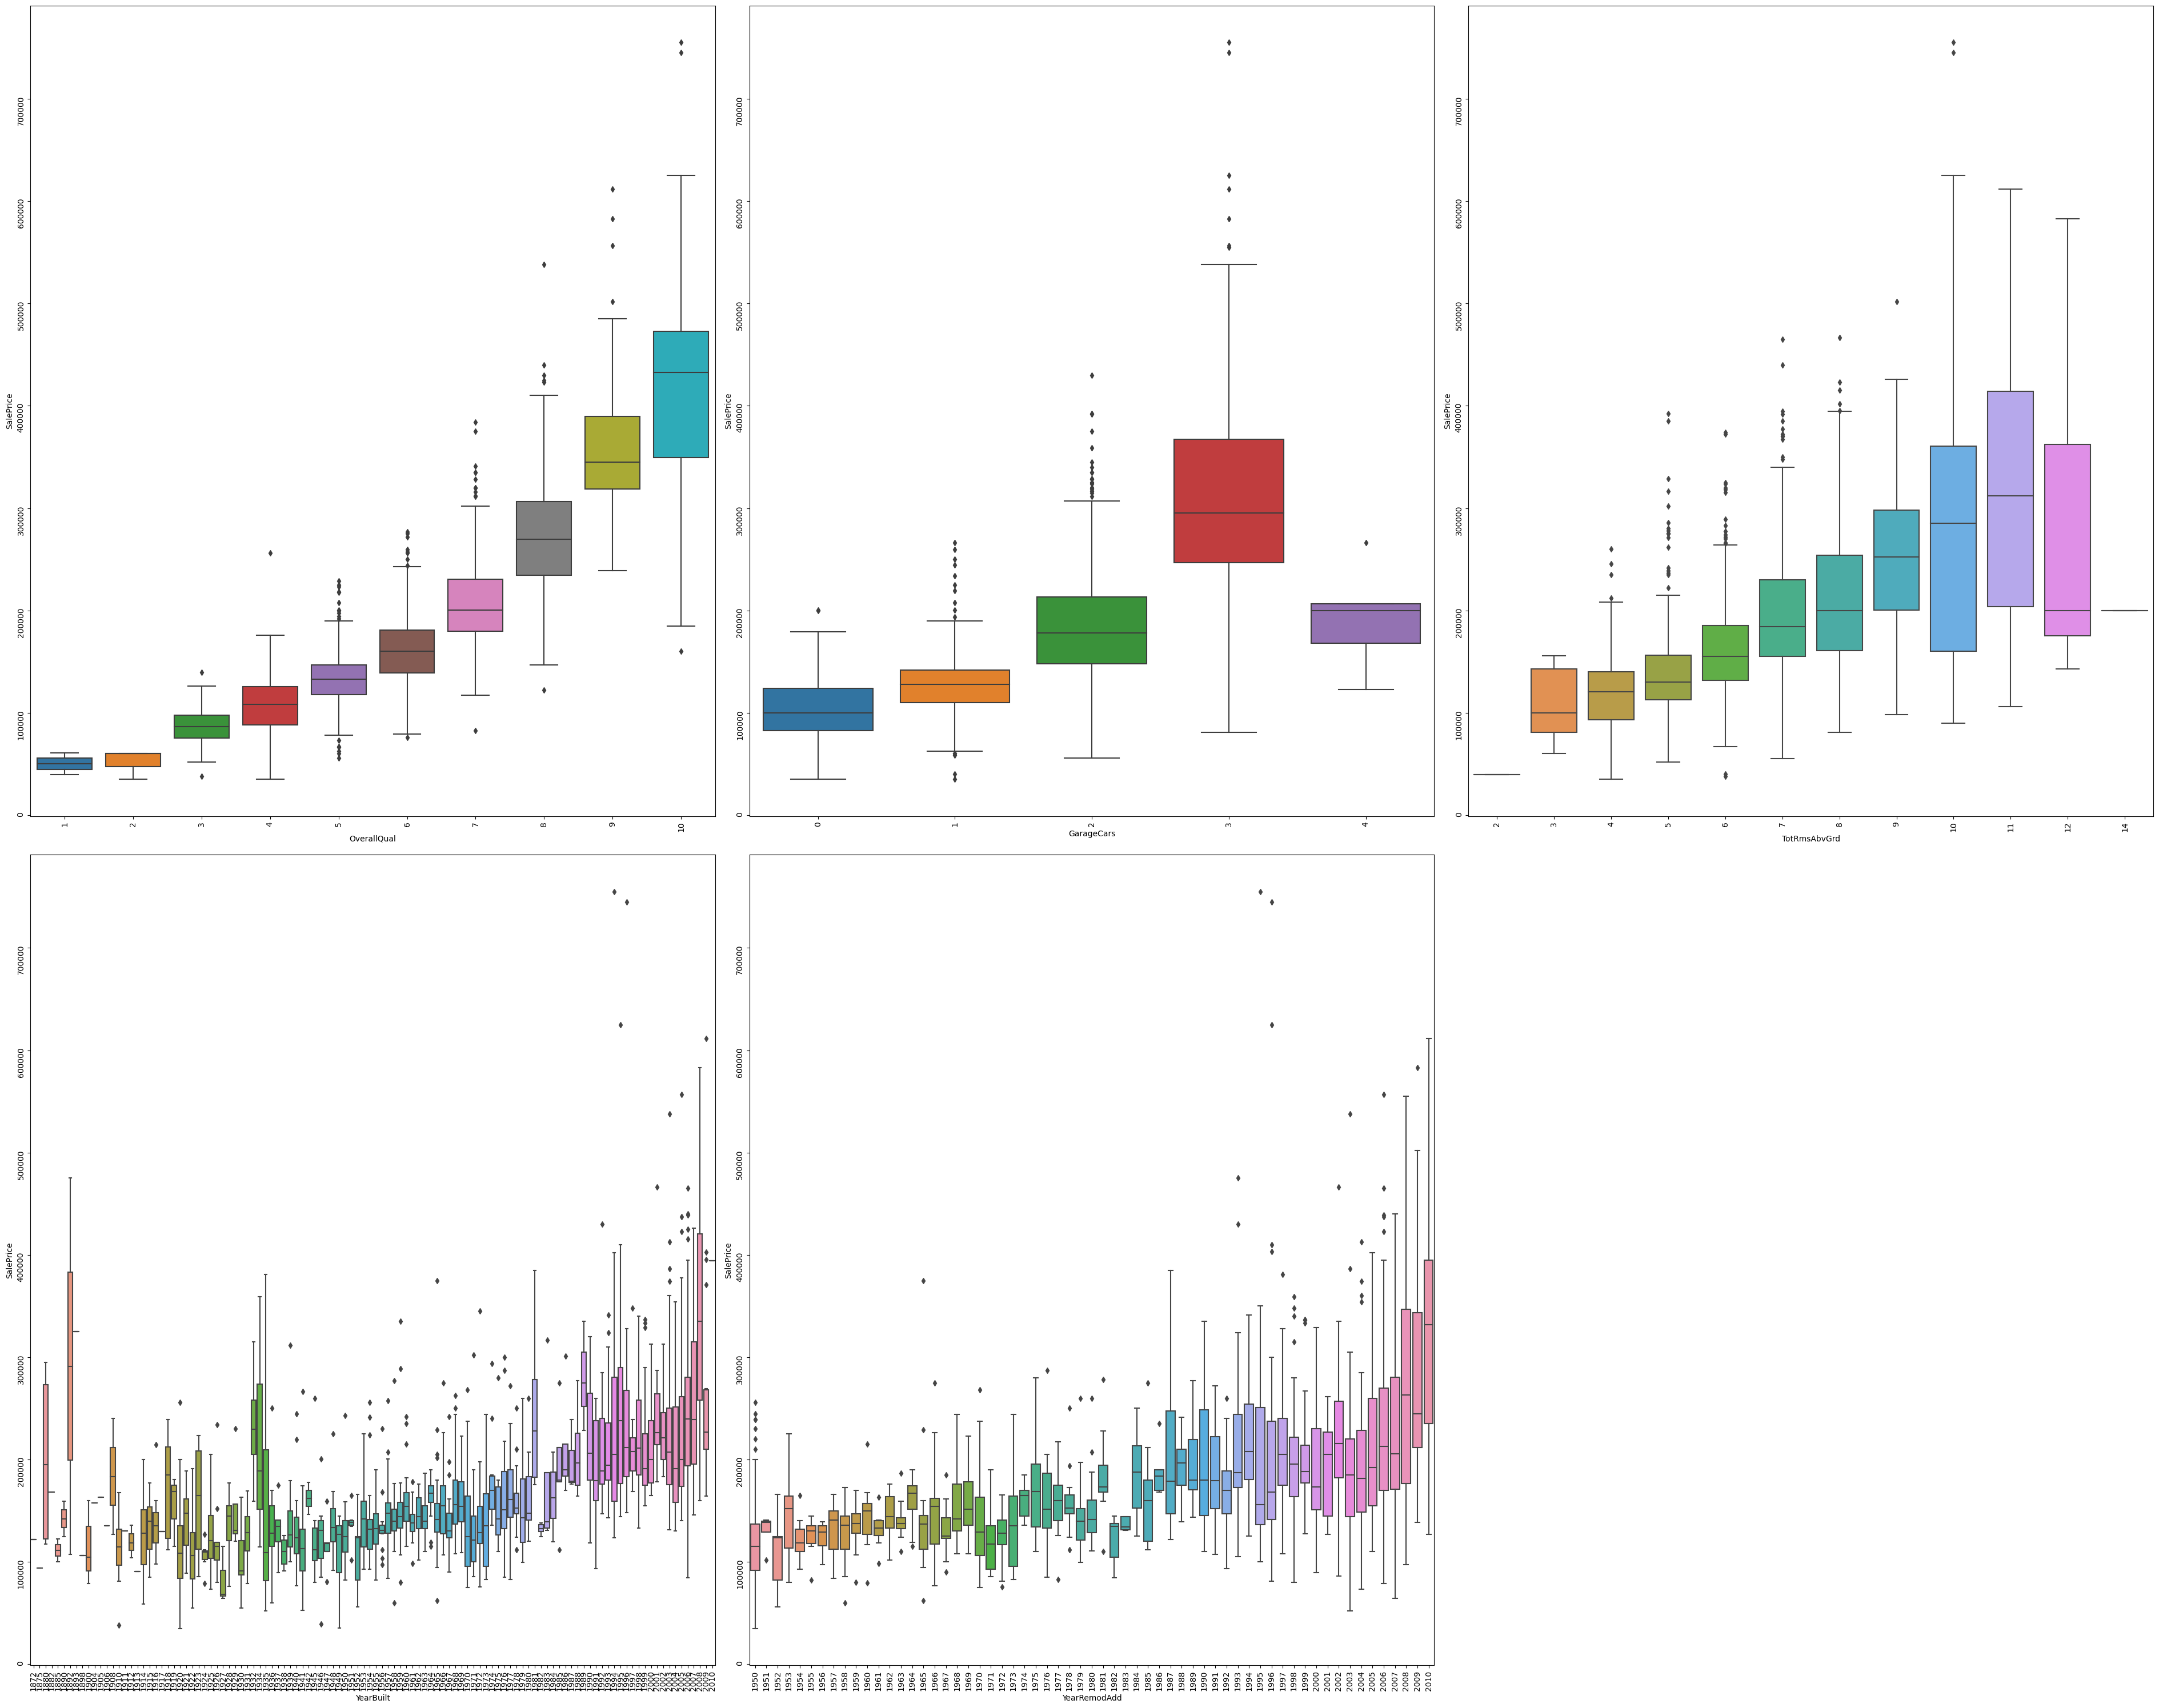

In [10]:
features_box_plot = ['OverallQual', 'GarageCars', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']

axis_x = 0
axis_y = 0
fig, axes = plt.subplots(2, 3, figsize=(38, 30))
for fbp in features_box_plot:
    f = sns.boxplot(ax=axes[axis_x, axis_y], data=initial_training_set, x=fbp, y='SalePrice')
    f.axis(ymin=0, ymax=800000)
    axes[axis_x, axis_y].tick_params(rotation=90)
    axes[axis_x, axis_y].autoscale(enable=True)
    fig.tight_layout()
    if axis_y == 2:
        axis_x = 1
        axis_y = 0
    else:
        axis_y += 1

fig.delaxes(axes[axis_x][2])

Possiamo notare che *OverallQual* influisce molto sul prezzo, infatti all'aumentare della qualità aumenta anche il valore target; infatti, la mediana di ogni plot tende ad aumentare. Sulle altre feature, la mediana non segue un andamento completamente crescente.
In ogni caso, come per le feature numeriche, si notano degli outliers per ogni feature.

## 1.2 Distribuzione normale
La **distribuzione normale**, detta anche curva Gaussiana, è senza dubbio la distribuzione più usata in statistica.
La distribuzione normale si distingue dalle altre distribuzioni di probabilità in quanto possiede le seguenti caratteristiche:
- **Simmetria**: è simmetrica o centrata rispetto al valore medio;
- **Valori centrali**: media, moda e mediana coincidono;
- **Probabilità**: dipende da due parametri: media (µ) e varianza (σ2);
- **Forma**: dipende dalla deviazione standard (σ).


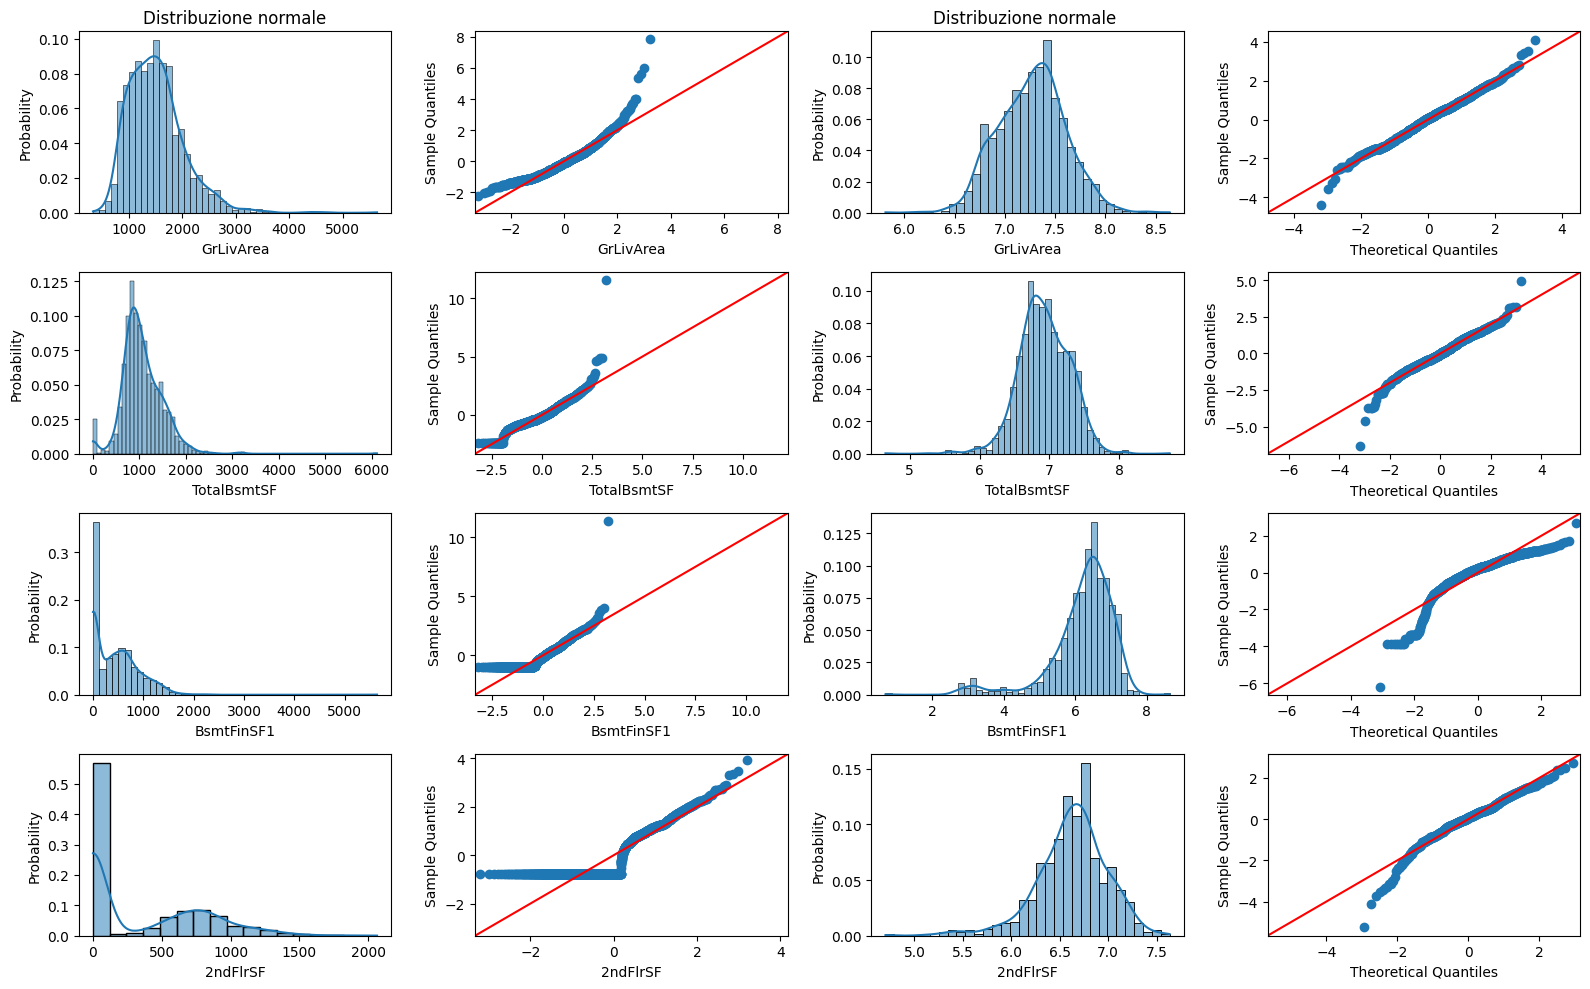

In [11]:
import statsmodels.api as sm


def distribution_plot(train_df: DataFrame, features: str):
    fig, axes = plt.subplots(features.__len__(), 4, figsize=(16, 10))
    axis = 0
    for feature in features:
        sns.histplot(ax=axes[axis, 0], data=train_df, x=feature, kde=True, stat="probability")
        sm.qqplot(ax=axes[axis, 1], data=train_df[feature], line='45', fit=True)
        # in questo caso si considerano valori > 0
        sns.histplot(ax=axes[axis, 2], data=np.log(train_df[train_df[feature] > 0][feature]),
                     kde=True, stat="probability")
        sm.qqplot(ax=axes[axis, 3], data=np.log(train_df[train_df[feature] > 0][feature]), line='45', fit=True)
        axes[0, 0].set_title("Distribuzione normale")
        axes[0, 2].set_title("Distribuzione normale ")
        axes[axis, 0].set_xlabel(feature)
        axes[axis, 1].set_xlabel(feature)
        plt.tight_layout()
        axis += 1


distribution_plot(initial_training_set, features_pair_plot)

Nelle prime figure, solo **GrLivArea** sembra avere una distribuzione normale ma non viene confermata dalla seconda figura. Mentre, dopo aver applicato la normalizzazione dei dati si nota che in tutte le feature si ottiene una distribuzione normale, infatti, possiamo notare una curva a campana e i punti tendono a seguire la retta rossa.

# 2. Data cleaning
L'obiettivo principale di questa analisi è identificare e adottare strategie efficaci per gestire i valori nulli presenti nel dataset. Inizialmente, verrà eseguita un'accurata esplorazione dei dati per individuare la presenza di valori mancanti; questa fase di esplorazione fornirà una panoramica iniziale della quantità e della natura dei valori nulli nel dataset.
Successivamente, saranno prese in considerazione diverse strategie per gestire i valori nulli.

Primo passo è individuare la **percentuale** di **valori mancanti** e provvedere alla loro **eliminazione** se sono maggiori rispetto ad una certa soglia; questa conclusione è dovuta al fatto che sostituire i valori mancanti se questi costituiscono con un'alta percentuale del dataset per una feature, potrebbe compromettere significativamente il dataset.

Il secondo passo è sostituire i valori delle colonne che hanno una piccola percentuale di valori mancanti. Questo processo, è stato realizzato in diverse modalità:
  - utilizzo della **media** per **colonne numeriche**;
  - utilizzo della **moda** per **colonne categorice**;

Una gestione adeguata dei valori mancanti contribuisce a garantire l'affidabilità e l'accuratezza dei modelli, evitando distorsioni e fornendo una base solida per le analisi successive.

Questo passaggio è necessario per il corretto funzionamento dei metodi di feature selection, feature extraction e per i modelli di machine learning che utilizzeremo.


## 2.1 Rimozione delle colonne con molti valori nulli
Visualizziamo in un grafico le feature che hanno almeno un valore nullo.

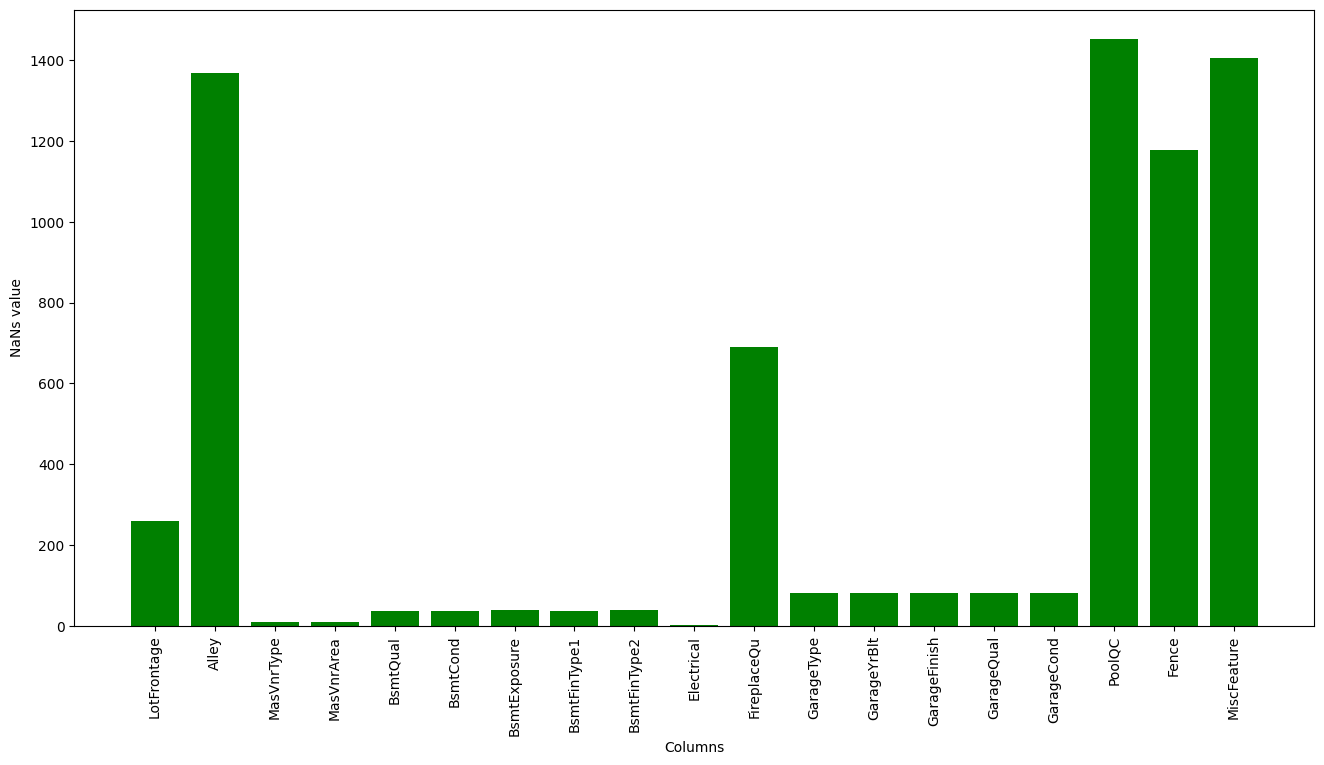

Colonne con valori nulli:  19


In [12]:
def get_nan_cols(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Index]:
    """ Restituisce:
        0: un dataframe con nome colonna, numero null
        1: una lista (Index) con i nomi delle colonne che hanno valori nulli
    """
    count_nan = dataset.isnull().sum(axis=0)
    columns_with_nan_df = count_nan.loc[count_nan != 0]
    nan_cols_names = dataset.columns[dataset.isna().any()]
    return columns_with_nan_df, nan_cols_names


def get_cols_with_nan_number(dataset: pd.DataFrame):
    print("Colonne con valori nulli: ", len(get_nan_cols(dataset)[1].to_list()))


def check_nan_value(dataset):
    # Verifichiamo se ci sono valori NaN
    columns_with_nan_df, nan_cols_names = get_nan_cols(dataset)
    pd.DataFrame(data=nan_cols_names)
    plt.figure(figsize=(16, 8))
    plt.bar(nan_cols_names, columns_with_nan_df, color="green")
    plt.xlabel("Columns")
    plt.xticks(rotation=90)
    plt.ylabel("NaNs value")
    plt.show()


check_nan_value(initial_training_set)
get_cols_with_nan_number(initial_training_set)

Notiamo che ci sono 19 colonne che hanno almeno un valore nullo. In particolare, **Alley**, **PoolQC**, **Fence** e **MiscFeature** hanno più dell'85% di valori nulli, quindi provvediamo alla loro **eliminazione**.

Numero di valori non nulli minimo:  1169


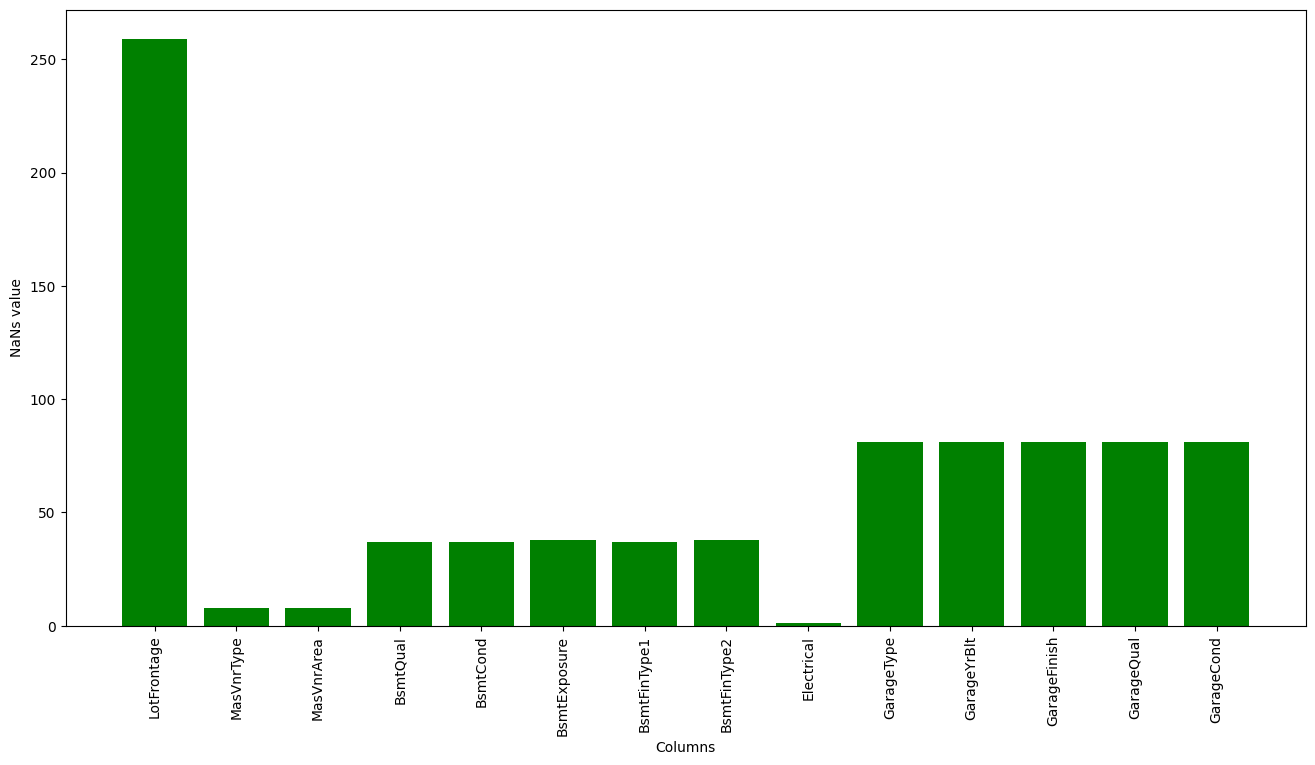

Colonne con valori nulli:  14


In [13]:
def remove_nan_columns(dataset: DataFrame, threshold=80) -> DataFrame:
    """Elimina colonne con valori NaN quando i valori Nan sono superiori a [threshold]%"""
    thresh = int((len(dataset) * threshold) / 100) + 1
    print("Numero di valori non nulli minimo: ", thresh)
    # axis: specifichiamo di eliminare solo le colonne; thresh: numero minimo per eliminare
    dataset.dropna(axis='columns', thresh=thresh, inplace=True)
    return dataset


initial_training_set2 = remove_nan_columns(initial_training_set)
check_nan_value(initial_training_set2)  # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)

Da un numero di feature iniziali con valori mancanti pari a **19**, con l'eliminazione delle feature che hanno più dell'80% di valori nulli, si ottiene un numero di feature pari a **14**.

## 2.2 Sostituzione dei valori nulli nelle feature numeriche

Le feature numeriche sono le seguenti:


In [14]:
numerical_cols = initial_training_set2.select_dtypes(include='number').columns.to_list()
numerical_train = initial_training_set2[numerical_cols]
print(numerical_cols)

['Id', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SalePrice']


La colonna **Id** non è necessaria, quindi la eliminiamo dal dataset.

In [15]:
if len(numerical_cols) > 0 and numerical_cols[0] == 'Id':
    del numerical_cols[0]
numerical_train = numerical_train.drop(['Id'], axis=1, errors='ignore')
initial_training_set2 = initial_training_set2.drop(['Id'], axis=1, errors='ignore')

Una volta identificate le colonne numeriche con valori mancanti, il prossimo passo consiste nel calcolare la **media** dei valori esistenti in ciascuna colonna.

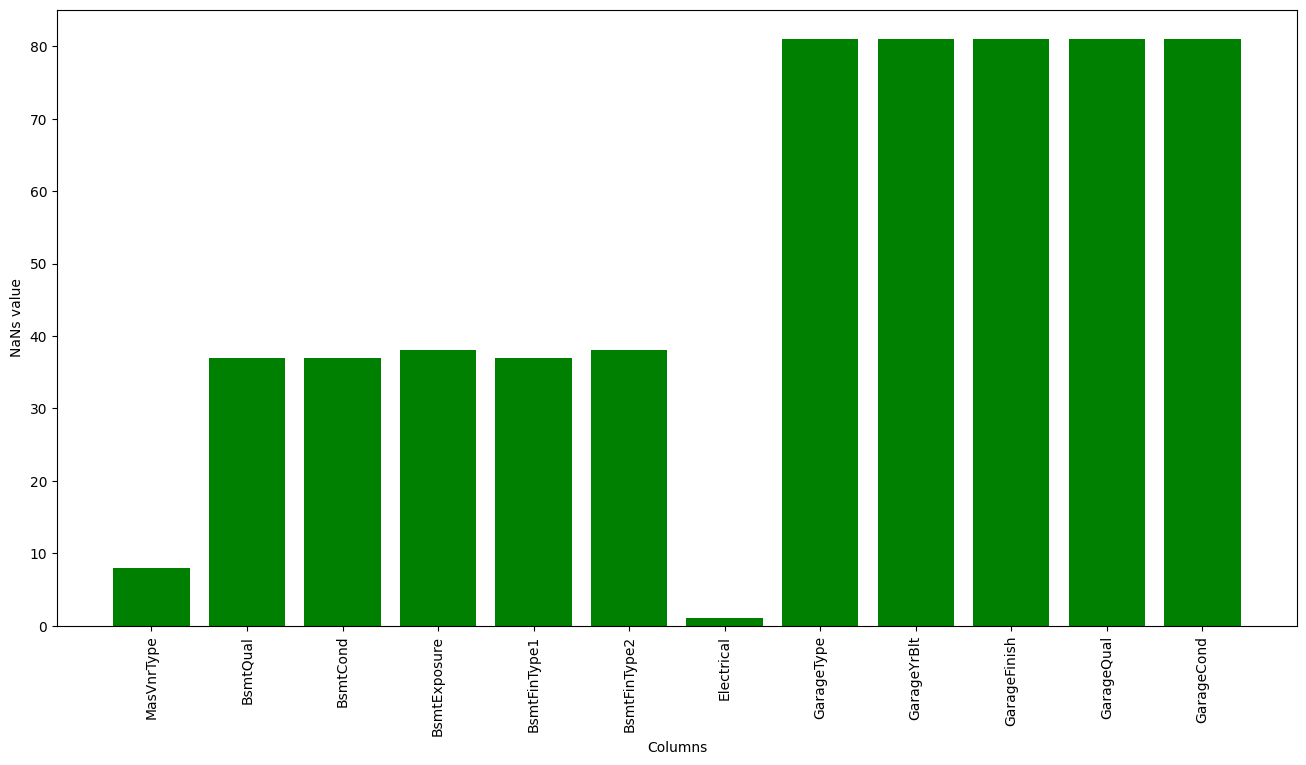

Colonne con valori nulli:  12


In [16]:
initial_training_set2 = initial_training_set2.fillna(initial_training_set2[numerical_cols].mean())
check_nan_value(initial_training_set2)  # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)
#print(initial_training_set2)

Dopo la sostituzione dei valori mancanti sulle colonne numeriche, rimangono solo **12** colonne con valori mancanti.
Inoltre, bisogna avere per le colonne numeriche tutti lo stesso tipo; infatti, ci sono delle colonne che hanno tipo **int64** e li convertiamo in **float64**:

In [17]:
columns_float = initial_training_set2[numerical_cols].astype('int64').columns
initial_training_set2[columns_float] = initial_training_set2[columns_float].astype('float64')
print(initial_training_set2[numerical_cols].dtypes)

LotFrontage      float64
LotArea          float64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF         float64
2ndFlrSF         float64
LowQualFinSF     float64
GrLivArea        float64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath         float64
HalfBath         float64
BedroomAbvGr     float64
KitchenAbvGr     float64
TotRmsAbvGrd     float64
Fireplaces       float64
GarageCars       float64
GarageArea       float64
WoodDeckSF       float64
OpenPorchSF      float64
EnclosedPorch    float64
3SsnPorch        float64
ScreenPorch      float64
PoolArea         float64
MiscVal          float64
MoSold           float64
SalePrice        float64
dtype: object


## 2.3 Sostituzione dei valori nulli nelle feature categoriche

Le feature categoriche sono le seguenti:

In [18]:
categorical_cols = initial_training_set2.select_dtypes(include='object').columns.to_list()
categorical_train = initial_training_set2[categorical_cols]
print(categorical_cols)

['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'YrSold', 'SaleType', 'SaleCondition']


Una volta identificate le colonne categoriche con valori mancanti, il primo passo consiste nel calcolare la **moda** dei valori esistenti in ciascuna colonna.

In [19]:
mode = categorical_train.mode()
print(f"Valori più frequenti\n{mode.iloc[0]}\n\n")
initial_training_set2 = initial_training_set2.fillna(mode.iloc[0])
get_cols_with_nan_number(initial_training_set2)

Valori più frequenti
MSSubClass            20
MSZoning              RL
Street              Pave
LotShape             Reg
LandContour          Lvl
Utilities         AllPub
LotConfig         Inside
LandSlope            Gtl
Neighborhood       NAmes
Condition1          Norm
Condition2          Norm
BldgType            1Fam
HouseStyle        1Story
OverallQual            5
OverallCond            5
YearBuilt           2006
YearRemodAdd        1950
RoofStyle          Gable
RoofMatl         CompShg
Exterior1st      VinylSd
Exterior2nd      VinylSd
MasVnrType          None
ExterQual             TA
ExterCond             TA
Foundation         PConc
BsmtQual              TA
BsmtCond              TA
BsmtExposure          No
BsmtFinType1         Unf
BsmtFinType2         Unf
Heating             GasA
HeatingQC             Ex
CentralAir             Y
Electrical         SBrkr
KitchenQual           TA
Functional           Typ
GarageType        Attchd
GarageYrBlt       2005.0
GarageFinish         Unf
Gara

## 2.4 Rimozione delle colonne correlate
Dall'analisi effettuata precedentemente, nella matrice di correlazione ci sono coppie di feature che sono altamente correlate tra loro; quindi, per ogni coppia, eliminiamo dal dataset la feature che impatta di meno sul target rispetto all'altra.

In [20]:
print(len(initial_training_set2.columns))
initial_training_set3 = initial_training_set2.drop(columns=worst_features_list, axis=1)
print(len(initial_training_set3.columns))

75
67


Nella fase di *cleaning* del dataset, dopo aver:
   - rimosso le feature che hanno una percentuale di valori mancanti superiore all'80%;
   - sostituito i valori mancanti con la media e la moda;
   - rimosso le feature correlate,

 si ottiene un dataset con un numero di feature pari a 67.

# 2. Preprocessing
Durante la fase di **preprocessing** dei dati, è comune incontrare variabili categoriche nel dataset, ovvero variabili che rappresentano categorie o classi anziché valori numerici continui. Per utilizzare queste variabili in modelli di machine learning, è necessario convertirle in forma numerica.
Due tecniche comuni per eseguire questa trasformazione sono l'**encoding one-hot** e l'**encoding ordinale**.

La scelta tra encoding one-hot e encoding ordinale dipende dalla natura delle variabili categoriche e dal contesto del problema. Se le categorie non presentano un ordine intrinseco, è consigliabile utilizzare l'encoding one-hot per evitare di introdurre un ordine artificiale. Tuttavia, se esiste un ordine o una gerarchia tra le categorie, l'encoding ordinale può essere una scelta appropriata per catturare tali relazioni.


Inoltre, poiché diverse feature corrispondono ad anni (e.g. di costruzione, ristrutturazione, ...), si è pensato di trasformare le date in feature categoriche divise in due categorie: gli anni antecedenti al 2000 e quelli successivi. Dopodiché includiamo queste feature tra quelle di cui fare one-hot encoding, in quanto non è possibile dire con certezza se un anno di vendita o ristrutturazione è migliore rispetto a un altro in base a un ordine.

In [21]:
features_year = [
    'YrSold',
    'GarageYrBlt',
    'YearRemodAdd',
    'YearBuilt'
]

Le features che corrispondo ad **anni** sono state trasformate in range di anni, per ridurre il numero di feature dopo OneHotEncoder.

In [22]:
def trasforma_range_anni(dataset: DataFrame, features: List[str], start_year, end_year_inclusive, range_step):
    # start_range = range(1900, 2041, 20)
    # end_range = range(1920, 2041, 20)
    start_range = range(start_year, end_year_inclusive + 1, range_step)
    end_range = range(start_year + range_step, end_year_inclusive + 1, range_step)
    range_labels = []
    for i in range((end_year_inclusive - start_year) // range_step):
        range_labels.append(str(start_range[i]) + "-" + str(end_range[i]))

    for f in features:
        dataset[f] = pd.cut(dataset[f], bins=list(start_range), labels=range_labels)
    return dataset


initial_training_set4 = trasforma_range_anni(initial_training_set3, features_year, 1900, 2100, 100)
# TypeError: '<' not supported between instances of 'int' and 'str' -> Eseguire la cella prima che inizializza initial_training_set3


Successivamente, stabiliamo le colonne categoriche che vanno trasformate con l'**ordinal encoding** e quelle che vanno trasformate con l'one hot encoding, a partire dal file `valutazioneFeature.csv`.

In [23]:
# Ex,Gd,TA,Fa,Po,NA
ordinal_enc_cols = [
    #'OverallCond',
    #'OverallQual',
    "ExterQual",
    "KitchenQual",
    "ExterCond",
    "HeatingQC",
    "BsmtCond",
    "GarageCond",
    "GarageQual",
    "BsmtQual",
]

# Gd,Av,Mn,No,NA
ordinal_enc_cols1 = [
    "BsmtExposure",
]

# GLQ,ALQ,BLQ,Rec,LwQ,Unf,NA
ordinal_enc_cols2 = [
    "BsmtFinType1",
    "BsmtFinType2",
]

onehot_enc_cols = [
    'YrSold',
    'GarageYrBlt',
    'YearRemodAdd',
    'YearBuilt',
    'MSSubClass',
    "MSZoning",
    "Condition1",
    "Electrical",
    "Functional",
    "Utilities",
    "Condition2",
    "Exterior1st",
    "BldgType",
    "CentralAir",
    "Exterior2nd",
    "Heating",
    "HouseStyle",
    "RoofMatl",
    "Street",
    "LotConfig",
    "Neighborhood",
    "LandSlope",
    "Foundation",
    "LandContour",
    "MasVnrType",
    "PavedDrive",
    "RoofStyle",
    "SaleType",
    "GarageFinish",
    "GarageType",
    "LotShape",
    "SaleCondition"
]


## 3.1 Ordinal encoding
L'**encoding ordinale**  viene utilizzato quando le categorie presentano un ordine o una gerarchia intrinseca.


In [24]:
def ordinal_encoding(dataset: DataFrame, ord_enc_cols: List[str], val) -> DataFrame:
    # applica l'ordinal Encoding alle colonne categoriche che rappresentano una valutazione
    copy = dataset.copy()
    for cat in ord_enc_cols:
        if cat in dataset.columns:
            #copy[cat], _ = pd.factorize(dataset[cat])
            copy[cat] = copy[cat].map(val)

    return copy


val = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
initial_training_set5 = ordinal_encoding(initial_training_set4, ordinal_enc_cols, val)
val = {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0}
initial_training_set5 = ordinal_encoding(initial_training_set5, ordinal_enc_cols1, val)
val = {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0}
initial_training_set5 = ordinal_encoding(initial_training_set5, ordinal_enc_cols2, val)

print("Alcune delle colonne prima e dopo l'ordinal encoding")
print(initial_training_set4[ordinal_enc_cols[:5]])
print(initial_training_set5[ordinal_enc_cols[:5]])


Alcune delle colonne prima e dopo l'ordinal encoding
     ExterQual KitchenQual ExterCond HeatingQC BsmtCond
0           Gd          Gd        TA        Ex       TA
1           TA          TA        TA        Ex       TA
2           Gd          Gd        TA        Ex       TA
3           TA          Gd        TA        Gd       Gd
4           Gd          Gd        TA        Ex       TA
...        ...         ...       ...       ...      ...
1455        TA          TA        TA        Ex       TA
1456        TA          TA        TA        TA       TA
1457        Ex          Gd        Gd        Ex       Gd
1458        TA          Gd        TA        Gd       TA
1459        Gd          TA        TA        Gd       TA

[1460 rows x 5 columns]
      ExterQual  KitchenQual  ExterCond  HeatingQC  BsmtCond
0             4            4          3          5         3
1             3            3          3          5         3
2             4            4          3          5         3
3     

## 3.2 One hot encoding
L'**encoding one-hot** è una tecnica di trasformazione che crea variabili dummy per ogni categoria presente nella variabile categorica. Queste variabili assumeranno il valore 1 se l'osservazione corrisponde alla categoria corrispondente e 0 altrimenti. Questo tipo di encoding viene utilizzato quando non esiste un'ordine intrinseco tra le categorie.

In [25]:
initial_training_set5.shape[1]

67

In [26]:
from sklearn.preprocessing import OneHotEncoder


def one_hot_encoding(dataset: DataFrame, one_hot_cols: List[str]) -> DataFrame:
    """
    Mappa le features categoriche in nuove colonne in formato one-hot
    :param dataset: self.train o self.test
    :return: il DataFrame di train o test con le stringhe trasformate in ulteriori colonne one-hot (con i nomi)
    """

    copy = dataset.copy()

    # applica il One Hot Encoding alle colonne categoriche
    onehot_encoder = OneHotEncoder(sparse_output=False)
    encoded_features = onehot_encoder.fit_transform(dataset[one_hot_cols])
    encoded_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out())

    #encoded_df = pd.get_dummies(dataset[one_hot_cols])
    # aggiunge il prefisso al nome delle colonne
    #prefix_dict = {col: f"{col}_{val}" for col in one_hot_cols for val in dataset[col].unique()}

    #encoded_df.add_prefix('').rename(columns=prefix_dict)

    only_non_one_hot = copy.drop(columns=one_hot_cols, axis=1)
    result_df = pd.concat([only_non_one_hot, encoded_df], axis=1)

    return result_df


initial_training_set6 = one_hot_encoding(initial_training_set5, one_hot_cols=onehot_enc_cols)
initial_training_set6.to_csv("../dataset/train_encoded.csv", index=False)
print(initial_training_set6.shape[1])

241


Notiamo che il numero di colonne è passato da 68 a 241 dopo aver effettuato ordinal encoding e one hot encoding. Quindi in seguito, sarà necessario determinare quali colonne sono più informative rispetto alla variabile target SalePrice.

# 3. Shuffle e suddivisione training - testing set
Lo **shuffle** dei dati e la **suddivisione in training e test set** sono due procedure importanti durante la fase di preparazione dei dati per l'addestramento e la valutazione di modelli di machine learning.

Quando lavoriamo con un dataset, è importante che i dati siano ordinati in modo casuale. Lo **shuffle** dei dati è importante per evitare qualsiasi tipo di ordine o struttura nei dati che potrebbe influenzare negativamente la performance del modello.

La **suddivisione dei dati in training set e test set** è essenziale per valutare l'efficacia del modello sulle nuove osservazioni non ancora viste. Il training set viene utilizzato per addestrare il modello, mentre il test set viene utilizzato per valutare le sue prestazioni su dati indipendenti. Questa suddivisione consente di stimare quanto bene il modello generalizza su dati non visti in precedenza.

In [27]:
# shuffle
initial_training_shuffle = initial_training_set6.sample(frac=1, random_state=42).reset_index(drop=True)
# split
initial_X = initial_training_shuffle.iloc[:,
            initial_training_shuffle.columns != 'SalePrice']  # tutte le colonne tranne il target
initial_y = pd.Series(initial_training_shuffle["SalePrice"], name="SalePrice")  # solo target
X_train, X_test, y_train, y_test = train_test_split(initial_X, initial_y, test_size=0.2, random_state=42)

print(f"shape train X: {X_train.shape}")
print(f"shape train y: {y_train.shape}")
print(f"shape test X: {X_test.shape}")
print(f"shape test y: {y_test.shape}")

#print(X_train)

shape train X: (1168, 240)
shape train y: (1168,)
shape test X: (292, 240)
shape test y: (292,)


Di seguito, definiamo una funzione che permette di normalizzare i dati per migliorare l'accuratezza dei modelli.

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


def scale_features(X_df, y_train=None, scaler=StandardScaler()):
    if y_train is not None:
        res = scaler.fit_transform(X_df, y_train)
    else:
        res = scaler.transform(X_df)
    return pd.DataFrame(res, columns=X_df.columns)

Di seguito, definiamo una classe **Dataset** che permette di selezionare diversi dataset (e.g. normalizzato/non normalizzato, con/senza feature selection) in base alle proprie esigenze:

In [29]:
class Dataset:
    """
    Classe che definisce il nostro dataset, separato in training e testing set, 
    normalizzato o meno e con o senza feature selection. Va inizializzato con un solo fold (es. 80/20)
    """

    def __init__(self, X_train: DataFrame, y_train: Series, X_test: DataFrame, y_test: Series,
                 scaler=StandardScaler()):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_train_normalized = None
        self.X_test_normalized = None
        self.X_train_fs = None
        self.X_test_fs = None
        self.scaler = scaler
        self.scale_features()

    def check_ok(self, initial_size):
        return self.X_train.shape[0] + self.X_test.shape[0] == initial_size

    def scale_features(self):
        self.X_train_normalized = scale_features(X_df=self.X_train, y_train=self.y_train, scaler=self.scaler)
        self.X_test_normalized = scale_features(X_df=self.X_test, y_train=None, scaler=self.scaler)

    def num_features(self) -> int:
        return self.X_train.shape[1]

# StandardScaler: Standardizza i valori delle features in modo che assumano valori secondo una distribuzione gaussiana di media 0 e varianza 1
dataset_standard = Dataset(X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(), scaler=StandardScaler())
# RobustScaler: scala le features azzerando la mediana e usando l'Inter-Quartile-Range tra il I e il III quartile. Più robusto agli outliers.
dataset_robust = Dataset(X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(), scaler=RobustScaler())
# MinMaxScaler: scale le features con valori tra 0 e 1.
dataset_minmax = Dataset(X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(), scaler=MinMaxScaler())
# il motivo per cui scegliamo il dataset robust sarà spiegato al capitolo 5.
dataset = dataset_robust

Di seguito, definiamo una classe **Fold** che permette di addestrare e testare su diversi split del dataset.

In [30]:
class Fold:
    def __init__(self, fold_id: int, X_train: DataFrame, y_train: Series, X_test: DataFrame, y_test: DataFrame,
                 scaler=StandardScaler()):
        self.fold_id = fold_id
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_train_normalized = None
        self.X_test_normalized = None
        self.X_train_normalized_fs = None
        self.X_test_normalized_fs = None
        self.scaler = scaler
        self.scale_features()

    def check_ok(self, initial_size):
        return self.X_train.shape[0] + self.X_test.shape[0] == initial_size

    def print_shapes(self):
        print(f"{self.fold_id} shape x train: {self.X_train.shape} " +
              f"{self.fold_id} shape y train: {self.y_train.shape} " +
              f"{self.fold_id} shape x test : {self.X_test.shape} " +
              f"{self.fold_id} shape y test : {self.y_test.shape}")

    def scale_features(self):
        self.X_train_normalized = scale_features(self.X_train, self.scaler)
        self.X_test_normalized = scale_features(self.X_test, self.scaler)


def split_dataset(initial_dataset_x: DataFrame, initial_y: Series, splits=10, scaler=RobustScaler()) -> List[Fold]:
    lista: List[Fold] = []
    n_elements = len(initial_dataset_x)
    for split in range(splits):
        # dataset: |-1-|-2-|...|-10-|
        if split == 0:  # training: |-2-10| testing: |-1-|
            f = Fold(fold_id=split,
                     X_train=initial_dataset_x.iloc[(n_elements // splits):, :],
                     y_train=initial_y[(n_elements // splits):],
                     X_test=initial_dataset_x.iloc[:(n_elements // splits), :],
                     y_test=initial_y[:(n_elements // splits)], 
                     scaler=scaler)
            lista.append(f)
        elif split == n_elements - 1:  # training: |-1-9| testing: |-10-|
            f = Fold(fold_id=split,
                     X_train=initial_dataset_x.iloc[:split * (n_elements // splits), :],
                     y_train=initial_y[:split * (n_elements // splits)],
                     X_test=initial_dataset_x.iloc[split * (n_elements // splits):, :],
                     y_test=initial_y[split * (n_elements // splits):], 
                     scaler=scaler)
            lista.append(f)
        else:  # training: |-1-i||(i+1)-10| testing: |-i-(i+1)-|
            before_test_x = initial_dataset_x.iloc[:split * (n_elements // splits), :]
            after_test_x = initial_dataset_x.iloc[(split + 1) * (n_elements // splits):, :]

            x_train_appended: DataFrame = pd.concat([before_test_x, after_test_x])
            before_test_y = initial_y[:split * (n_elements // splits)]
            after_test_y = initial_y[(split + 1) * (n_elements // splits):]
            y_train_appended = pd.concat([before_test_y, after_test_y])

            lista.append(Fold(fold_id=split,
                              X_train=x_train_appended,
                              y_train=y_train_appended,
                              X_test=initial_dataset_x.iloc[split * (n_elements // splits):(split + 1) * (n_elements // splits), :],
                              y_test=initial_y[split * (n_elements // splits):(split + 1) * (n_elements // splits)], 
                              scaler=scaler))
    return lista


# IMPORTANTE questa variabile folds deve essere usata nel seguito al posto di X_train / y_train / X_test / y_test
folds = split_dataset(initial_X.copy(), initial_y.copy(), splits=5, scaler=RobustScaler())

Verifichiamo la corretta suddivisione del train e split in diversi fold:

In [31]:
for i, f in enumerate(folds):
    f.print_shapes()
    # print(f.X_train)
    if not f.check_ok(len(initial_X)):
        raise "ERROR la somma delle lunghezze di train X / y e test X / y non coincide con la lunghezza iniziale"

0 shape x train: (1168, 240) 0 shape y train: (1168,) 0 shape x test : (292, 240) 0 shape y test : (292,)
1 shape x train: (1168, 240) 1 shape y train: (1168,) 1 shape x test : (292, 240) 1 shape y test : (292,)
2 shape x train: (1168, 240) 2 shape y train: (1168,) 2 shape x test : (292, 240) 2 shape y test : (292,)
3 shape x train: (1168, 240) 3 shape y train: (1168,) 3 shape x test : (292, 240) 3 shape y test : (292,)
4 shape x train: (1168, 240) 4 shape y train: (1168,) 4 shape x test : (292, 240) 4 shape y test : (292,)


# 5. Feature Selection
La **feature selection** è un'importante fase nel processo di sviluppo di un modello di machine learning. Consiste nell'identificazione e nella scelta delle caratteristiche rilevanti nel dataset che contribuiscono maggiormente alla previsione del target o all'obiettivo del modello.
- **Riduzione della complessità**: molte volte i dataset contengono un gran numero di caratteristiche o variabili che potrebbero non essere tutte informative o utili per il modello aumentando la complessità del modello e causare overfitting;
- **Miglior interpretazione**: utilizzando un numero limitato di caratteristiche significative, diventa più facile comprendere il processo di decisione del modello e interpretare i risultati;
- **Miglioramento delle prestazioni**: la selezione delle caratteristiche può contribuire a migliorare le prestazioni del modello;
- **Riduzione dei tempi di addestramento**: riducendo il numero di caratteristiche utilizzate per l'addestramento, la feature selection può anche contribuire a ridurre i tempi di addestramento del modello.

Due tecniche comuni utilizzate per la selezione delle caratteristiche sono **SelectKBest** e la **mutua informazione**. Esploriamo l'utilizzo di entrambe le tecniche:
- La tecnica **SelectKBest** si basa su misure univariate per selezionare le k caratteristiche più significative nel dataset. La selezione viene eseguita calcolando una metrica specifica per ogni caratteristica rispetto al target e le caratteristiche con i punteggi più alti vengono considerate le più informative e vengono selezionate per l'uso nel modello di machine learning;
- La **mutua informazione** è una misura statistica che valuta la dipendenza tra due variabili e viene utilizzata per misurare la relazione tra ciascuna caratteristica e il target. Maggiore è la mutua informazione tra una caratteristica e il target, maggiore è l'informazione fornita da quella caratteristica per la previsione del target; quindi, si possono identificare le variabili che contribuiscono maggiormente alla previsione del target.

L'utilizzo congiunto di SelectKBest e la mutua informazione permette di ridurre il rischio de selezionare le caratteristiche non significative e può contribuire alla riduzione del rischio di overfitting.


In [32]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression


def mutual_info_feature_selection(x_train: DataFrame, y_train: Series, k: int) -> DataFrame:
    selector = SelectKBest(mutual_info_regression, k=k)
    x_new = selector.fit_transform(x_train, y_train)
    return pd.DataFrame(x_new, columns=selector.get_feature_names_out())


def mutual_info_feature_selection_train_test(x_train: DataFrame, y_train: Series, X_test: DataFrame, k: int) -> Tuple[
    DataFrame, DataFrame]:
    x_train_fs = mutual_info_feature_selection(x_train, y_train, k)
    x_test_fs = X_test[x_train_fs.columns]
    return x_train_fs, x_test_fs


# Esempio di FS Senza normalizzazione
fs_X_train, fs_X_test = mutual_info_feature_selection_train_test(dataset.X_train, dataset.y_train, dataset.X_test, 4)
print(f"old shape = {dataset.X_train.shape} - new shape = {fs_X_train.shape}")
print("Most important feature with no normalization", fs_X_train.columns)

# Esempio di FS Con normalizzazione
fs_X_train_normalized, fs_X_test_normalized = mutual_info_feature_selection_train_test(dataset.X_train_normalized,
                                                                                       dataset.y_train, dataset.X_test,
                                                                                       10)
print(f"old shape = {dataset.X_train_normalized.shape} - new shape = {fs_X_train_normalized.shape}")
print("Most important feature with normalization", fs_X_train_normalized.columns)

old shape = (1168, 240) - new shape = (1168, 4)
Most important feature with no normalization Index(['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars'], dtype='object')


old shape = (1168, 240) - new shape = (1168, 10)
Most important feature with normalization Index(['OverallQual', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', 'GrLivArea',
       'KitchenQual', 'GarageCars', 'YearBuilt_2000-2100', 'Foundation_PConc',
       'GarageFinish_Unf'],
      dtype='object')


Nel considerare sia il dataset normalizzato e non, si ottengono le stesse feature che corrispondono alle feature della matrice di correlazione.

I metodi seguenti eseguono la feature selection per ogni fold, se non è stata già eseguita, e la feature selection solo su un singolo fold:

In [33]:
def do_fs_for_each_fold(folds: List[Fold], k_features, scaled=True):
    """ Esegue feature selection per ogni fold"""
    # eseguiamo la feature selection su tutti i fold e manteniamola in memoria, per ridurre il tempo di esecuzione totale
    for f in folds:
        x_train = f.X_train_normalized if scaled else f.X_train

        if f.X_train_normalized_fs is None:
            f.X_train_normalized_fs = mutual_info_feature_selection(x_train, f.y_train, k_features)
        if f.X_test_normalized_fs is None:
            f.X_test_normalized_fs = f.X_test_normalized[f.X_train_normalized_fs.columns]
    print("Feature selection... Done")
    return folds


def do_feature_selection(dataset: Dataset, k_features=129):
    """ Esegue feature selection su un singolo fold iniziale """
    if dataset.X_train_fs is None:
        dataset.X_train_fs = mutual_info_feature_selection(dataset.X_train, dataset.y_train, k_features)
    if dataset.X_test_fs is None:
        dataset.X_test_fs = dataset.X_test[dataset.X_train_fs.columns]
    print("Feature selection... Done")
    return dataset

## 5.1. Analisi delle Componenti Principali (PCA)
L'**Analisi delle Componenti Principali** (**PCA**) è un metodo di apprendimento **non supervisionato** che permette di rappresentare i dati complessi in uno spazio di dimensioni inferiori, preservando al contempo la maggior parte delle informazioni rilevanti.

PCA permette la:
- **Riduzione della dimensionalità**: permette di ridurre il numero di variabili all'interno di un dataset mantenendo comunque la massima variazione possibile;
- **Identificazione delle features più significative**: fornisce una visualizzazione compatta dei dati e aiuta a identificare le caratteristiche principali o i pattern nascosti presenti nel dataset;
- **Eliminazione della correlazione tra variabili**: permette di individuare e rimuovere la correlazione tra variabili all'interno di un dataset, semplificando l'interpretazione dei dati e riducendo la possibilità di problemi legati alla multicollinearità.

Di seguito, definiamo una funzione che permette di eseguire PCA sia sul training set che sul testing set:

In [34]:
from sklearn.decomposition import PCA


def pca_reduction(x_train, y_train, x_test, n_components=4) -> Tuple[DataFrame, DataFrame, PCA]:
    """
    Esegue la feature extraction Principal Component Analysis sia sul training set che sul testing set
    n_components deve essere minore del len(x_train)
    """
    if x_train.shape[1] < n_components:
        raise IndexError(
            f"Il numero di componenti da estrarre ({n_components}) deve essere minore uguale del numero iniziale di features ({x_train.shape[1]})")

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(x_train, y_train)
    X_test_pca = pca.transform(x_test)
    return pd.DataFrame(X_train_pca), pd.DataFrame(X_test_pca), pca

Determiniamo quale sia il miglior valore di `n_components` per PCA. Ricordiamo che più grande è l'autovalore e più varianza dei dati contiene.

In [35]:
def get_pca_eigen_things(pca: PCA) -> Tuple[Series, Series]:
    """
    Restituisce gli autovalori e la frazione di varianza cumulata della PCA
    """
    # Ogni autovalore della matrice di covarianza del dataset corrisponde a un autovettore 
    # i valori degli autovalori, ordinati in modo decrescente. Valori più elevati significano che spiegano una buona parte della varianza del dataset
    eigenvalues = pca.explained_variance_
    # Percentuale di varianza spiegata da un autovalore es. [0.005, 0.003, 0.001, ...]
    explained_variance = pca.explained_variance_ratio_
    # Somma cumulativa delle percentuali di varianza: es. [0.005, 0.008, 0.009, ...]
    cum_sum_variance = np.cumsum(explained_variance)
    # Indici da visualizzare sull'asse x dei grafici
    indexes = list(map(lambda i: i+1, list(range(len(eigenvalues)))))
    # dataframe per i valori degli autovalori e della percentuale di varianza cumulata
    auto_df = pd.Series(data=eigenvalues, name="eigenvalues", index=indexes)
    variance_df = pd.Series(data=cum_sum_variance, name="cumulative variance", index=indexes)
    return auto_df, variance_df

Scegliamo il numero minimo di autovalori che riesce a spiegare l'85% della varianza del dataset. Useremo questo numero di autovalori ogni volta che usiamo PCA:

In [36]:
def pca_plots(auto_df, variance_df, title, target_explained_variance=85, xmin_a=0, ymin_a=0, xmin_v=0, ymin_v=0) -> int:
    """
    Mostra i grafici e restituisce il numero minimo di autovalori per raggiungere la target_explained_variance.
    """
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.suptitle(title)
    plt.plot(auto_df)
    plt.title("Best eigenvalues")
    plt.xlabel("Eigenvalue index")
    plt.ylabel("Eigenvalue")
    plt.subplot(1, 2, 2)
    plt.plot(variance_df)
    plt.title("Cumulative % of explained variance")
    plt.xlabel("Eigenvalue index")
    plt.ylabel("% of explained variance")

    perc_variance = target_explained_variance / 100.0

    # Trova il numero di autovalori per spiegare l'85% della varianza
    target_index = next(i for i, var in enumerate(list(variance_df)) if var >= perc_variance)
    plt.subplot(1, 2, 1)
    plt.hlines(y=auto_df.iloc[target_index], color='r', xmin=xmin_a, xmax=target_index)
    plt.vlines(x=target_index, color='g', ymin=ymin_a, ymax=auto_df.iloc[target_index])

    plt.subplot(1, 2, 2)
    # Traccia la retta orizzontale all'85% di varianza spiegata
    plt.hlines(y=perc_variance, color='r', xmin=xmin_v, xmax=target_index)
    # Traccia la retta verticale al numero di autovalori sufficienti
    plt.vlines(x=target_index, color='r', ymin=ymin_v, ymax=perc_variance)
    plt.tight_layout()
    plt.show()
    return target_index


I risultati sono differenti a seconda dello scaler usato.

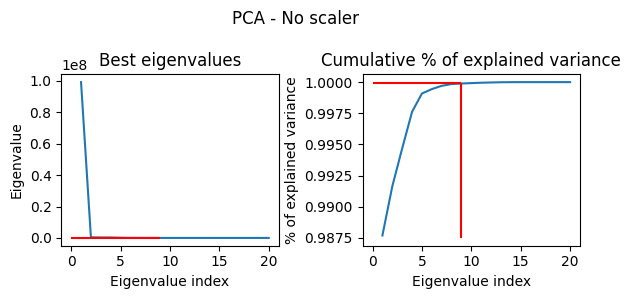

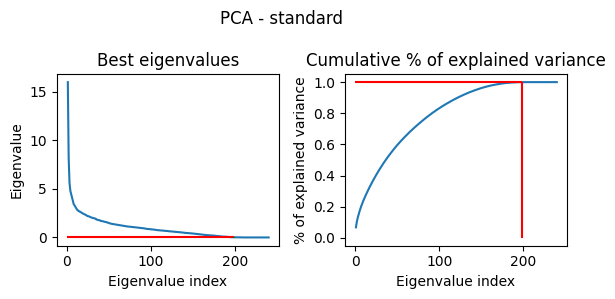

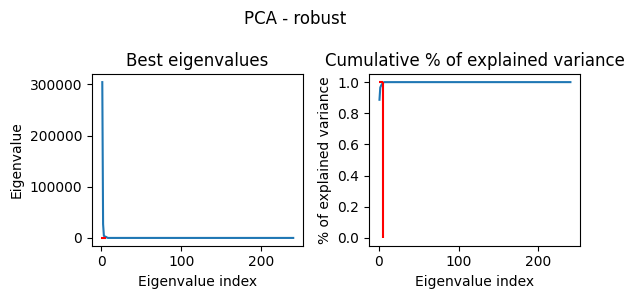

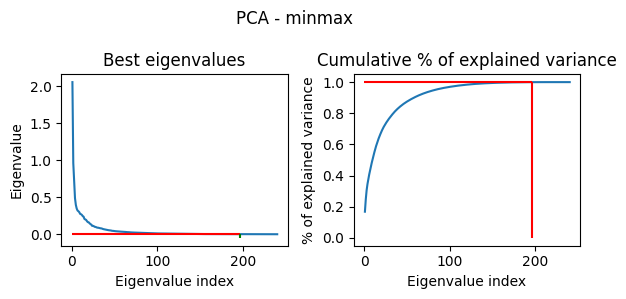

Results:
no-scaler - min eigenvalues to explain 99.99% of variance: 9
standard  - min eigenvalues to explain 99.99% of variance: 199
robust    - min eigenvalues to explain 99.99% of variance: 6
minmax    - min eigenvalues to explain 99.99% of variance: 196


In [37]:
def best_pca_scaler(dataset_standard, dataset_robust, dataset_minmax):
    scaled_dataset = [dataset_standard, dataset_robust, dataset_minmax]
    scaled_dataset_names = ["standard", "robust", "minmax"]
    res_dict = {}
    target_explained_variance = 99.99
    # non scaled
    _,_, pca = pca_reduction(dataset_standard.X_train, dataset_standard.y_train, dataset_standard.X_test, n_components=20)
    auto_df, variance_df = get_pca_eigen_things(pca)
    nonscaled_auto_n = pca_plots(auto_df, variance_df, "PCA - No scaler", target_explained_variance, ymin_a=-0.05, ymin_v=0.9875)
    res_dict["no-scaler"] = nonscaled_auto_n
    # scaled
    for i, ds in enumerate(scaled_dataset):
        _,_, pca = pca_reduction(ds.X_train_normalized, ds.y_train, ds.X_test, n_components=240)
        auto_df, variance_df = get_pca_eigen_things(pca)
        dataset_name = scaled_dataset_names[i]
        scaled_auto_n = pca_plots(auto_df, variance_df, f"PCA - {dataset_name}", target_explained_variance, ymin_a=-0.05)
        res_dict[dataset_name] = scaled_auto_n
    
    print("Results:")
    for k,v in res_dict.items():
        print(f"{k:10}- min eigenvalues to explain {target_explained_variance}% of variance: {v}")

best_pca_scaler(dataset_standard, dataset_robust, dataset_minmax)

Possiamo concludere che il miglior scaler, almeno in base ai risultati di PCA, è il robust scaler. Anche il dataset senza scaler fornisce dei buoni risultati.

In [38]:
initial_features = X_train.shape[1] # 240
pca_features = 9
robust_pca_features = 6

# 6. Valutazione modelli
Dopo aver preparato i dati, eseguito il preprocessing, implementato diversi modelli e applicato tecniche come la feature selection e la riduzione della dimensionalità con PCA, è arrivato il momento di valutare l'efficacia dei nostri modelli. La **valutazione dei modelli** è una fase fondamentale di ogni progetto di machine learning, in quanto ci permette di misurare le prestazioni dei nostri algoritmi e comprendere la loro capacità di generalizzazione.

Ci concentreremo sulla valutazione dei modelli di regressione utilizzati per predire i prezzi delle case. Esploreremo diverse metriche di valutazione comuni utilizzate in questo contesto e analizzeremo i risultati ottenuti dai nostri modelli. In particolare, ci concentreremo su due metriche fondamentali: l'**errore quadratico medio** (RMSE) e il **coefficiente di determinazione** (R²).

L'**errore quadratico medio** (RMSE) è una misura della discrepanza tra i valori predetti dal modello e i valori effettivi nel nostro set di dati. Un valore di RMSE più basso indica una migliore aderenza del modello ai dati osservati. Questa metrica ci permetterà di valutare la bontà di adattamento del nostro modello e confrontarlo con altri modelli implementati.

Il **coefficiente di determinazione** (R²) ci fornisce una stima dell'adattabilità del nostro modello rispetto alla variazione dei dati. Un valore di R² più vicino a 1 indica una maggiore capacità del modello di spiegare la variazione nei dati. Questa metrica ci aiuterà a valutare l'efficacia generale del nostro modello nella predizione dei prezzi delle case.

Oltre alle metriche di valutazione, esploreremo anche altre tecniche di valutazione come la **cross-validazione** e il **valore dei residui**. La **cross-validazione** ci consente di valutare le prestazioni del modello su più partizioni del nostro set di dati, fornendo una stima più affidabile delle sue capacità di generalizzazione. Il **valore dei residui** è una misura dell'errore o della discrepanza tra i valori predetti dal modello e i valori effettivi nel set di dati e rappresentano la differenza tra il valore osservato e il valore predetto per ciascuna osservazione nel set di dati.

In conclusione, la valutazione dei modelli ci fornirà una panoramica completa delle prestazioni dei nostri modelli di regressione aiutandoci a comprendere quale modello è il più adatto per il nostro problema e come possiamo migliorare ulteriormente le prestazioni del nostro sistema di predizione dei prezzi delle case.


Definiamo una classe che mantiene i parametri migliori di un modello:

In [39]:
from typing import Optional, Set


class BestParameters:
    def __init__(self, model: str, k_feature: int, parameters: Dict[str, float], r2: float, rms: float, preds: Series):
        self.model = model
        self.k_feature = k_feature
        self.other = parameters
        self.r2 = r2
        self.rms = rms
        self.preds = preds

    def print_parameters(self):
        if self.other is not None:
            string = f"{self.model} - features: {self.k_feature} test r2: {self.r2} test rms: {self.rms} (hyper)parameters: {self.other}"
        else:
            string = f"{self.model} - features: {self.k_feature} test r2: {self.r2} test rms: {self.rms}"
        print(string)
    
    def get_predictions(self):
        return self.preds

class AllModelBestParameter:
    def __init__(self):
        self.parameters: Set[BestParameters]= set()

    # aggiunge un modello all'insieme dei modelli che stiamo analizzando
    def add(self, model_parameters: BestParameters):
        self.parameters.add(model_parameters)

    def add_all(self, other_models):
        other_models: AllModelBestParameter = other_models
        self.parameters.union(other_models.parameters)

    
    # determina il miglior modello tra quelli aggiunti
    def best_model(self, return_params=False) -> Optional[BestParameters]:
        best_r2 = 0.0
        best_params = None
        for p in self.parameters:
            if p.r2 > best_r2:
                best_r2 = p.r2
                best_params = p
        print(f"The best model of {len(self.parameters)} analyzed is:")
        best_params.print_parameters()
        if return_params:
            return best_params
        else:
            return None
    # stampa tutti i modelli
    def print_models(self):
        for m in self.parameters:
            m.print_parameters()

Definiamo:
- una funzione che applica la feature selection al dataset;
- una funzione che applica la pca al dataset;
- una funzione che applica sia la feature selection che pca al dataset;
- una funzione che applica sia la cross validation sul training set e la valutazione sul testing set, dopo aver applicato feature selection e/o pca.

In [40]:
def apply_fs_and_pca(dataset: Dataset, k_fs, k_pca, scaled=False, logs=True) -> Tuple[DataFrame, DataFrame]:
    X_train = dataset.X_train.copy() if not scaled else dataset.X_train_normalized.copy()
    X_test = dataset.X_test.copy() if not scaled else dataset.X_test_normalized.copy()

    # Eseguo una feature selection
    X_train_fs, X_test_fs = mutual_info_feature_selection_train_test(X_train, dataset.y_train.copy(), X_test, k_fs)
    if logs:
        print("Feature selezionate: ", X_train_fs.shape)

    # Applico la riduzione PCA dopo la feature selection
    X_train_fs_pca, X_test_fs_pca, _ = pca_reduction(X_train_fs, dataset.y_train, X_test_fs, k_pca)
    if logs:
        print(f"Feature ridotte da {X_train.shape[1]} con MI e PCA: {X_train_fs_pca.shape[1]}")
    return X_train_fs_pca, X_test_fs_pca


def apply_pca(dataset: Dataset, k_pca, scaled=False, logs=True) -> Tuple[DataFrame, DataFrame]:
    X_train = dataset.X_train.copy() if not scaled else dataset.X_train_normalized.copy()
    X_test = dataset.X_test.copy() if not scaled else dataset.X_test_normalized.copy()
    X_train_pca, X_test_pca, _ = pca_reduction(X_train, dataset.y_train.copy(), X_test, n_components=k_pca)
    if logs:
        print(f"Feature ridotte da {X_train.shape[1]} con PCA: {X_train_pca.shape[1]}")
    return X_train_pca, X_test_pca


def apply_fs(dataset: Dataset, k_fs, scaled=False, logs=True) -> Tuple[DataFrame, DataFrame]:
    X_train = dataset.X_train.copy() if not scaled else dataset.X_train_normalized.copy()
    X_test = dataset.X_test.copy() if not scaled else dataset.X_test_normalized.copy()

    # Eseguo una feature selection
    X_train_fs, X_test_fs = mutual_info_feature_selection_train_test(X_train, dataset.y_train.copy(), X_test, k_fs)
    if logs:
        print("Feature selezionate: ", X_train_fs.shape[1])
    return X_train_fs, X_test_fs


def apply_fs_and_or_pca(dataset: Dataset, k_fs, k_pca, scaled=False) -> Tuple[
    DataFrame, DataFrame, DataFrame, DataFrame]:
    """Applica FS e PCA oppure solo PCA."""
    X_train_pca, X_test_pca = apply_pca(dataset, k_pca, scaled=scaled)
    X_train_fs_pca, X_test_fs_pca = apply_fs_and_pca(dataset, k_fs=k_fs, k_pca=k_pca, scaled=scaled)
    return X_train_pca, X_test_pca, X_train_fs_pca, X_test_fs_pca

Di seguito, definiamo:
- una funzione che esegue una **cross validation sul training set**, restituendo $R^2$ e $E_{rms}$ per il training set; useremo questa funzione per i modelli semplici come la regressione lineare.
- una funzione con **GridSearch** che permette di trovare i migliori parametri di un modello. Useremo questa funzione per i modelli con diversi parametri, per trovarne la combinazione migliore
- una funzione per valutare le **prestazioni sul testing set**; utilizzeremo questa funzione per tutti i modelli, valutando le performance del miglior modello trovato finora;
- una funzione **RandomizedSearch** è una tecnica di ricerca dei parametri che viene utilizzata per trovare la combinazione ottimale di parametri per un modello di apprendimento automatico. A differenza della ricerca dei parametri convenzionale (GridSearchCV), che esamina tutte le possibili combinazioni di parametri specificate, RandomizedSearchCV esegue una ricerca casuale selezionando casualmente un sottoinsieme di combinazioni di parametri per l'addestramento e la valutazione del modello.

In [74]:
from typing_extensions import deprecated
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# tipo alias per i modelli
Model = LinearRegression | Lasso | Ridge | ElasticNet | SVR | KNeighborsRegressor | DecisionTreeRegressor | RandomForestRegressor


def _performance_cross_validation(model: Model, x_train: DataFrame, y_train: Series) -> Tuple[float, float]:
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=("r2", "neg_root_mean_squared_error"),
                            return_train_score=True)
    # r2_train = scores['train_r2'].mean()
    r2_validation_set = scores['test_r2'].mean()
    # rms_train = - scores['train_neg_root_mean_squared_error'].mean()
    rms_validation_set = - scores['test_neg_root_mean_squared_error'].mean()
    return r2_validation_set, rms_validation_set


def performance_cross_validation(model: Model, dataset: Dataset, x_train_new=None, scaled=False) -> Tuple[float, float]:
    """Esegue la cross validation del modello già istanziato (ma non fittato) sull'intero training set
    Se x_train_new non è None, scaled viene ignorato.
    returns: (r2, rms) """
    if x_train_new is not None:
        return _performance_cross_validation(model, x_train_new, dataset.y_train)
    if scaled:
        return _performance_cross_validation(model, dataset.X_train_normalized, dataset.y_train)
    else:
        return _performance_cross_validation(model, dataset.X_train, dataset.y_train)


def _performance_train(model: Model, x_train: DataFrame, y_train: Series) -> Tuple[float, float, Any]:
    """Addestra il modello sul train ed esegue la predizione su train. 
        Questo può essere utile come confronto col testing set, 
        per verificare che non ci sia overfitting o underfitting """
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)  # Attenzione, qui stiamo usando il train!!!
    r2 = r2_score(y_true=y_train, y_pred=y_pred)
    rms = np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred))
    return r2, rms, y_pred


def performance_train(model: Model, dataset: Dataset, x_train_new=None, x_test_new=None, scaled=False) -> Tuple[
    float, float, Any]:
    if x_train_new is not None and x_test_new is not None:
        return _performance_train(model, x_train_new, dataset.y_train)
    if scaled:
        return _performance_train(model, dataset.X_train_normalized, dataset.y_train)
    else:
        return _performance_train(model, dataset.X_train, dataset.y_train)

from skfda.misc.hat_matrix import (
    KNeighborsHatMatrix,
    LocalLinearRegressionHatMatrix,
    NadarayaWatsonHatMatrix,
)
from skfda.ml.regression._kernel_regression import KernelRegression

def _performance_test(model: Model, x_train: DataFrame, x_test: DataFrame, y_train: Series, y_test: Series) -> Tuple[
    float, float, float, float, Any]:
    """Addestra il modello sul training set e poi eseguiamo la predizione su test set."""

    if isinstance(model, KernelRegression):
        x_train = x_train.to_numpy()
        y_train = y_train.to_numpy()
        x_test = x_test.to_numpy()
        y_test = y_test.to_numpy()
    model.fit(x_train, y_train)  # necessario fittare il model
    y_pred_train = model.predict(x_train)
    y_pred = model.predict(x_test)
    r2_train = r2_score(y_true=y_train, y_pred=y_pred_train)
    rms_train = np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    rms = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
    return r2_train, rms_train, r2, rms, y_pred

@deprecated
def performance_test(model: Model, dataset: Dataset, x_train_new=None, x_test_new=None, scaled=False) -> Tuple[
    float, float, float, float, Any]:
    """Esegue il fit del modello già istanziato (ma non fittato) sull'intero training set e 
    poi predice sul testing set, valutandone r2 e rms.
    returns: (r2, rms) """
    if x_train_new is not None and x_test_new is not None:
        return _performance_test(model, x_train_new, x_test_new, dataset.y_train, dataset.y_test)
    elif (x_train_new is not None and x_test_new is None) or (x_train_new is None and x_test_new is not None):
        raise "Impossibile eseguire performance_test senza entrambi i parametri x_train_new e x_test_new. O li passi entrambi o nessuno dei due."
    if scaled:
        return _performance_test(model, dataset.X_train_normalized, dataset.X_test_normalized, dataset.y_train,
                                 dataset.y_test)
    else:
        return _performance_test(model, dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test)


from enum import Enum
class FeatureReduction(Enum):
    FS = 0
    PCA = 1
    FS_PCA = 2
    Nothing = 3

def get_k_fs_with_pca(max_features, k_pca):
    if k_pca is None:
        return 0

    if k_pca < 100:
        k_fs_with_pca = 100
    elif k_pca <= 200:
        k_fs_with_pca = k_pca + 40
    else:
        k_fs_with_pca = max_features
    return k_fs_with_pca

def get_specific_train_test(dataset: Dataset, feature_reduction: FeatureReduction, scaled: bool, k_fs=40, k_pca=40, logs=False) -> Tuple[DataFrame, DataFrame, int]:
    # definisco il k_fs base quando si esegue sia FS che PCA, ma non si specifica k_fs abbastanza grande
    k_fs_with_pca = get_k_fs_with_pca(dataset.X_train.shape[1], k_pca)
    
    features = None
    match feature_reduction:
        case FeatureReduction.FS:
            x_train, x_test = apply_fs(dataset, k_fs, scaled=scaled, logs=logs)
            features = k_fs
        case FeatureReduction.PCA:
            x_train, x_test = apply_pca(dataset, k_pca, scaled=scaled, logs=logs)
            features = k_pca
        case FeatureReduction.FS_PCA:
            x_train, x_test = apply_fs_and_pca(dataset, k_fs=k_fs_with_pca, k_pca=k_pca, scaled=scaled, logs=logs)
            features = k_pca
        case FeatureReduction.Nothing:
            x_train = dataset.X_train_normalized.copy() if scaled else dataset.X_train.copy()
            x_test = dataset.X_test_normalized.copy() if scaled else dataset.X_test.copy()
            features = dataset.X_train.shape[1]
    return x_train, x_test, features


def performance_test_ext(model: Model, dataset: Dataset, feature_reduction: FeatureReduction, scaled=False, k_fs=40, k_pca=None,  logs=True)-> Tuple[float, float, float, float, Any, int]:
    """
    Applica PCA/FS/nulla e poi esegue l'addestramento sul training e la predizione sul testing
    Restituisce r2_train, rms_train, r2_test, rms_test, y_pred, features
    """
    if k_pca is None:
        k_pca = pca_features if not scaled else robust_pca_features #6 con robust scaler, 9 senza.
    x_train, x_test, features = get_specific_train_test(dataset, feature_reduction, scaled, k_fs, k_pca, logs)
    r2_train, rms_train, r2_test, rms_test, y_pred = _performance_test(model, x_train, x_test, dataset.y_train, dataset.y_test)
    return r2_train, rms_train, r2_test, rms_test, y_pred, features

def raw_performance_test(model: Model, x_train: DataFrame, x_test: DataFrame, y_train: Series, y_test: Series)-> Tuple[float, float, float, float, Any, int]:
    """
    Esegue l'addestramento sul training e la predizione sul testing
    Utilizzare questa funzione, per evitare di rieseguire a ogni iterazione FS / PCA
    Restituisce r2_train, rms_train, r2_test, rms_test, y_pred, features
    """
    r2_train, rms_train, r2_test, rms_test, y_pred = _performance_test(model, x_train, x_test, y_train, y_test)
    return r2_train, rms_train, r2_test, rms_test, y_pred, x_train.shape[1]

def get_precomputed_dataset_key(scaled: bool, fs_reduct_name: str, k_fs: int, k_pca: int, fold=None):
    if fold == None:
        return f"scaling:{scaled}-{fs_reduct_name}-kfs:{k_fs}-kpca:{k_pca}"
    else:
        return f"fold:{fold}-scaling:{scaled}-{fs_reduct_name}-kfs:{k_fs}-kpca:{k_pca}"

def precompute_datasets(dataset: Dataset, constant_k_fs: int, constant_k_pca: int, folds: List[Fold]=None)-> Dict[str, Tuple[DataFrame, DataFrame]]:
    res_dict = {}
    scaling = [False, True]
    fs_reduct_types = [FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    print("precomputing datasets...")
    curr_iter = 0
    tot_iter = len(scaling) * len(fs_reduct_types)
    if folds is not None:
        tot_iter *= len(folds)
    for scaled in scaling:
        for fs_reduct in fs_reduct_types:
            if folds is None:
                x_train, x_test, _ = get_specific_train_test(dataset, fs_reduct, scaled, constant_k_fs, constant_k_pca)
                key = get_precomputed_dataset_key(scaled,fs_reduct.name, constant_k_fs, constant_k_pca)
                res_dict[key] = (x_train, x_test)
                curr_iter += 1
                print(f"{curr_iter}/{tot_iter}", end='\r')
            else:
                for i, f in enumerate(folds):
                    fold_dataset = Dataset(f.X_train.copy(), f.y_train.copy(), f.X_test.copy(), f.y_test.copy())
                    x_train, x_test, _ = get_specific_train_test(fold_dataset, fs_reduct, scaled, constant_k_fs, constant_k_pca)
                    key = get_precomputed_dataset_key(scaled,fs_reduct.name, constant_k_fs, constant_k_pca, fold=i)
                    res_dict[key] = (x_train, x_test)
                    curr_iter += 1
                    print(f"{curr_iter}/{tot_iter}", end='\r')

    print(f"precomputed {tot_iter} datasets")
    return res_dict

def _grid_search(model: Model, x_train: DataFrame, y_train: Series, param_grid: Dict):
    # max_features = int(dataset.X_train.shape[1] / 2)
    grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=10, n_jobs=-1 )# massively parallel ahha!
    grid_search.fit(x_train, y_train)

    return grid_search.best_score_, grid_search.best_params_


def grid_search(model: Model, dataset: Dataset, param_grid: Dict, scaled=True):
    if scaled:
        return _grid_search(model, dataset.X_train_normalized, dataset.y_train, param_grid)
    else:
        return _grid_search(model, dataset.X_train, dataset.y_train, param_grid)

def raw_grid_search(model: Model, x_train: DataFrame, y_train: Series, param_grid: Dict):
    """Esegue la cross validation sul training set per ottenere i migliori parametri, 
    e utilizza i dataset già ridotti con FS / PCA"""
    _, best_params = _grid_search(model, x_train, y_train, param_grid)
    return best_params

# def raw_performance_test(model: Model, x_train: DataFrame, x_test: DataFrame, y_train: Series, y_test: Series)-> Tuple[float, float, float, float, Any, int]:
    """
    Esegue l'addestramento sul training e la predizione sul testing
    Utilizzare questa funzione, per evitare di rieseguire a ogni iterazione FS / PCA
    Restituisce r2_train, rms_train, r2_test, rms_test, y_pred, features
    """
#    r2_train, rms_train, r2_test, rms_test, y_pred = _performance_test(model, x_train, x_test, y_train, y_test)
#    return r2_train, rms_train, r2_test, rms_test, y_pred, x_train.shape[1]

def _randomized_searchcv(model: Model, x_train: DataFrame, y_train: Series, params):
    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=10, cv=10)
    random_search.fit(x_train, dataset.y_train)
    return random_search.best_score_, random_search.best_params_


def randomized_searchcv(model: Model, dataset: Dataset, param_grid: Dict, scaled=True):
    if scaled:
        return _randomized_searchcv(model, dataset.X_train_normalized, dataset.y_train, param_grid)
    else:
        return _randomized_searchcv(model, dataset.X_train, dataset.y_train, param_grid)


def run_regression_train_test(msg, model: LinearRegression, dataset, X_train_pca, X_test_pca, scaled=True):
    """Esegue addestramento sul train, predice sul train e sul test, stampando i risultati delle metriche e poi restituisce i valori di r2 e rms ottenuti su test"""
    r2_cv_poly_reg_d2, rms_cv_poly_reg_d2, r2_cv_poly_reg_d2_test, rms_cv_poly_reg_d2_test, y_pred = performance_test(
        model, dataset, x_train_new=X_train_pca,
        x_test_new=X_test_pca, scaled=scaled)
    print(f"{msg} - r2: {r2_cv_poly_reg_d2} - rms: {rms_cv_poly_reg_d2} - r2 test: {r2_cv_poly_reg_d2_test} - rms test: {rms_cv_poly_reg_d2_test}")
    return r2_cv_poly_reg_d2_test, rms_cv_poly_reg_d2_test, y_pred

Infine, definiamo:
  - una funzione che visualizzi gli score in un plot;
  - una funzione che visualizzi i residui, o **residual plot**.

In [65]:
def simple_plot_scores(x, y, label, title):
    sns.lineplot(x=x, y=y, marker='s', markersize=3.5, linewidth=1, label=label).set_title(title)


def residual_plot(y_pred: Series, y_test: Series, title: str):
    """E' un grafico che mostra la differenza tra i valori previsti dal modello e i valori reali del dataset di test. In questo modo è possibile verificare se il modello ha una buona capacità predittiva e se ci sono eventuali pattern nei dati che non sono stati catturati dal modello"""
    mm = min(y_pred)
    mx = max(y_pred)
    fig = plt.figure(figsize=(9, 4))
    fig.gca()

    if isinstance(y_pred, np.ndarray):
        y_pred = pd.Series(y_pred)
        y_test = pd.Series(y_test)

    residuals = y_pred.reset_index(drop=True) - y_test.reset_index(drop=True)
    plt.scatter(y_pred, residuals, c='xkcd:goldenrod', edgecolor='white', label='Train')
    plt.xlabel(r'Valori predetti ($y_i$)')
    plt.ylabel(r'Residui ($y_i-t_i$)')
    plt.hlines(y=0, xmin=(int(mm) / 10) * 10, xmax=(int(mx) / 10) * 10 + 10, color='xkcd:sea blue', lw=2)
    plt.tight_layout()
    plt.title('Grafico dei Residui - ' + title)
    plt.show()

def best_residual_plot(all_models: AllModelBestParameter):
    best_params = all_models.best_model(return_params=True)
    best_y_pred = best_params.get_predictions()
    residual_plot(best_y_pred, dataset.y_test, best_params.model)


## 6.1 Regressione Lineare
L'obiettivo della **regressione lineare** è quello di trovare il miglior iperpiano lineare che rappresenti la relazione tra le feature e il target. Questo iperpiano viene poi utilizzato per prevedere o stimare il valore del target dato un nuovo vettore di features.

La regressione lineare consiste nel fare una **combinazione lineare** delle feature di input $\bold{x}$ con i parametri che definiscono l'iperpiano:

$$y(\bold{x},\bold{w})=w_0+w_1x_1+...+w_dx_d = \sum_{j=0}^d w_j\bar{x}_j=\bold{w}^T \bold{\bar{x}}$$

con $\bold{\bar{x}}=(1,x_1,...,x_n)$.

Per ricavare i migliori coefficienti della regressione lineare, viene utilizzato il metodo dei minimi quadrati, che consiste nel minimizzare la somma delle funzioni Loss quadratica. La funzione **Loss quadratica** è la seguente:

$$ L(\bold{w}, \bold{x}_i,t_i) = (y(x_i,\bold{w}) - t_i)^2$$

La **somma dei minimi quadrati** è data da:

$$ E(\bold{w}) = \frac{1}{2} \sum_{i=1}^n L(\bold{w}, \bold{x}_i,t_i) $$

Esiste una formula in forma chiusa che fornisce la soluzione al metodo dei quadrati, ovvero i coefficienti migliori per la retta di regressione (senza considerare le funzioni base):

$$ \bold{w}^* = (X^TX)^{-1}X^T\bold{t}$$

È importante notare che la regressione lineare assume che esista una relazione lineare tra le variabili coinvolte, ma ciò potrebbe non essere sufficiente per rappresentare in modo appropriato il nostro dataset.

### 6.1.1 Performance regressione lineare

Valutiamo le perfomance sul testing set:

precomputing datasets...


precomputed 8 datasets
Linear Regression with Nothing (240 features) with no scaling -> r2 train: 0.9205838944915007, rms train: 22804.683066512825, r2 mean: 0.8527010493857798 - rms mean: 28032.25172585039 
Linear Regression with FS (40 features) with no scaling -> r2 train: 0.8166359461141212, rms train: 34651.88376561268, r2 mean: 0.8506641829571697 - rms mean: 28225.4028517584 
Linear Regression with PCA (40 features) with no scaling -> r2 train: 0.8295370424968279, rms train: 33410.637127118425, r2 mean: 0.8672681165865033 - rms mean: 26610.055872869154 
Linear Regression with FS_PCA (40 features) with no scaling -> r2 train: 0.8289206692227014, rms train: 33470.98701735548, r2 mean: 0.8588362503889674 - rms mean: 27442.2521700359 
Linear Regression with Nothing (240 features) with robust scaling -> r2 train: 0.9205838944915006, rms train: 22804.68306651283, r2 mean: 0.8527010493858302 - rms mean: 28032.251725845596 
Linear Regression with FS (40 features) with robust scaling -> r

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

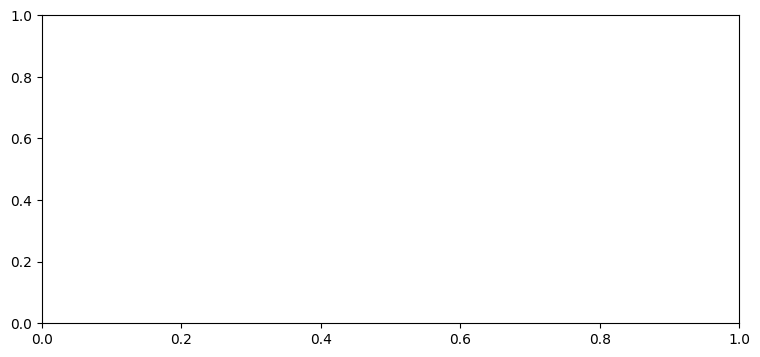

In [43]:
def performance_linear_regression(dataset: Dataset) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [False, True]
    k_fs = 40
    k_pca = 40
    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)
    for scaled in scaling:
        for fs_reduct in fs_reduct_types:
            x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
            r2_train, rms_train, r2_test, rms_test, y_pred, features= raw_performance_test(LinearRegression(), x_train, x_test, dataset.y_train, dataset.y_test)
            # r2_train, rms_train, r2_linear_regression, rms_linear_regression, y_pred, features= performance_test_ext(LinearRegression(), dataset, fs_reduct, scaled=scaled, k_pca=k_pca, k_fs=k_fs, logs=False)       
            scaled_str = "robust" if scaled else "no"
            description = f"Linear Regression with {fs_reduct.name} ({features} features) with {scaled_str} scaling"
            print(f"{description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
            res_linear_regression = BestParameters(description, features, None, r2_test, rms_test, y_pred)
            
            all_models.add(res_linear_regression)
    return all_models

all_models = AllModelBestParameter()
all_models_lin_regr = performance_linear_regression(dataset)
best_residual_plot(all_models_lin_regr)
all_models.add_all(all_models_lin_regr)

## 6.2 Regressione Polinomiale
La **regressione polinomiale** è una tecnica di modellazione che estende la semplice regressione lineare introducendo termini polinomiali come variabili esplicative. Questo tipo di regressione è utile quando la relazione tra la variabile di input (o le variabili) e la variabile di output non è lineare, ma può essere approssimata in modo più accurato da una funzione polinomiale.
L'ordine o il grado polinomiale dipende dalla complessità della relazione che si desidera modellare. Un ordine più alto può fornire una migliore adattabilità ai dati, ma può anche aumentare il rischio di overfitting. Pertanto, è importante trovare un equilibrio tra la complessità del modello e la sua capacità di generalizzare su nuovi dati.

Per applicare la regressione polinomiale, occorre definire $m$ funzioni base polinomiali $\phi_j(\bold{x})=x^j$ con cui trasformare il dataset e successivamente applicare il modello LinearRegression. Il grado massimo del polinomio è $m-1$. L'obiettivo della regressione polinomiale è trovare il miglior grado del polinomio che massimizza $R^2$.

In [111]:
from sklearn.preprocessing import PolynomialFeatures


def polynomial_transformation(x_train: DataFrame, x_test: DataFrame, d=2, only_interactions=False) -> Tuple[
    DataFrame, DataFrame]:
    """
    Trasforma il dataset di training e testing di partenza con n feature a dei dataset con m >> n feature.
    Ad esempio con 4 feature un polinomio di grado 2 produrrebbe 15 features:
    1, x1, x2, x3, x4, x1x2, x1x3, x1x4, x2x3, x2x4, x3x4, x1^2, x2^2, x3^2, x4^2
    d: grado del polinomio di regressione
    only_interactions: non mette le potenze ma solo le coppie (o tuple di dimensione massima d) di features
    returns: training set trasformato e testing set trasformato
    """
    # include_bias=False significa che non si forza l'intercetta y=0
    poly = PolynomialFeatures(degree=d, include_bias=False, interaction_only=only_interactions)
    # usiamo le funzioni base per trasformare il dataset (in questo caso aumenta d*(d-1)/2 il numero di features)
    x_train_poly = poly.fit_transform(x_train)
    # print(f"old train shape = {x_train.shape}, new train shape = {x_train_poly.shape}")
    x_test_poly = poly.transform(x_test)
    # print(f"old test shape = {x_test.shape}, new test shape = {x_test_poly.shape}")
    return pd.DataFrame(x_train_poly), pd.DataFrame(x_test_poly)


Il numero di feature ottenute è proporzionale al coefficiente binomiale delle feature iniziali e del grado del polinomio:

In [114]:
from scipy.special import binom

deg = 2
new_features = binom(240, deg)
print(f"Con 240 features, il polinomio di regressione di grado {deg} avrà {new_features} termini al più")

deg = 2
new_features = binom(40, deg)
print(f"Con 40 features, il polinomio di regressione di grado {deg} avrà {new_features} termini al più")

Con 240 features, il polinomio di regressione di grado 2 avrà 28680.0 termini al più
Con 40 features, il polinomio di regressione di grado 2 avrà 780.0 termini al più


Però poiché le feature iniziali sono 220, anche un polinomio di grado 2 produrrebbe ben 24090 features con PolynomialFeature, che sono decisamente troppe. Per ridurre la dimensionalità a 40 features, usiamo feature selection e PCA.

precomputing datasets...
precomputed 8 datasets
Polynomial Regression degree 1 (only interactions) with Nothing (240 features) with robust scaling -> r2 train: 0.920583892069829, rms train: 22804.683414209634, r2 mean: -693255455.9442909 - rms mean: 1923113012.0928454 
Polynomial Regression degree 1 (only interactions) with FS (40 features) with robust scaling -> r2 train: 0.8201787055344543, rms train: 34315.49814913019, r2 mean: 0.8541793248958205 - rms mean: 27891.232776595425 
Polynomial Regression degree 1 (only interactions) with PCA (40 features) with robust scaling -> r2 train: 0.8219574655785541, rms train: 34145.354965571154, r2 mean: 0.8541792092736354 - rms mean: 27891.2438341654 
Polynomial Regression degree 1 (only interactions) with FS_PCA (40 features) with robust scaling -> r2 train: 0.824801556440852, rms train: 33871.534315504294, r2 mean: 0.849461702113272 - rms mean: 28338.813206806484 
Polynomial Regression degree 1 (only interactions) with Nothing (240 features) 

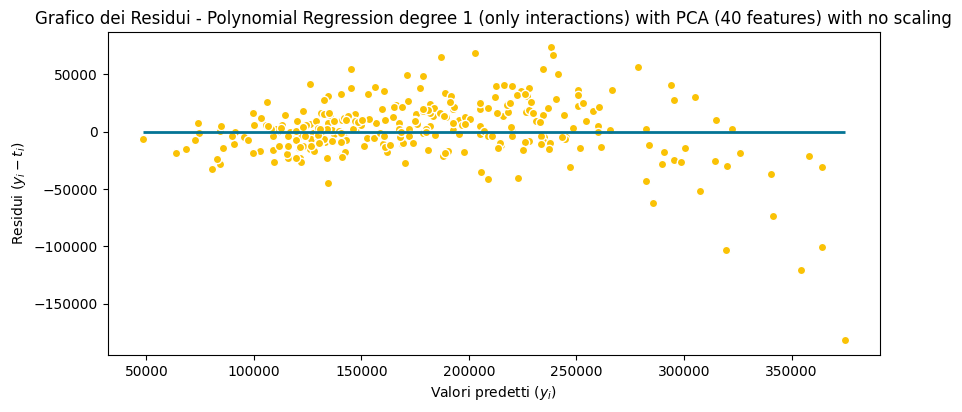

In [112]:
def performance_poly_regression(dataset: Dataset) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [True, False]
    only_interactions = [True, False]
    poly_degrees = [1,2,3]
    k_fs = 40
    k_pca = 40
    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)
    for degree in poly_degrees:
        for interactions in only_interactions: 
            for scaled in scaling:
                for fs_reduct in fs_reduct_types:
                    x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
                    try:
                        x_train_poly, x_test_poly = polynomial_transformation(x_train, x_test, degree, interactions)
                        r2_train, rms_train, r2_test, rms_test, y_pred, features= raw_performance_test(LinearRegression(), x_train_poly, x_test_poly, dataset.y_train, dataset.y_test)
                        
                        description = f"Polynomial Regression degree {degree} {'(only interactions)' if interactions else ''} with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling"
                        print(f"{description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
                        res = BestParameters(description, features, None, r2_test, rms_test, y_pred)
                        
                        all_models.add(res)
                    except MemoryError:
                        print(f"<<< Skipping for insufficient Memory: {description} >>>")
    return all_models


all_models_poly_regr = performance_poly_regression(dataset)
best_residual_plot(all_models_poly_regr)
all_models.add_all(all_models_poly_regr)

### 6.2.2 Regressione polinomiale - Miglior grado
Troviamo il miglior grado del polinomio fissando il numero di feature dei dataset (con FS e PCA).

In [48]:
def best_poly_degree(dataset: Dataset, k_fs=10, k_pca=4, scaled=True):
    all_models = AllModelBestParameter()
    degrees = [1, 2, 3]
    best_r2 = 0.0
    best_rms = 0.0
    best_d = 0
    results = {"d": [], "r2": [], "rms": [], "r2 train": [], "rms train": []}
    fs_reduct = FeatureReduction.FS_PCA
    # fissiamo la miglior combinazione di scaling e pca
    x_train, x_test, _ = get_specific_train_test(dataset, fs_reduct, k_fs=k_fs, k_pca=k_pca, scaled=scaled)

    for d in degrees:
        # qua non possiamo fare grid search perché il grado non è un parametro della linear regression, 
        # ma un iperparametro per trasformare il dataset iniziale
        x_train_poly, x_test_poly = polynomial_transformation(x_train, x_test, d=d)
        r2_train_poly, rms_train_poly, r2_test_poly, rms_test_poly, y_pred, _ = raw_performance_test(LinearRegression(), x_train_poly, x_test_poly, dataset.y_train, dataset.y_test)
        print(f"Polynomial Regression deg {d} -> r2 train = {r2_train_poly} - rms train = {rms_train_poly} --- r2 test = {r2_test_poly} rms test = {rms_test_poly}")
        
        scaled_str = "robust" if scaled else "no"
        only_interactions_str = ""
        description = f"Polynomial Regression degree {d} {only_interactions_str} with {fs_reduct.name} ({k_pca} features) with {scaled_str} scaling"
        res = BestParameters(description, k_pca, None, r2_test_poly, rms_test_poly, y_pred)
                        
        all_models.add(res)
        results["d"].append(d)
        results["r2"].append(r2_test_poly)
        results["rms"].append(rms_test_poly)
        results["r2 train"].append(r2_train_poly)
        results["rms train"].append(rms_train_poly)
        if r2_test_poly > best_r2:
            best_r2 = r2_test_poly
            best_rms = rms_test_poly
            best_d = d
    return best_d, best_r2, best_rms, results, all_models

In [49]:
d, r2, rms, results, all_models = best_poly_degree(dataset, k_fs=10, k_pca=6, scaled=True)
print(f"Best degree for Polynomial regression: {d} - best r2: {r2} - best rms: {rms}")

Polynomial Regression deg 1 -> r2 train = 0.7512498411955391 - rms train = 40360.0254405881 --- r2 test = 0.7729278850210207 rms test = 34804.87356996139
Polynomial Regression deg 2 -> r2 train = 0.8078891719345045 - rms train = 35468.73258443003 --- r2 test = 0.7821897250176344 rms test = 34087.67178927011
Polynomial Regression deg 3 -> r2 train = 0.8844986079033399 - rms train = 27501.941713394543 --- r2 test = -81009599.28459464 rms test = 657395009.110233
Best degree for Polynomial regression: 2 - best r2: 0.7821897250176344 - best rms: 34087.67178927011


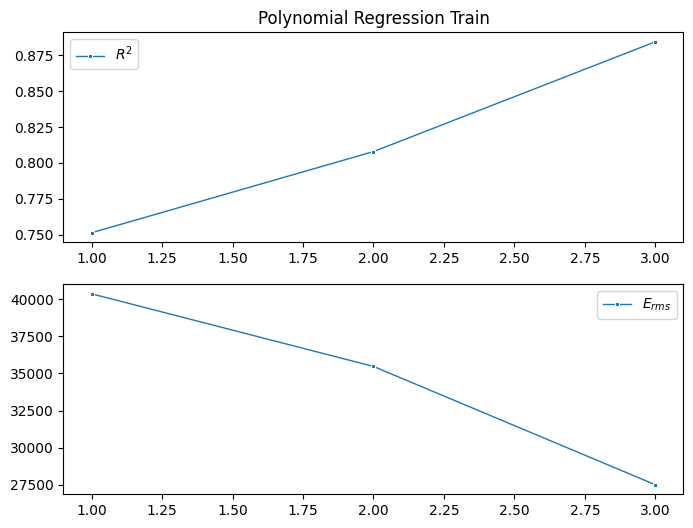

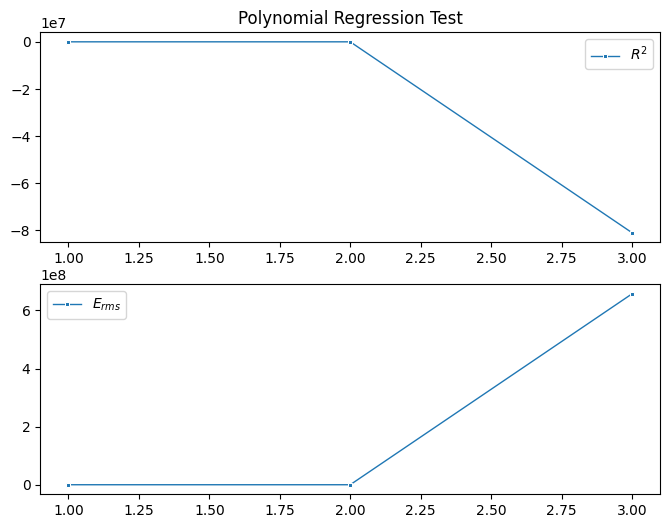

In [50]:
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
simple_plot_scores(x=results["d"], y=results["r2 train"], label="$R^2$", title="Polynomial Regression Train")
plt.subplot(2, 1, 2)
simple_plot_scores(x=results["d"], y=results["rms train"], label="$E_{rms}$", title="")
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
simple_plot_scores(x=results["d"], y=results["r2"], label="$R^2$", title="Polynomial Regression Test")
plt.subplot(2, 1, 2)
simple_plot_scores(x=results["d"], y=results["rms"], label="$E_{rms}$", title="")

Questo conferma che il miglior grado del polinomio per le funzioni base è 1.

## 6.3 Regressione Lasso
La **regressione Lasso** è un metodo di regressione lineare che incorpora una penalizzazione L1 (norma L1) per stimare i coefficienti dei predittori. Questo metodo è utilizzato per la selezione delle caratteristiche e la riduzione della dimensionalità, in quanto tende a produrre coefficienti di regressione sparsi, mettendo a zero i coefficienti meno importanti.

La funzione di costo della regressione Lasso è la Square Loss, mentre la regolarizzazione è data dal valore assoluto. In generale la funzione da minimizzare per Lasso è la seguente:

$$ E(\bold{w})=\frac{1}{2} \sum_{i=1}^n (t_i -\bold{w}^T \bold{x})^2 + \frac{\lambda}{2}\sum_{j=1}^m |w_j|$$

In particolare $\lambda$ è il coefficiente di regolarizzazione, che in scikit-learn corrisponde al valore $\alpha$.


### 6.3.1 Lasso Cross Validation

Usiamo la classe di libreria LassoCV per trovare automaticamente il miglior $\alpha$ per la regressione Lasso:

precomputing datasets...
precomputed 8 datasets
Lasso Regression with Nothing (240 features) with no scaling - best_alpha = 225756.80386755837 -> r2 train: 0.647158121238415, rms train: 48068.4159863049, r2 mean: 0.6691613509257863 - rms mean: 42011.31516775625 
Lasso Regression with FS (40 features) with no scaling - best_alpha = 320004.4365871981 -> r2 train: 0.6400884962151308, rms train: 48547.58290475726, r2 mean: 0.6685179353764646 - rms mean: 42052.14716231371 
Lasso Regression with PCA (40 features) with no scaling - best_alpha = 226628.3824129555 -> r2 train: 0.6485429379402559, rms train: 47973.994955974194, r2 mean: 0.6794957574887912 - rms mean: 41349.95576615669 
Lasso Regression with FS_PCA (40 features) with no scaling - best_alpha = 226630.19086485193 -> r2 train: 0.6453614240432448, rms train: 48190.64456647747, r2 mean: 0.6795739707559537 - rms mean: 41344.91010366706 
Lasso Regression with Nothing (240 features) with robust scaling - best_alpha = 986.4975276552836 ->

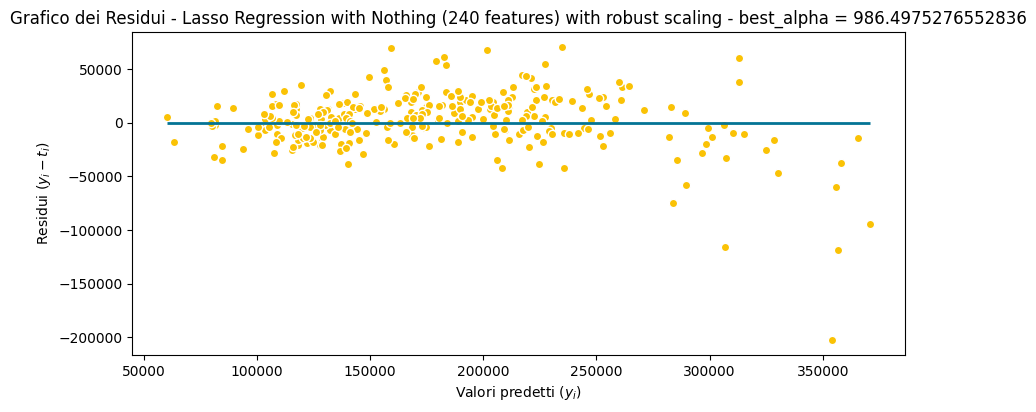

In [109]:
from sklearn.linear_model import LassoCV

def performance_lasso_regression(dataset: Dataset) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [False, True]
    k_fs = 40
    k_pca = 40
    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)
    for scaled in scaling:
        for fs_reduct in fs_reduct_types:
            lasso_cv = LassoCV(cv=5, random_state=42)
            x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
            r2_train, rms_train, r2_test, rms_test, y_pred, features = raw_performance_test(lasso_cv, x_train, x_test, dataset.y_train, dataset.y_test)
            # r2_train, rms_train, r2_linear_regression, rms_linear_regression, y_pred, features= performance_test_ext(lasso_cv, dataset, fs_reduct, scaled=scaled, k_pca=40, k_fs=40, logs=False)       
            scaled_str = "robust" if scaled else "no"
            description = f"Lasso Regression with {fs_reduct.name} ({features} features) with {scaled_str} scaling - best_alpha = {lasso_cv.alpha_}"
            print(f"{description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
            res = BestParameters(description, features, None, r2_test, rms_test, y_pred)
            
            all_models.add(res)
    return all_models

all_models_lasso = performance_lasso_regression(dataset)
best_residual_plot(all_models_lasso)
all_models.add_all(all_models_lasso)

Anche in questo caso la FS e PCA riducono le performance di almeno 10 punti percentuali per l'$R^2$, quindi non sono convenienti.

## 6.4 Regressione Ridge lineare
La **Ridge Regression** è un metodo di regressione lineare che utilizza una funzione costo quadratica (Square Loss) e una regolarizzazione quadratica (anche denominata L2) per stimare i coefficienti della regressione lineare. Questo metodo è utilizzato per affrontare il problema dell'overfitting e stabilizzare le stime dei coefficienti. Quindi, potrebbe essere utile in quanto abbiamo pochi elementi nel dataset (1480). La funzione di costo da minimizzare per la regressione ridge è la seguente:

$$ E(\bold{w})=\frac{1}{2}\sum_{i=1}^n (t_i-\bold{w}^T\bold{x}_i)^2 + \frac{\lambda}{2}\bold{w}^T\bold{w}$$

L'iperparametro $\lambda$ è l'ammontare di regolarizzazione da applicare.

E' anche possibile applicare a ogni elemento 
$\bold{x}$ del dataset delle funzioni base $\bold{\phi(x)}$, ad esempio per ottenere una regressione ridge polinomiale.

Anche per la ridge regressione esiste una soluzione ottima dei parametri $\bold{w}^*$ in forma chiusa:

$$\bold{w}^*=(\lambda I +X^T X)^{-1}X^T \bold{t}$$

### 6.4.1 Ridge: Miglior valore di lambda usando cross validation
Troviamo tramite **RidgeCV** il miglior valore di **lambda**:

precomputing datasets...
precomputed 8 datasets
Ridge Regression with Nothing (240 features) with no scaling - best_alpha = 10.0 -> r2 train: 0.8823978962138039, rms train: 27750.914120359266, r2 mean: 0.8820954106049717 - rms mean: 25079.767903717595 
Ridge Regression with FS (40 features) with no scaling - best_alpha = 10.0 -> r2 train: 0.8164629223777446, rms train: 34668.22880317119, r2 mean: 0.8500229860747609 - rms mean: 28285.933056661353 
Ridge Regression with PCA (40 features) with no scaling - best_alpha = 10.0 -> r2 train: 0.829950335898132, rms train: 33370.109918284325, r2 mean: 0.867033594843918 - rms mean: 26633.553928975532 
Ridge Regression with FS_PCA (40 features) with no scaling - best_alpha = 10.0 -> r2 train: 0.8307595557701399, rms train: 33290.61561654443, r2 mean: 0.8598432728396599 - rms mean: 27344.194326917637 
Ridge Regression with Nothing (240 features) with robust scaling - best_alpha = 10.0 -> r2 train: 0.8823064552659564, rms train: 27761.70081860698, r

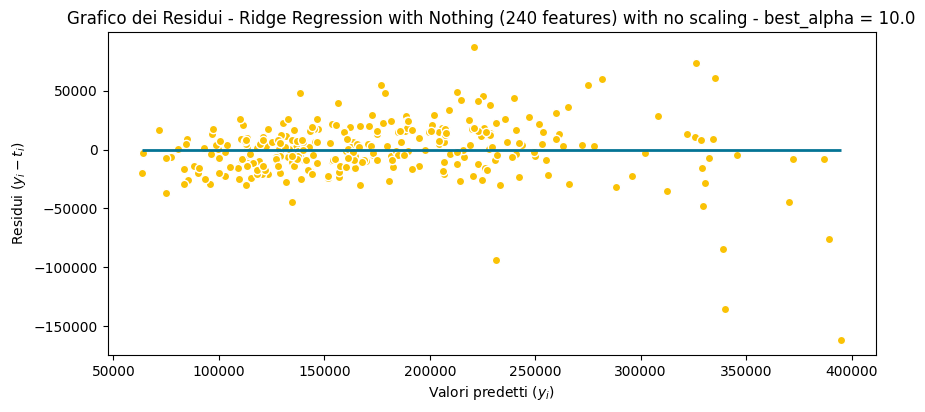

In [108]:
from sklearn.linear_model import RidgeCV
def performance_ridge_regression(dataset: Dataset) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [False, True]
    k_fs = 40 
    k_pca = 40
    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)
    for scaled in scaling:
        for fs_reduct in fs_reduct_types:
            ridge_cv = RidgeCV(cv=5)
            x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
            r2_train, rms_train, r2_test, rms_test, y_pred, features = raw_performance_test(ridge_cv, x_train, x_test, dataset.y_train, dataset.y_test)
            # r2_train, rms_train, r2_linear_regression, rms_linear_regression, y_pred, features= performance_test_ext(ridge_cv, dataset, fs_reduct, scaled=scaled, k_pca=40, k_fs=40, logs=False)       
            description = f"Ridge Regression with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling - best_alpha = {ridge_cv.alpha_}"
            print(f"{description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
            res = BestParameters(description, features, None, r2_test, rms_test, y_pred)
            
            all_models.add(res)
    return all_models

all_models_ridge = performance_ridge_regression(dataset)
best_residual_plot(all_models_ridge)
all_models.add_all(all_models_ridge)

### 6.4.2 Ridge polinomiale, con pca e feature selection
Trasformarmiamo il dataset ridotto con fs e pca con le funzioni base polinomiali e verifichiamo se la regressione ridge polinomiale si comporta meglio rispetto a quella lineare, sempre utilizzando una regolarizzazione ridge.

Polynomial Ridge Regression degree 1 (only interactions) with FS (10 features) with robust scaling - best_alpha: 10.0 -> r2 train: 0.7801829498141237, rms train: 37940.27162323752, r2 mean: 0.8362068612697253 - rms mean: 29560.10760309188 
Polynomial Ridge Regression degree 1 (only interactions) with PCA (6 features) with robust scaling - best_alpha: 10.0 -> r2 train: 0.042636987000107096, rms train: 79178.64592692153, r2 mean: -6.133502527538859e-05 - rms mean: 73041.80153808411 
Polynomial Ridge Regression degree 1 (only interactions) with FS_PCA (6 features) with robust scaling - best_alpha: 10.0 -> r2 train: 0.7530777088377638, rms train: 40211.4651149413, r2 mean: 0.7782212262349848 - rms mean: 34396.80837342783 
Polynomial Ridge Regression degree 1  with FS (10 features) with robust scaling - best_alpha: 10.0 -> r2 train: 0.7801829498141237, rms train: 37940.27162323752, r2 mean: 0.8362068612697253 - rms mean: 29560.10760309188 
Polynomial Ridge Regression degree 1  with PCA (6 f

/home/giaco/PycharmProjects/ProgettoML/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.41213e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Polynomial Ridge Regression degree 3 (only interactions) with FS_PCA (6 features) with robust scaling - best_alpha: 10.0 -> r2 train: 0.8105727622439006, rms train: 35220.130529640825, r2 mean: 0.8007727910016573 - rms mean: 32601.11722848994 
Polynomial Ridge Regression degree 3  with FS (10 features) with robust scaling - best_alpha: 10.0 -> r2 train: 0.8967946657430659, rms train: 25996.8555084979, r2 mean: 0.8755137909381995 - rms mean: 25770.25873040927 
Polynomial Ridge Regression degree 3  with PCA (6 features) with robust scaling - best_alpha: 10.0 -> r2 train: 0.5763532488707178, rms train: 52671.01506782437, r2 mean: -567661702.4678494 - rms mean: 1740215193.346815 


/home/giaco/PycharmProjects/ProgettoML/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.61537e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/giaco/PycharmProjects/ProgettoML/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.47177e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Polynomial Ridge Regression degree 3  with FS_PCA (6 features) with robust scaling - best_alpha: 10.0 -> r2 train: 0.8404311727798057, rms train: 32325.390094940165, r2 mean: -8.339183945726173 - rms mean: 223209.47330337812 
The best model of 18 analyzed is:
Polynomial Ridge Regression degree 2  with FS (10 features) with robust scaling - features: 65 test r2: 0.8885078845295327 test rms: 24388.227407643055


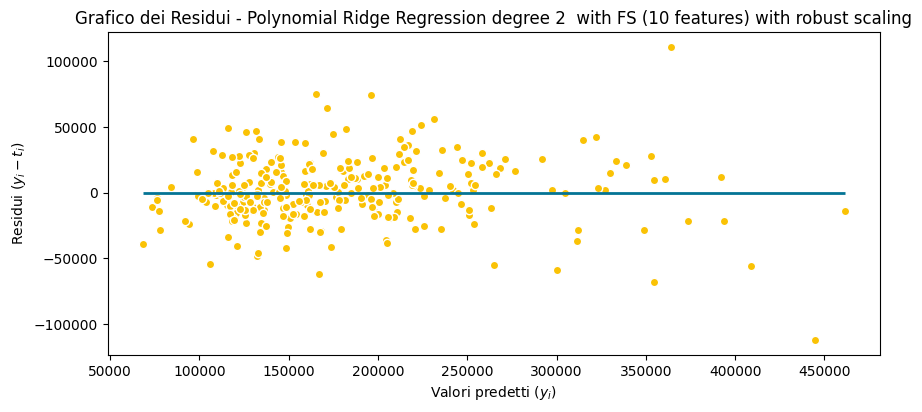

In [53]:
def performance_poly_ridge_regression(dataset: Dataset) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [True]
    only_interactions = [True, False]
    poly_degrees = [1,2,3]
    best_alpha = 10.0
    for degree in poly_degrees:
        for interactions in only_interactions: 
            for scaled in scaling:
                for fs_reduct in fs_reduct_types:
                    ridge_cv = Ridge(alpha=best_alpha, random_state=42)
                    x_train, x_test, features = get_specific_train_test(dataset, fs_reduct, scaled, k_fs=10, k_pca=6 if scaled else 9)
                    scaled_str = "robust" if scaled else "no"
                    only_interactions_str = "(only interactions)" if interactions else ""
                    description = f"Polynomial Ridge Regression degree {degree} {only_interactions_str} with {fs_reduct.name} ({features} features) with {scaled_str} scaling"
                    try:
                        x_train_poly, x_test_poly = polynomial_transformation(x_train, x_test, degree, interactions)
                        r2_train, rms_train, r2_linear_regression, rms_linear_regression, y_pred, features= raw_performance_test(ridge_cv, x_train_poly, x_test_poly, dataset.y_train, dataset.y_test)       
                        
                        print(f"{description} - best_alpha: {best_alpha} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_linear_regression} - rms mean: {rms_linear_regression} ")
                        res = BestParameters(description, features, None, r2_linear_regression, rms_linear_regression, y_pred)
                        
                        all_models.add(res)
                    except MemoryError:
                        print(f"<<< Skipping for insufficient Memory: {description} >>>")
    return all_models


all_models_poly_ridge_regr = performance_poly_ridge_regression(dataset)
best_residual_plot(all_models_poly_ridge_regr)
all_models.add_all(all_models_poly_ridge_regr)

Come miglior risultato si ottiene una regressione ridge lineare e non polinomiale.

## 6.5 Regressione ElasticNET
L'**Elastic-Net** è un metodo di regressione regolarizzato che combina linearmente le due penalità, *L1* e *L2*, dei metodi di regressione Lasso e Ridge.
- *'l1_ratio'*: determina la percentuale della nostra penalità L1 rispetto a $\alpha$. Quindi, per esempio, se $\alpha = 1$ e $L1_{ratio}$ = 0.4, la nostra penalità $L1$ sarà moltiplicata per 0.4 e la nostra penalità $L2$ sarà moltiplicata per $1 - L1_{ratio} = 0.6$

In questo caso abbiamo la regressione ridge se $L1_{ratio} = 0$ e la regressione lasso se $L1_{ratio} = 1$.

La proprietà più importante di Lasso è che produce pesi del modello sparsi, il che significa che i pesi possono essere impostati fino a 0.



### 6.5.1 ElasticNet Cross Validation
Valutiamo tramite **ElasticNetCV** le perfomance con il miglior **alpha** e il miglior **l1-ratio**:

precomputing datasets...
precomputed 8 datasets
ElasticNet Regression with Nothing (240 features) with no scaling - best_alpha = 451513.6077351168-> r2 train: 0.5446903208253263, rms train: 54603.84050012264, r2 mean: 0.5568762158143089 - rms mean: 48620.64192911798 
ElasticNet Regression with FS (40 features) with no scaling - best_alpha = 451513.6077351168-> r2 train: 0.5442547979888817, rms train: 54629.94969169843, r2 mean: 0.5566915218351445 - rms mean: 48630.77341453261 
ElasticNet Regression with PCA (40 features) with no scaling - best_alpha = 453256.76482591016-> r2 train: 0.5451239257361354, rms train: 54577.83387856866, r2 mean: 0.5582817804076192 - rms mean: 48543.46966527493 
ElasticNet Regression with FS_PCA (40 features) with no scaling - best_alpha = 453260.3817306234-> r2 train: 0.5450148168227426, rms train: 54584.37914598832, r2 mean: 0.5579895204665715 - rms mean: 48559.526242742475 
ElasticNet Regression with Nothing (240 features) with robust scaling - best_alpha 

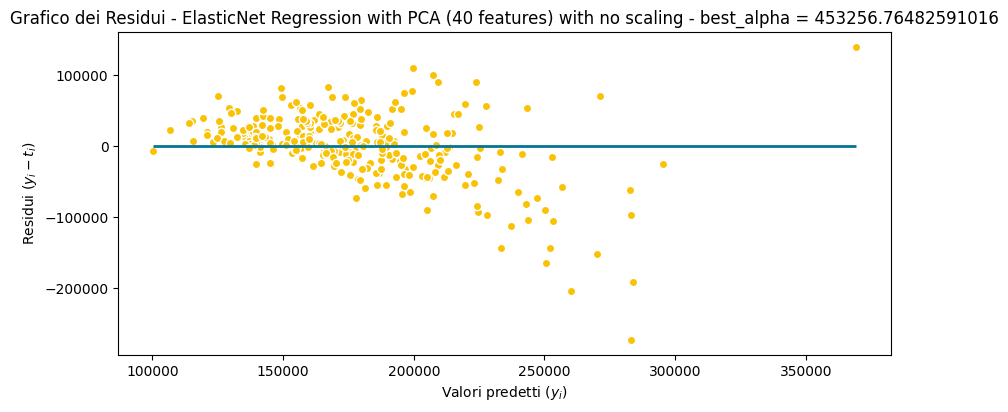

In [107]:
from sklearn.linear_model import ElasticNetCV
def performance_elasticnet_regression(dataset: Dataset) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [False, True]
    k_fs = 40
    k_pca = 40
    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)
    for scaled in scaling:
        for fs_reduct in fs_reduct_types:
            elasticnet_cv = ElasticNetCV(cv=5, random_state=42)
            x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
            r2_train, rms_train, r2_test, rms_test, y_pred, features = raw_performance_test(elasticnet_cv, x_train, x_test, dataset.y_train, dataset.y_test)
            # r2_train, rms_train, r2_linear_regression, rms_linear_regression, y_pred, features= performance_test_ext(elasticnet_cv, dataset, fs_reduct, scaled=scaled, k_pca=k_pca, k_fs=k_fs, logs=False)
            description = f"ElasticNet Regression with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling - best_alpha = {elasticnet_cv.alpha_}"
            print(f"{description}-> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
            res = BestParameters(description, features, None, r2_test, rms_test, y_pred)
            
            all_models.add(res)
    return all_models

all_models_elasticnet = performance_elasticnet_regression(dataset)
best_residual_plot(all_models_elasticnet)
all_models.add_all(all_models_elasticnet)

## 6.6 Regressione SVR

Il **Support Vector Regression** (SVR) è un algoritmo di regressione basato sul concetto di Support Vector Machine (SVM). Mentre l'obiettivo principale di SVM è la classificazione, SVR viene utilizzato per la regressione, ovvero per prevedere un valore numerico continuo anziché una classe di appartenenza.

A differenza dei modelli di regressione lineare tradizionali che cercano di minimizzare gli errori medi quadratici, SVR si basa sul concetto di **massimizzare la "larghezza" di un intervallo**. L'obiettivo di SVR è quello di trovare l'iperpiano che meglio approssima i dati di training nel "tube" specificato. L'iperpiano ottimale viene individuato minimizzando una funzione di costo, che tiene conto sia dell'errore di regressione (la distanza tra i valori predetti e i valori reali) sia della complessità del modello (la larghezza del "tube" e il numero di punti che violano il "tube").

Parametri:
- **Cfloat**: default=1.0. Parametro di regolarizzazione. La forza della regolarizzazione è inversamente proporzionale a C. Deve essere strettamente positivo. La funzione costo è L2.
- **kernel**: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’. Specifica il tipo di funzione kernel da usare nell'algoritmo.
- **degree**: int, default=3. Grado del polinomio se il kernel è polinomiale. Deve essere non negativo. Viene ignorato da gli altri tipi di kernel diversi da 'poly'.
- **gamma**: {‘scale’, ‘auto’} or float, default=’scale’. Coefficiente Kernel per ‘rbf’, ‘poly’ and ‘sigmoid’.
    - se gamma='scale' (default) $ gamma := \frac{1}{(n_{features} \cdot Var(X))} $,
    - se ‘auto’, $gamma := 1 / n_{features}$
    - se float, $gamma \geq 0$.


In [105]:
# classe per mantenere ordinati i parametri di SVR
class SVRParams:
    def __init__(self, C: float, kernel: str, poly_degree: int, gamma: str | float, max_iter: int) -> None:
        self.C = C
        self.kernel = kernel
        self.poly_degree = poly_degree
        self.gamma = gamma
        self.max_iter = max_iter

    def __str__(self) -> str:
        return f"C : {self.C:.2f}, kernel : {self.kernel}, poly_degree : {self.poly_degree}, gamma : {self.gamma:.2f}, max_iter : {self.max_iter}"

    def __repr__(self) -> str:
        return self.__str__()

    def default(self):
        return SVRParams(1, 'rbf', 0, 1, -1)

    def create_svr(self):
        return SVR(C=self.C, kernel=self.kernel, degree=self.poly_degree, gamma=self.gamma, max_iter=self.max_iter,
                   tol=0.01)

    def to_array(self, r2: float, rms: float, r2_test: float, rms_test: float):
        return [self.C, self.kernel, self.poly_degree, self.gamma, self.max_iter, r2, rms, r2_test, rms_test]

    def to_dict(self, r2: float, rms: float):
        return {"C": self.C, "kernel": self.kernel, "degree": self.poly_degree, "gamma": self.gamma,
                "max_iter": self.max_iter, "r2": r2, "rms": rms}


precomputing datasets...
precomputed 8 datasets


/home/giaco/PycharmProjects/ProgettoML/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


1/1 - SVM Regression with Nothing (240 features) with robust scaling - params: C : 1000.00, kernel : linear, poly_degree : 0, gamma : 0.00, max_iter : 10000000 -> r2 train: 0.8376042305800486, rms train: 32610.473412937128, r2 mean: 0.8726167870855457 - rms mean: 26068.392857748477 
The best model of 1 analyzed is:
SVM Regression with Nothing (240 features) with robust scaling - params: C : 1000.00, kernel : linear, poly_degree : 0, gamma : 0.00, max_iter : 10000000 - features: 240 test r2: 0.8726167870855457 test rms: 26068.392857748477


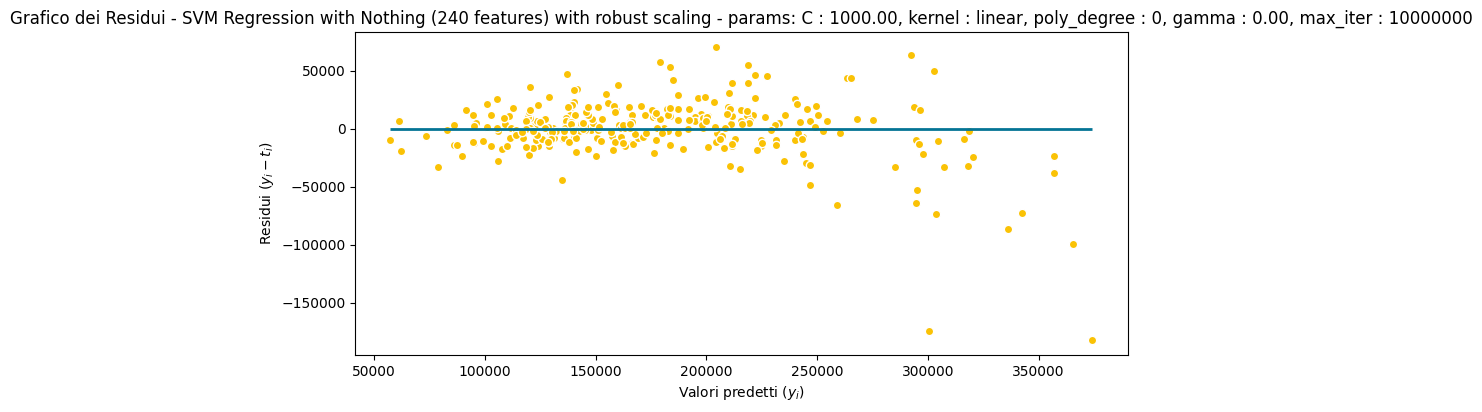

In [106]:
def performance_svm_regression(dataset: Dataset) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.Nothing] # [FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [True]
    C_values = [1000] # [0.1, 0.5, 1, 1.5, 2]
    kernel_values = ['linear'] # poly non lo usiamo perché non termina mai
    poly_degree_values = [1, 2, 3]
    gamma_values = [0.001]
    max_iter = 10_000_000
    curr_iter = 0
    if 'poly' in kernel_values:
        total_iterations = (len(fs_reduct_types) * len(scaling) * len(C_values) * len(gamma_values)) * (len(poly_degree_values) + len(kernel_values) - 1)
    else:
        total_iterations = len(fs_reduct_types) * len(scaling) * len(C_values) * len(gamma_values) * len(kernel_values)
    k_pca = 10
    k_fs = 240
    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)
    for scaled in scaling:
        for fs_reduct in fs_reduct_types:
            for c in C_values:
                for kernel in kernel_values:
                    for gamma in gamma_values:
                        if kernel == 'poly':
                            for poly_degree in poly_degree_values:
                                curr_iter += 1
                                # metto insieme i parametri nella classe, per comodita'
                                params = SVRParams(c, kernel, poly_degree, gamma, max_iter)
                                svr = params.create_svr()
                                x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
                                r2_train, rms_train, r2_test, rms_test, y_pred, features = raw_performance_test(svr, x_train, x_test, dataset.y_train, dataset.y_test)
                                # r2_train, rms_train, r2_test, rms_test, y_pred, features = performance_test_ext(params.create_svr(), dataset, fs_reduct, scaled, k_fs=k_fs, k_pca=k_pca, logs=False)
                                description = f"SVM Regression with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling - params: {str(params)}"
                                print(f"{curr_iter}/{total_iterations} - {description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
                                res = BestParameters(description, features, None, r2_test, rms_test, y_pred)
            
                                all_models.add(res)
                        else:
                            curr_iter += 1
                            # metto insieme i parametri nella classe, per comodita'
                            params = SVRParams(c, kernel, 0, gamma, max_iter)
                            svr = params.create_svr()
                            x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
                            r2_train, rms_train, r2_test, rms_test, y_pred, features = raw_performance_test(svr, x_train, x_test, dataset.y_train, dataset.y_test)
                            # r2_train, rms_train, r2_test, rms_test, y_pred, features = performance_test_ext(params.create_svr(), dataset, fs_reduct, scaled, k_fs=k_fs, k_pca=k_pca, logs=False)
                            description = f"SVM Regression with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling - params: {str(params)}"
                            print(f"{curr_iter}/{total_iterations} - {description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
                            res = BestParameters(description, features, None, r2_test, rms_test, y_pred)
        
                            all_models.add(res)
    return all_models

all_models_svr = None
all_models_svr = performance_svm_regression(dataset)
best_residual_plot(all_models_svr)
all_models.add_all(all_models_svr)

## 6.7 Regressione KNN
Il modello **K-nearest neighbors** è un metodo non parametrico che cerca i K campioni più simili al punto di input di cui vogliamo stimare l'output (ovvero la variabile dipendente) e ne calcola la media. 

In particolare, KNN considera una ipersfera di volume V centrata nell'elemento da predire $\bold{x}$ di $m$ features, che contiene $k$ elementi del training set. Per determinare la misura di distanza spesso si usano le distanze di Manhattan, Euclidea o di Minkowsky.

$$ d_{Manhattan}(\bold{x}_1, \bold{x}_2) = \sum_{i=1}^m |x_{i1} - x_{i2}| $$

$$ d_{Euclidea}(\bold{x}_1, \bold{x}_2) = \sqrt{\sum_{i=1}^m (x_{i1} - x_{i2})^2} $$

$$ d_{Minkowsky}(\bold{x}_1, \bold{x}_2) = \sqrt[p]{\sum_{i=1}^m (x_{i1} - x_{i2})^p} $$

Per la regressione si esegue la media dei valori target relativi ai punti interni all'ipersfera centrata in x $S(\bold{x})$:

$$ y(\bold{x}) = \frac{1}{k}\sum_{t_i : \bold{x}_i \in S(\bold{x})} t_1$$

I parametri sono:
- **n_neighbors**: indica il numero di vicini più vicini per la stima di un punto. Un valore alto porta a una decisione più stabile ma potenzialmente meno accurata. Al contrario, un valore basso di n_neighbors porta a decisioni più flessibili, ma più soggette al rumore nei dati.
- **weights**: indica il peso assegnato a ciascun vicino più prossimo. I possibili valori sono:
  - **'uniform'**, dove tutti i vicini hanno lo stesso peso;
  - **'distance'**, dove il peso di un vicino diminuisce all'aumentare della distanza dal punto di stima.
- **algorithm**: indica l'algoritmo utilizzato per trovare i vicini. I possibili valori sono:
    - **'ball_tree'**, che utilizza un albero di sfere per trovare i vicini più prossimi;
    - **'kd_tree'**, che utilizza un albero KD per trovare i vicini più prossimi;
    - **'brute'**, se il numero di punti è relativamente piccolo,  calcola esplicitamente le distanze tra tutti i punti e seleziona i vicini più prossimi.
- **p**: indica il tipo di distanza.
    - se p=1, utilizza la distanza di Manhattan;
    - se p=2, utilizza la distanza Euclidea;
    - se p arbitrario si utilizza la distanza Minkowski.


precomputing datasets...
precomputed 8 datasets
1/12 KNN Regression with FS (40 features) with robust scaling - params: 5 weights: uniform algorithm: brute distance-exponent: 1-> r2 train: 0.855179109025193, rms train: 30188.954075212947, r2 mean: 0.7698085946087241 - rms mean: 37543.95501412791 
2/12 KNN Regression with FS (40 features) with robust scaling - params: 5 weights: uniform algorithm: brute distance-exponent: 1-> r2 train: 0.855179109025193, rms train: 30188.954075212947, r2 mean: 0.7698085946087241 - rms mean: 37543.95501412791 
3/12 KNN Regression with FS (40 features) with robust scaling - params: 5 weights: uniform algorithm: brute distance-exponent: 2-> r2 train: 0.8317098360656777, rms train: 32522.124202663366, r2 mean: 0.7407120416655162 - rms mean: 39737.575217783204 
4/12 KNN Regression with FS (40 features) with robust scaling - params: 5 weights: uniform algorithm: brute distance-exponent: 2-> r2 train: 0.8317098360656777, rms train: 32522.124202663366, r2 mean:

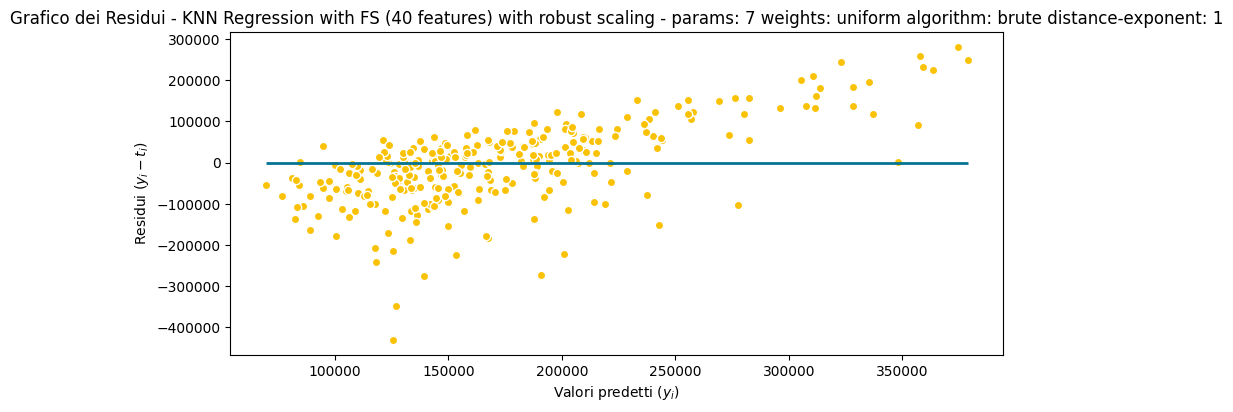

In [102]:
def performance_knn_regression(folds: List[Fold]) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.FS] #[FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [True] # [False, True]
    n_neighbors = [5, 7, 9] # [3, 5, 7, 9, 11]
    weights = ['uniform'] # ['uniform', 'distance']
    algorithm = ['brute'] # ['ball_tree', 'kd_tree', 'brute']
    leaf_size = [15, 30]
    p = [1, 2]  # Distance -> 1: Manhattan, 2: Euclidean, 3: Minkowski
    curr_iter = 0
    tot_iter = len(fs_reduct_types) * len(scaling) * len(n_neighbors) * len(weights) * len(algorithm) * len(leaf_size) * len(p)
    k_fs = 40
    k_pca = 6
    fspca_datasets = precompute_datasets(k_fs, k_pca, folds=folds)
    for n in n_neighbors:
        for w in weights:
            for a in algorithm:
                for exp in p:
                    for l in leaf_size:
                        for scaled in scaling:
                            for fs_reduct in fs_reduct_types:
                                curr_iter += 1
                                first_pred = None
                                features = 0
                                r2_train = rms_train = r2_test = rms_test = 0
                                # non esiste un random_state, quindi siamo costretti a fare prove su più dataset.
                                for i, f in enumerate(folds):
                                    dataset = Dataset(f.X_train, f.y_train, f.X_test, f.y_test)
                                    knnr = KNeighborsRegressor(weights=w, algorithm=a, n_neighbors=n, p=exp, leaf_size=l)
                                    x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca, fold=i)]
                                    r2_train_i, rms_train_i, r2_test_i, rms_test_i, y_pred, features_i = raw_performance_test(knnr, x_train, x_test, dataset.y_train, dataset.y_test)
                                    # r2_train_i, rms_train_i, r2_test_i, rms_test_i, y_pred, features_i = performance_test_ext(knnr, dataset, fs_reduct, scaled=scaled, k_pca=k_pca, k_fs=k_fs, logs=False)
                                    r2_train += r2_train_i / len(folds)
                                    rms_train += rms_train_i / len(folds)
                                    r2_test += r2_test_i / len(folds)
                                    rms_test += rms_test_i / len(folds)
                                    # prendo le predizioni del fold 1, per mantenere la compatibilità
                                    if i == len(folds) - 1:
                                        first_pred = y_pred
                                        features = features_i
                                description = f"KNN Regression with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling - params: {n} weights: {w} algorithm: {a} distance-exponent: {exp}"
                                print(f"{curr_iter}/{tot_iter} {description}-> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
                                res = BestParameters(description, features, None, r2_test, rms_test, first_pred)
                                
                                all_models.add(res)
    return all_models

all_models_knn = performance_knn_regression(folds)
best_residual_plot(all_models_knn)
all_models.add_all(all_models_knn)

## 6.8 Regressione Kernel (Nadaraya Watson)
Come KNN, anche la Kernel Regression di Nadaraya Watson è un **metodo non parametrico**, in cui la predizione avviene facendo riferimento direttamente agli elementi del training set, senza la necessità di addestrare un modello.
La regressione kernel è particolarmente efficace per modellare relazioni non lineari tra le variabili di input e di output.

La regressione kernel utilizza una funzione kernel per trasformare le variabili di input in uno spazio di dimensione superiore, dove è più probabile che esista una relazione lineare tra le variabili trasformate e l'output.  

Innanzitutto dobbiamo definire una funzione kernel $\kappa_h (x)$ con due caratteristiche:
- non nulla solo in un itervallo intorno allo $0$ di ampiezza $h$ (_banda del kernel_)
- massima in $0$

Per eseguire la regressione kernel Nadaraya-Watson abbiamo bisogno di questa libreria:

In [ ]:
%pip install scikit-fda

In [134]:
from skfda.misc.hat_matrix import (
    KNeighborsHatMatrix,
    LocalLinearRegressionHatMatrix,
    NadarayaWatsonHatMatrix,
)
from skfda.ml.regression._kernel_regression import KernelRegression

### 6.8.1 Performance della Kernel Regression con stimatori NadarayaWatsonHatMatrix e KNeighboursHatMatrix
La **Nadaraya-Watson Hat Matrix** è una matrice utilizzata nella stima non parametrica dei modelli di regressione. Questa matrice è spesso usata in combinazione con il kernel di Nadaraya-Watson per stimare la variabile dipendente in un problema di regressione.

precomputing datasets...
precomputed 8 datasets
1/64 Kernel Regression with NadarayaWatson with Nothing (240 features) with no scaling - bandwidth = 1.0 -> r2 train: 0.9999963918011199, rms train: 153.71455129680544, r2 mean: -5.933409602853543 - rms mean: 192323.16029501756 
2/64 Kernel Regression with NadarayaWatson with Nothing (240 features) with no scaling - bandwidth = 10.0 -> r2 train: 0.9999357809147625, rms train: 648.4877930860673, r2 mean: -2.9245463260320936 - rms mean: 144694.78803986977 
3/64 Kernel Regression with NadarayaWatson with Nothing (240 features) with no scaling - bandwidth = 100.0 -> r2 train: 0.9978806191543734, rms train: 3725.4114966950556, r2 mean: 0.4689341465746898 - rms mean: 53227.04387284228 
4/64 Kernel Regression with NadarayaWatson with Nothing (240 features) with no scaling - bandwidth = 1000.0 -> r2 train: 0.5448224636313019, rms train: 54595.91619207591, r2 mean: 0.3950836226038663 - rms mean: 56807.519904960565 
5/64 Kernel Regression with KNei

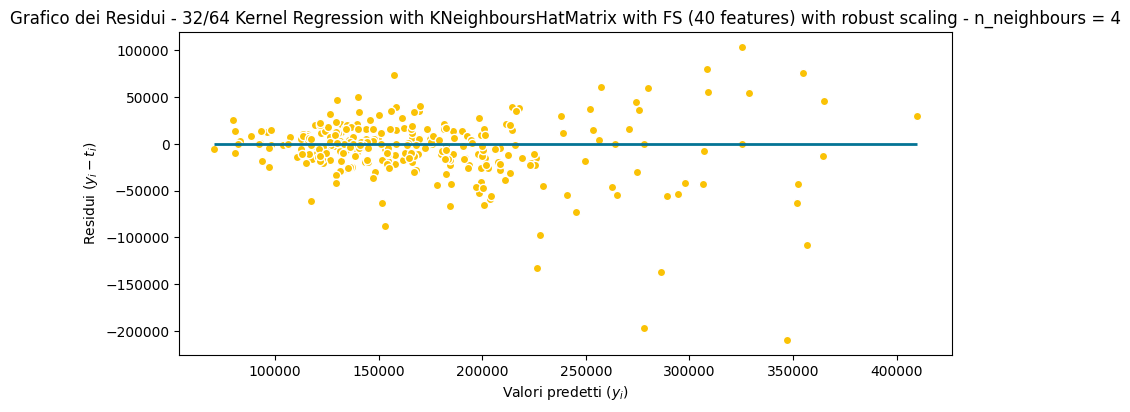

In [87]:
class KernelType(Enum):
    NadarayaWatson = 1
    KNeighboursHatMatrix = 2

def get_bandwidth(scaled=True, n_elements=2):
    if scaled:
        # 100 numeri da 10^-2=0.01 a 1=10^0. Questo funziona meglio se scaled=True
        bandwidth = np.logspace(-2, 0, num=n_elements)
    else:
        # numeri da 10^0 a 10^5 # questo funziona meglio se scaled=False
        bandwidth = np.logspace(0, 3, n_elements)
    return bandwidth

def get_kernel(kernel_type: KernelType, n_neighbors=5, bandwidth=0.01):
    match kernel_type:
        case KernelType.NadarayaWatson:
            return NadarayaWatsonHatMatrix(bandwidth=bandwidth)
        case KernelType.KNeighboursHatMatrix:
            return KNeighborsHatMatrix(n_neighbors=n_neighbors)

def performance_kernel_regression(dataset: Dataset) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [False, True]
    kernel_type = [KernelType.NadarayaWatson, KernelType.KNeighboursHatMatrix]
    n_bandwidths_or_neighbours = 4
    n_neighbors = np.array(range(1, n_bandwidths_or_neighbours + 1)) # per KNeighboursHatMatrix
    k_pca = 40
    k_fs = 40
    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)

    curr_iter = 0
    tot_iter = len(fs_reduct_types) * len(scaling) * len(kernel_type) * n_bandwidths_or_neighbours
    for fs_reduct in fs_reduct_types:
        for scaled in scaling:
            bandwidth = get_bandwidth(scaled=scaled, n_elements=n_bandwidths_or_neighbours) # migliori valori a seconda dello scaling. Per NadarayaWatson
            for kern in kernel_type:
                if kern == KernelType.NadarayaWatson:
                    for b in bandwidth:
                        kernel = get_kernel(kern, bandwidth=b)
                        curr_iter += 1
                        knw = KernelRegression(kernel_estimator=kernel)
                        x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
                        r2_train, rms_train, r2_test, rms_test, y_pred, features = raw_performance_test(knw, x_train, x_test, dataset.y_train, dataset.y_test)
                        description = f"{curr_iter}/{tot_iter} Kernel Regression with {kern.name} with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling - bandwidth = {b}"
                        print(f"{description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
                        res = BestParameters(description, features, None, r2_test, rms_test, y_pred)
                        
                        all_models.add(res)
                elif kern == KernelType.KNeighboursHatMatrix:
                    for n in n_neighbors:
                        kernel = get_kernel(kern, n_neighbors=n)
                        curr_iter += 1
                        knw = KernelRegression(kernel_estimator=kernel)
                        x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
                        r2_train, rms_train, r2_test, rms_test, y_pred, features = raw_performance_test(knw, x_train, x_test, dataset.y_train, dataset.y_test)
                        description = f"{curr_iter}/{tot_iter} Kernel Regression with {kern.name} with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling - n_neighbours = {n}"
                        print(f"{description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
                        res = BestParameters(description, features, None, r2_test, rms_test, y_pred)
                            
                        all_models.add(res)
    return all_models

all_models_knw = performance_kernel_regression(dataset)
best_residual_plot(all_models_knw)
all_models.add_all(all_models_knw)

## 6.9 Decision Tree
**Decision Tree** è un modello che costruisce un albero di decisione in cui ogni nodo interno rappresenta una decisione basata su una feature, e ogni foglia rappresenta il valore di regressione predetto.

Il modello di regressione ad albero di decisione cerca di dividere il training set in gruppi omogenei, o con minima **varianza**,  rispetto al valore di regressione. Ciò avviene suddividendo ricorsivamente il training set in base alle features finché non viene raggiunto un criterio di terminazione, come ad esempio la profondità massima dell'albero o il numero minimo di campioni in una foglia.

Il criterio per determinare la qualità di uno split e selezionare la migliore feature su cui separare, a differenza della classificazione in cui si utilizza l'entropia o l'indice di Gini, è l'errore quadratico medio, che minimizza la Loss L2, oppure l'absolute error che minimizza L1 usando la mediana.

La predizione dei valori avviene assegnando un valore a ciascuna foglia dell'albero di decisione, che per la regressione è tipicamente la media o la mediana dei valori predetti corrispondenti ai campioni di addestramento che cadono nella regione di spazio corrispondente alla foglia.

Parametri:
- **max_depth**: specifica la profondità massima dell'albero;
- **min_samples_split**: numero minimo di campioni richiesti per suddividere un nodo;
- **min_samples_leaf**: numero minimo di campioni richiesti in una foglia;
- **max_features**: numero massimo di feature considerate per la suddivisione di un nodo.

precomputing datasets...
precomputed 8 datasets
1/96 Decision Tree Regression with Nothing (240 features) with robust scaling - params: max_depth: 5 min_samples_split: 50 min_samples_leaf: 5 max_features: sqrt criterion: absolute_error -> r2 train: 0.5240304634644786, rms train: 55828.93287192717, r2 mean: 0.34733952238612276 - rms mean: 59006.76632700578 
2/96 Decision Tree Regression with Nothing (240 features) with robust scaling - params: max_depth: 5 min_samples_split: 50 min_samples_leaf: 5 max_features: sqrt criterion: squared_error -> r2 train: 0.5754013274792591, rms train: 52730.15695006798, r2 mean: 0.5579640398927102 - rms mean: 48560.92587784265 
3/96 Decision Tree Regression with Nothing (240 features) with robust scaling - params: max_depth: 5 min_samples_split: 50 min_samples_leaf: 15 max_features: sqrt criterion: absolute_error -> r2 train: 0.5623233472570317, rms train: 53536.06396474557, r2 mean: 0.4453439954020356 - rms mean: 54396.38231197123 
4/96 Decision Tree Re

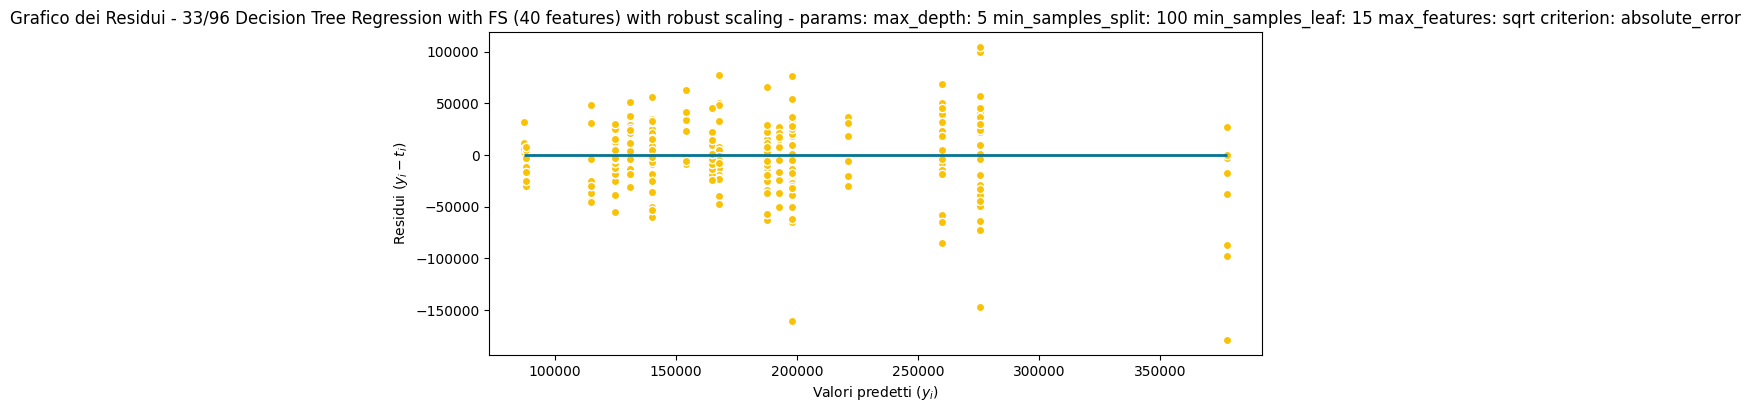

In [99]:
def performance_decision_tree_regression(dataset: Dataset) -> AllModelBestParameter:
    np.random.seed(42) # necessario, random_state non basta!!!
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [True]
    max_depth = [5,9]
    min_samples_split = [50, 100]
    min_samples_leaf = [5, 15, 20]
    max_features = ['sqrt'] # [None, 'sqrt', 'log2']
    criterion = ['absolute_error', 'squared_error']
    k_fs = 40
    k_pca = 40
    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)
    curr_iter = 0
    tot_iter = len(fs_reduct_types) * len(scaling) * len(max_depth) * len(min_samples_split) * len(min_samples_leaf) * len(max_features) * len(criterion)
    for scaled in scaling:
        for fs_reduct in fs_reduct_types:
            for maxd in max_depth:
                for min_ss in min_samples_split:
                    for min_sl in min_samples_leaf:
                        for maxf in max_features:
                            for crit in criterion:
                                curr_iter += 1
                                decision_tree = DecisionTreeRegressor(random_state=42, max_depth=maxd, min_samples_split=min_ss, min_samples_leaf=min_sl, max_features=maxf, criterion=crit)
                                key = f"scaling:{scaled}-{fs_reduct.name}-kfs:{k_fs}-kpca:{k_pca}"
                                x_train, x_test = fspca_datasets[key]
                                r2_train, rms_train, r2_test, rms_test, y_pred, features = raw_performance_test(decision_tree, x_train, x_test, dataset.y_train, dataset.y_test)
                                scaled_str = "robust" if scaled else "no"
                                description = f"{curr_iter}/{tot_iter} Decision Tree Regression with {fs_reduct.name} ({features} features) with {scaled_str} scaling - params: max_depth: {maxd} min_samples_split: {min_ss} min_samples_leaf: {min_sl} max_features: {maxf} criterion: {crit}"
                                print(f"{description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
                                res_linear_regression = BestParameters(description, features, None, r2_test, rms_test, y_pred)
                                
                                all_models.add(res_linear_regression)
    return all_models

all_models_dec_tree = performance_decision_tree_regression(dataset)
best_residual_plot(all_models_dec_tree)
all_models.add_all(all_models_dec_tree)

## 6.10 Reti neurali
Le **reti neurali** sono composte da unità di calcolo chiamate **neuroni artificiali** che sono organizzati in strati, formando una struttura a "rete". Ogni neurone riceve input da altri neuroni, elabora questi input e produce un output che può essere trasmesso ad altri neuroni.

Le reti neurali sono ampiamente utilizzate per problemi di classificazione e regressione. Durante il processo di addestramento, una rete neurale impara ad adattare i pesi delle connessioni tra i neuroni in modo da ottenere le migliori previsioni possibili sui dati di addestramento.

Definiamo una classe **Dataset** con dati in tensori pytorch:

In [50]:
import torch
import torch.optim as optim
import tqdm
import copy


class DatasetNN():
    # la feature reduction deve essere effettuata prima di chiamare questo costruttore!!!
    def __init__(self, X_train: DataFrame, X_test: DataFrame, y_train: Series, y_test: Series):
        self.X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
        self.y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1) #.to(torch.float64)
        self.X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
        self.y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1) #.to(torch.float64)
        self.numFeatures = self.X_train.data.shape[1]
        self.numRow = self.X_train.shape[0]

Definiamo due Enum che permetteranno di scegliere il metodo di discesa del gradiente (optimizer) e la funzione loss

In [51]:
from torch import nn
Optimizer = optim.Adam | optim.Adagrad | optim.RMSprop | optim.Adadelta

class OptimizerEnum(Enum):
    Adam = 0  # efficiente in termini di memoria, tanti learning rate, non diventa infinitamente piccolo.
    AdaGrad = 1  # tanti learning rate, uno per parametro, tiene conto della storia precedente. Ha problemi di vanishing learning rate
    RMSprop = 2  # tanti learning rate, tiene conto solo della storia recente, il learning rate non decresce indefinitamente
    Adadelta = 3  # non necessita un learning rate iniziale, tanti learning rate, non decrescono indefinitamente

    def create_optimizer(self, parameters, learning_rate) -> Optimizer:
        match self:
            case OptimizerEnum.Adam:
                return optim.Adam(parameters, lr=learning_rate)
            case OptimizerEnum.AdaGrad:
                return optim.Adagrad(parameters, lr=learning_rate)
            case OptimizerEnum.RMSprop:
                return optim.RMSprop(parameters, lr=learning_rate)
            case OptimizerEnum.Adadelta:
                return optim.Adadelta(parameters)

Loss = nn.MSELoss | nn.L1Loss | nn.HuberLoss

class LossEnum(Enum):
    SquareLoss = 0
    AbsoluteLoss = 1
    HuberLoss = 2

    def create_loss(self) -> Loss:
        match self:
            case LossEnum.SquareLoss:
                return nn.MSELoss()
            case LossEnum.AbsoluteLoss:
                return nn.L1Loss()
            case LossEnum.HuberLoss:
                return nn.HuberLoss()

Definiamo una classe che faciliti la creazione e l'addestramento della rete neurale.

In [52]:
from torchinfo import summary
from torchmetrics import R2Score

class NeuralNet:
    def __init__(self, datasetNN: DatasetNN, model: nn.Module):
        self.datasetNN = datasetNN
        self.model = model


    def parameters(self):
        return self.model.parameters()

    def summary(self):
        print(summary(self.model, input_size=(self.datasetNN.numRow, self.datasetNN.numFeatures)))


    def train(self, n_epochs: int, optimizer: Optimizer, loss_fn: Loss, batch_start, batch_size):
        """
        returns history_r2, history_loss_error, best_r2, best_loss_error, best_y_pred
        """
        return self._network_train(n_epochs, optimizer, loss_fn, self.datasetNN.X_train,
                                   self.datasetNN.y_train, self.datasetNN.X_test, self.datasetNN.y_test,
                                   batch_start, batch_size)

    def _network_train(self, n_epochs: int, optimizer: Optimizer, loss_fn: Loss, X_train, y_train, X_test,
                       y_test, batch_start, batch_size) -> Tuple[Dict[str, Any], List[float], float, float, float]:
        """
        returns history_r2, history_loss_error, best_r2, best_loss_error, best_y_pred
        """
        self.model.to('cpu')
        # Hold the best model
        best_loss_error = np.inf  # init to infinity
        # best_weights = None
        best_r2 = -np.inf
        best_y_pred = None
        history_loss_error: List[float] = []
        history_r2: List[float] = []

        # training loop
        for epoch in range(n_epochs):
            self.model.train()  # attiva la modalità training
            with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    # take a batch
                    X_batch = X_train[start:start + batch_size]
                    y_batch = y_train[start:start + batch_size]
                    # print(X_batch.shape, y_batch.shape)

                    # forward pass
                    y_pred = self.model(X_batch)
                    # serve per avere la stessa dim tra y_pred_hat e y_train. Alternativa y_train = y_train.unsqueeze(-1)
                    # y_pred = y_pred.squeeze(-1)
                    loss = loss_fn(y_pred, y_batch)

                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    # update weights
                    optimizer.step()
                    # print progress
                    bar.set_postfix(mse=float(loss))
            # evaluate accuracy at end of each epoch
            self.model.eval()  # modalità valutazione
            y_pred = self.model(X_test)  #.squeeze(-1)
            mse = loss_fn(y_pred, y_test)
            mse = float(mse)

            r2score = R2Score()
            r2 = r2score(y_pred, y_test)
            history_loss_error.append(mse)
            history_r2.append(r2)
            if mse < best_loss_error:
                best_loss_error = mse
                best_r2 = r2
                # best_weights = copy.deepcopy(self.model.state_dict())
                best_y_pred = y_pred
            # early stopping
            if best_r2 > 0.90:
                print("<<<< EARLY STOPPING >>>>")
                break
        return history_r2, history_loss_error, best_r2, best_loss_error, best_y_pred

### 6.9.1 Iperparametri della rete neurale
Creiamo una classe che definisce gli iperparametri della rete neurale, in particolare:

- **dataset** dopo aver eventualmente eseguito riduzione di dimensionalità, in formato tensor.
- **modello** della rete neurale, con i suoi iperparametri:
   - numero di layer
   - numero di unita' in ogni layer
   - funzione di attivazione tra un layer e l'altro
   - eventuali DropOut per ridurre l'overfitting
- **ottimizzatore** tra Adam, AdaGrad, RMSprop e Adadelta
- **funzione loss** tra SquareLoss, AbsoluteLoss e HuberLoss
- **numero di epoche**
- **dimensione del batch**
- **learning rate**: Possiamo aumentare il learning rate per velocizzare l'addestramento, oppure diminuirlo per addestrare più a fondo. E' buona norma usare una via di mezzo. Ad esempio si potrebbe partire da 0.001 e poi man mano moltiplicare per 3 (e arrotondando .9 a 1), finché i tempi sono abbastanza brevi e le performance abbastanza buone.

In [54]:
class NetIperparameters:

    def __init__(self, datasetNN: DatasetNN, model: nn.Sequential, optimizer: OptimizerEnum, fs_reduct_type: FeatureReduction,
                 learning_rate=0.0001, loss=LossEnum.SquareLoss, num_epochs=500, batch_size=73, k_fs: int=None, k_pca: int=None, scaled=True):
        # il dataset e' gia' ridotto, il modello gia' completo.
        self.neural_net = NeuralNet(datasetNN, model)
        self.learning_rate = learning_rate
        self.parameters = self.neural_net.parameters()
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.k_fs = k_fs # servono solo per stampare
        self.k_pca = k_pca # servono solo per stampare
        self.fs_reduct_type = fs_reduct_type
        self.optimizer_name = optimizer.name
        self.optimizer = optimizer.create_optimizer(self.parameters, self.learning_rate)
        self.loss_name = loss.name
        self.loss = loss.create_loss()

        initial_features = datasetNN.X_train.shape[1]
        # gestione degli errori:
        match fs_reduct_type:
            case FeatureReduction.Nothing:
                if k_fs is not None or k_pca is not None: 
                    raise ValueError(f"k_fs e k_pca devono essere None se non si esegue feature selection o PCA")
            case FeatureReduction.FS:
                if k_fs != initial_features:
                    raise ValueError(f"k_fs ({k_fs}) deve essere esattamente pari al numero di features ({initial_features}), se usi Feature Selection")
            case FeatureReduction.PCA:
                if k_pca != initial_features:
                    raise ValueError(f"k_pca ({k_pca}) deve essere esattamente pari al numero di features ({initial_features}), se usi PCA")
            case FeatureReduction.FS_PCA:
                if k_pca != initial_features:
                    raise ValueError(f"k_pca ({k_pca}) deve essere esattamente pari al numero di features ({initial_features}), se usi FS e PCA")
                if k_pca >= k_fs:
                    raise ValueError(f"k_pca ({k_pca}) deve essere minore di k_fs ({k_fs}), altrimenti che usi a fare PCA?")

    def get_reduction_type(self) -> FeatureReduction:
        return self.neural_net.reduction_type
    
    def train_test_evaluate(self, force_plot=False) -> Tuple[float, float, float, float, Any, int]:
        """
        restituisce r2_train, rms_train, r2_test, rms_test, y_pred, features
        """
        print(self.to_string())
        batch_start = torch.arange(0, len(self.neural_net.datasetNN.X_train), self.batch_size)
        history_r2, history_loss_error, best_r2, best_loss_error, best_y_pred = self.neural_net.train(self.num_epochs,
                                                                                         self.optimizer, 
                                                                                         self.loss,
                                                                                         batch_start, 
                                                                                         self.batch_size)
        best_rms = np.sqrt(best_loss_error)
        # stampo solo se r2 sul test è maggiore di 0.86
        if best_r2 > 0.86 or force_plot:
            plt.plot(history_loss_error)
            plt.xlabel("epochs")
            plt.ylabel("mse")
            plt.show()
        # per i valori di training, prendo gli ultimi della history
        r2_train = history_r2[-1]
        loss_error_train = history_loss_error[-1]
        r2_test = best_r2
        rms_test = best_rms
        return r2_train, np.sqrt(loss_error_train), r2_test, rms_test, best_y_pred, self.neural_net.datasetNN.numFeatures

    def to_string(self):
        match self.fs_reduct_type:
            case FeatureReduction.Nothing:
                return f"optimizer: {self.optimizer_name} learning_rate: {self.learning_rate} loss_func: {self.loss} num_epochs: {self.num_epochs} batch_size: {self.batch_size} features: {self.neural_net.datasetNN.numFeatures}"
            case FeatureReduction.FS:
                return f"optimizer: {self.optimizer_name} learning_rate: {self.learning_rate} loss_func: {self.loss} num_epochs: {self.num_epochs} batch_size: {self.batch_size} k_fs: {self.k_fs}"
            case FeatureReduction.PCA:
                return f"optimizer: {self.optimizer_name} learning_rate: {self.learning_rate} loss_func: {self.loss} num_epochs: {self.num_epochs} batch_size: {self.batch_size} k_pca: {self.k_pca}"
            case FeatureReduction.FS_PCA:
                return f"optimizer: {self.optimizer_name} learning_rate: {self.learning_rate} loss_func: {self.loss} num_epochs: {self.num_epochs} batch_size: {self.batch_size} k_fs: {self.k_fs} k_pca: {self.k_pca}"
    def to_dict(self):
        match self.fs_reduct_type:
            case FeatureReduction.Nothing:
                return {"optimizer": self.optimizer_name, "learning_rate": self.learning_rate, "loss_func": self.loss, "num_epochs": self.num_epochs, "batch_size": self.batch_size, "features": self.neural_net.datasetNN.numFeatures}
            case FeatureReduction.FS:
                return {"optimizer": self.optimizer_name, "learning_rate": self.learning_rate, "loss_func": self.loss, "num_epochs": self.num_epochs, "batch_size": self.batch_size, "k_fs": self.k_fs}
            case FeatureReduction.PCA:
                return {"optimizer": self.optimizer_name, "learning_rate": self.learning_rate, "loss_func": self.loss, "num_epochs": self.num_epochs, "batch_size": self.batch_size, "k_pca": self.k_pca}
            case FeatureReduction.FS_PCA:
                return {"optimizer": self.optimizer_name, "learning_rate": self.learning_rate, "loss_func": self.loss, "num_epochs": self.num_epochs, "batch_size": self.batch_size, "k_fs": self.k_fs, "k_pca": self.k_pca}
    def __str__(self):
        return self.to_string()

    def __repr__(self):
        return self.to_string()


### 6.9.2 Training della rete

In [56]:
def init_random_seed(s):
    torch.manual_seed(s)
    np.random.seed(s)
    import random
    random.seed(s)

I parametri su cui fare model selection sono i seguenti:
- se il dataset è scaled o meno
- ottimizzatore
- funzione loss
- learning_rate
- numero di epoche
- dimensione del batch
- struttura della rete:
    - Numero di layer
    - Numero di neuroni per ogni layer
    - Funzione di attivazione tra un layer e l'altro

precomputing datasets...
precomputed 8 datasets
Sequential(
  (0): Linear(in_features=180, out_features=600, bias=True)
  (1): Linear(in_features=600, out_features=1, bias=True)
)
optimizer: Adam learning_rate: 0.0001 loss_func: MSELoss() num_epochs: 10 batch_size: 73 k_fs: 200 k_pca: 180
1/18 Multi Layer Perceptron with FS_PCA (180 features) with robust scaling
num_epochs: 10 - learning_rate: 0.0001 - optimizer: OptimizerEnum.Adam - loss: LossEnum.SquareLoss - activation_function: <class 'type'> - network_layers: 3 - units_in_each_layer: [180, 600, 1]
r2 train: -5.996672630310059, rms train: 193198.58417700685, r2 mean: -5.996672630310059 - rms mean: 193198.58417700685 
Sequential(
  (0): Linear(in_features=180, out_features=600, bias=True)
  (1): Linear(in_features=600, out_features=1, bias=True)
)
optimizer: Adam learning_rate: 0.001 loss_func: MSELoss() num_epochs: 10 batch_size: 73 k_fs: 200 k_pca: 180
2/18 Multi Layer Perceptron with FS_PCA (180 features) with robust scaling
num_

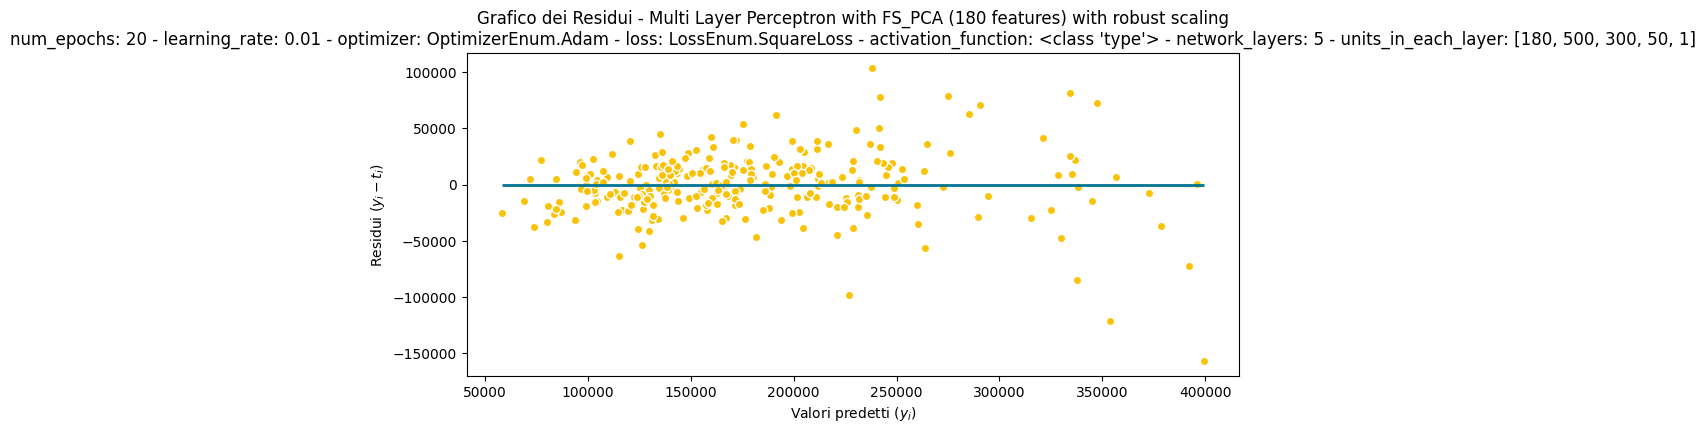

In [57]:
def define_mlp(num_layer: int, num_units_per_layer: List[int], activation_function=nn.ReLU()) -> nn.Sequential:
    if num_layer != len(num_units_per_layer):
        raise ValueError(f"La lista con i numeri di unità per layer deve avere tanti elementi quanti sono i layer {num_layer}, invece ne ha {len(num_units_per_layer)}")
    
    model = nn.Sequential()
    for i in range(num_layer - 1):
        model.append(nn.Linear(num_units_per_layer[i], num_units_per_layer[i+1]))
        if i+1 != num_layer:
            model.apply(activation_function) 
    print(model)
    return model

def performance_mlp(dataset: Dataset, k_fs, k_pca) -> AllModelBestParameter:
    init_random_seed(42)
    all_models = AllModelBestParameter()
    fs_reduct_types = [FeatureReduction.FS_PCA] #[FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [True]
    model_layers = [3, 4, 5]
    epochs = [10, 20] # [100, 50, 20, 10]
    learning_rates = [0.0001, 0.001, 0.01] # [0.001, 0.01, 0.1]
    optimizers = [OptimizerEnum.Adam] # [OptimizerEnum.Adam, OptimizerEnum.AdaGrad, OptimizerEnum.RMSprop, OptimizerEnum.Adadelta]
    losses = [LossEnum.SquareLoss] # [LossEnum.SquareLoss, LossEnum.AbsoluteLoss, LossEnum.HuberLoss]
    activation_functions = [nn.GELU] # [nn.ReLU, nn.GELU]

    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)

    curr_iter = 0
    tot_iter = len(fs_reduct_types) * len(scaling) * len(model_layers) * len(epochs) * len(learning_rates) * len(optimizers) * len(losses) * len(activation_functions)
    
    for fs_reduct in fs_reduct_types:
        for scaled in scaling:
            x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
            datasetNN = DatasetNN(X_train=x_train, y_train=dataset.y_train, X_test=x_test, y_test=dataset.y_test)
            input_features = x_train.shape[1]
            num_units_per_layer = [
                [input_features, 600, 1], 
                [input_features, 500, 300, 1],
                [input_features, 500, 300, 50, 1],
            ]
            for units_per_layer in num_units_per_layer:
                for num_epochs in epochs:
                    for learning_rate in learning_rates:
                        for optim in optimizers:
                            for loss in losses:
                                for acti_func in activation_functions:
                                    curr_iter += 1
                                    # definisco la rete neurale coi parametri correnti
                                    num_layers = len(units_per_layer)
                                    model = define_mlp(num_layers, units_per_layer, activation_function=acti_func)
                                    net_params = NetIperparameters(datasetNN, fs_reduct_type=fs_reduct, model=model, learning_rate=learning_rate, loss=loss, optimizer=OptimizerEnum.Adam, num_epochs=num_epochs, k_fs=k_fs if fs_reduct != FeatureReduction.Nothing else None, k_pca=k_pca if fs_reduct != FeatureReduction.Nothing else None)
                                    
                                    # addestro la rete neurale e ottengo le sue performance
                                    r2_train, rms_train, r2_test, rms_test, y_pred, features = net_params.train_test_evaluate()
                                    
                                    y_pred = pd.Series(y_pred.detach().flatten().numpy())

                                    # salvo la rete
                                    description = f"Multi Layer Perceptron with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling\nnum_epochs: {num_epochs} - learning_rate: {learning_rate} - optimizer: {optim} - loss: {loss} - activation_function: {type(acti_func)} - network_layers: {num_layers} - units_in_each_layer: {units_per_layer}"
                                    print(f"{curr_iter}/{tot_iter} {description}\nr2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
                                    res_mlp = BestParameters(description, features, net_params.to_dict(), r2_test, rms_test, y_pred)
                                    
                                    all_models.add(res_mlp)
    return all_models

all_models_mlp = performance_mlp(dataset, 200, 180)
best_residual_plot(all_models_mlp)
all_models.add_all(all_models_mlp)

In [146]:
print("best mlp r2", all_models_mlp.best_model(return_params=True).r2.detach().flatten().numpy()[0])

The best model of 18 analyzed is:
Multi Layer Perceptron with FS_PCA (180 features) with robust scaling
num_epochs: 20 - learning_rate: 0.01 - optimizer: OptimizerEnum.Adam - loss: LossEnum.SquareLoss - activation_function: <class 'type'> - network_layers: 5 - units_in_each_layer: [180, 500, 300, 50, 1] - features: 180 test r2: 0.8567440509796143 test rms: 27644.863247988767 (hyper)parameters: {'optimizer': 'Adam', 'learning_rate': 0.01, 'loss_func': MSELoss(), 'num_epochs': 20, 'batch_size': 73, 'k_fs': 200, 'k_pca': 180}
best mlp r2 0.85674405


In [58]:
def get_default_model(input_units, first_hidden_layer):
    return nn.Sequential(
        nn.Linear(input_units, first_hidden_layer),
        nn.ReLU(),
        nn.Linear(first_hidden_layer, 300),
        nn.ReLU(),
        nn.Linear(300, 1)
    )

def try_one_mlp(dataset: Dataset, fs_reduct_type: FeatureReduction, k_fs_senza_pca: int, k_pca: int, num_epochs: int, learning_rate: float, optimizer: OptimizerEnum=OptimizerEnum.Adam, loss: LossEnum=LossEnum.SquareLoss, scaled=True):
    init_random_seed(42)
    x_train, x_test, input_units = get_specific_train_test(dataset, fs_reduct_type, scaled, k_fs_senza_pca, k_pca)

    datasetNN = DatasetNN(x_train, x_test, dataset.y_train.copy(), dataset.y_test.copy())

    # scegli se fare FS e/o PCA
    model = get_default_model(input_units, 500)
    k_fs_with_pca = get_k_fs_with_pca(dataset.X_train.shape[1], k_pca)
    net_params = NetIperparameters(datasetNN, model, learning_rate=learning_rate, fs_reduct_type=fs_reduct_type, k_fs=k_fs_with_pca if fs_reduct_type == FeatureReduction.FS_PCA else k_fs_senza_pca, k_pca=k_pca,
                                optimizer=optimizer, loss=loss, num_epochs=num_epochs)
    r2_train, rms_train, r2_test, rms_test, _, features = net_params.train_test_evaluate(force_plot=True)
    print(f"r2_train: {r2_train} rms_train: {rms_train}, r2_test: {r2_test}, rms_test: {rms_test}, features: {features}")

#### Modello 1 - optimizer: RMSprop learning_rate: 0.003 loss_func: MSELoss() num_epochs: 50 batch_size: 73 k_fs: 100 k_pca: 80

optimizer: RMSprop learning_rate: 0.003 loss_func: MSELoss() num_epochs: 50 batch_size: 73 k_fs: 100 k_pca: 80


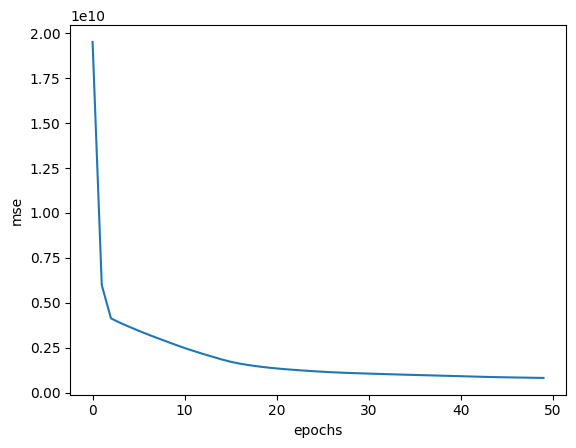

r2_train: 0.8465559482574463 rms_train: 28611.011027225166, r2_test: 0.8465559482574463, rms_test: 28611.011027225166, features: 80


In [59]:
try_one_mlp(dataset, FeatureReduction.FS_PCA, k_fs_senza_pca=100, k_pca=80, num_epochs=50, learning_rate=0.003, optimizer=OptimizerEnum.RMSprop, loss=LossEnum.SquareLoss, scaled=True)
# r2 test 0.8465559482574463

#### Modello 2 - optimizer: Adam learning_rate: 0.01 loss_func: MSELoss() num_epochs: 50 batch_size: 73 k_fs: 50 k_pca: 20

optimizer: Adam learning_rate: 0.01 loss_func: MSELoss() num_epochs: 50 batch_size: 73 k_fs: 100 k_pca: 20


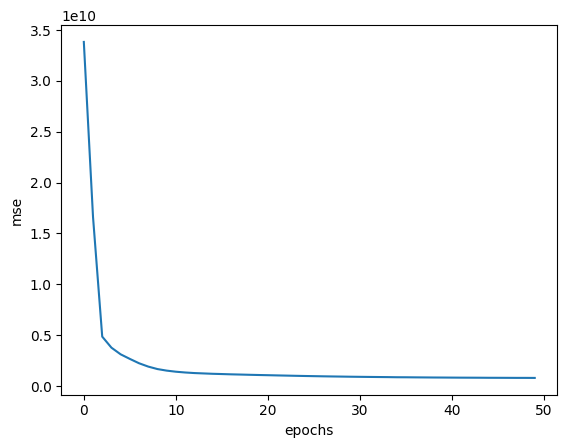

r2_train: 0.8517879247665405 rms_train: 28119.007663856133, r2_test: 0.8517879247665405, rms_test: 28119.007663856133, features: 20


In [60]:
# attenzione k_fs se usi anche pca viene cambiato
try_one_mlp(dataset, FeatureReduction.FS_PCA, k_fs_senza_pca=100, k_pca=20, num_epochs=50, learning_rate=0.01, optimizer=OptimizerEnum.Adam, loss=LossEnum.SquareLoss, scaled=True)
# r2 test = 0.8517879247665405

#### Modello 3 - optimizer: Adam learning_rate: 0.001 loss_func: MSELoss() num_epochs: 500 batch_size: 73 k_fs: 100 k_pca: 20

optimizer: Adam learning_rate: 0.001 loss_func: MSELoss() num_epochs: 500 batch_size: 73 k_fs: 100 k_pca: 20


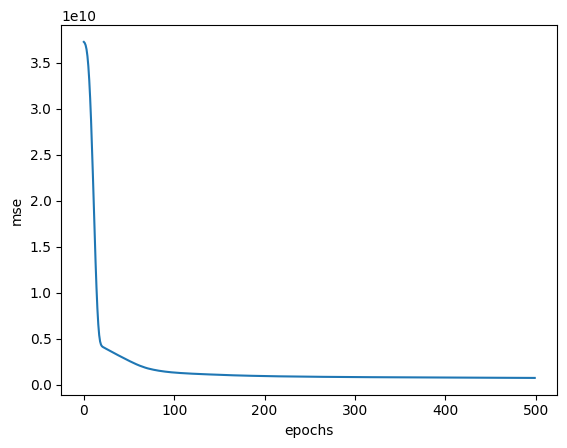

r2_train: 0.8637616634368896 rms_train: 26959.2522151487, r2_test: 0.8637616634368896, rms_test: 26959.2522151487, features: 20


In [61]:
try_one_mlp(dataset, FeatureReduction.FS_PCA, k_fs_senza_pca=100, k_pca=20, num_epochs=500, learning_rate=0.001, optimizer=OptimizerEnum.Adam, loss=LossEnum.SquareLoss, scaled=True)
# r2 test 0.8637616634368896

## 6.10 Processi gaussiani [ELIMINARE]
Usiamo la classe GaussianProcessRegressor per effettuare una regressione con processo gaussiano, prima senza rumore e poi aggiungendo un rumore gaussiano. Anche questo è un metodo non parametrico.

I parametri del costruttore della classe sono:
- kernel: un'istanza di un kernel per la matrice di covarianza.
- alpha: la varianza da assegnare alla diagonale della matrice di covarianza della distribuzione a priori


precomputing datasets...
precomputed 8 datasets


/home/giaco/PycharmProjects/ProgettoML/venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/giaco/PycharmProjects/ProgettoML/venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1/1 - Gaussian Process Regression with FS (40 features) with robust scaling - sigma_f = 0.9 - sigma_n = 0.8 -> r2 train: 0.9999963228597586, rms train: 155.1761043346704, r2 mean: 0.6998238850093719 - rms mean: 40017.15636154329 
The best model of 1 analyzed is:
Gaussian Process Regression with FS (40 features) with robust scaling - sigma_f = 0.9 - sigma_n = 0.8 - features: 40 test r2: 0.6998238850093719 test rms: 40017.15636154329


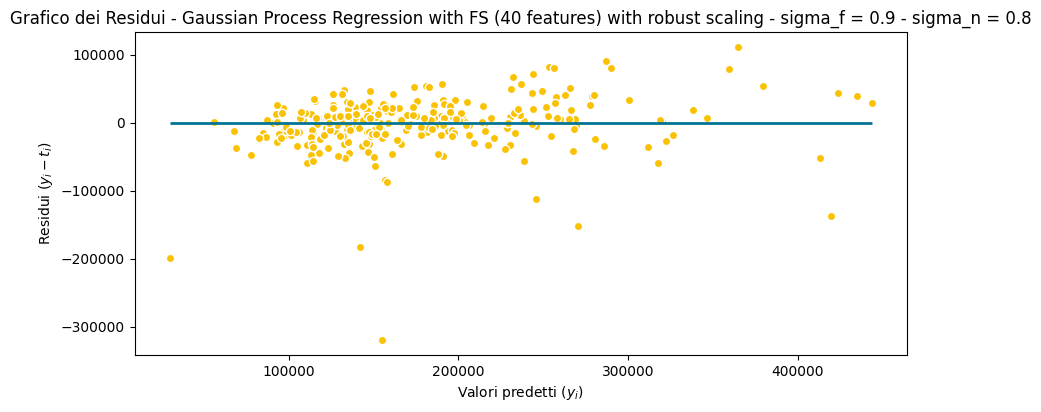

In [72]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF


def gaussian_process_performance(dataset: Dataset) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types =  [FeatureReduction.FS]
    scaling = [True]
    k_fs = 40
    k_pca = 40
    sigma_f_list = [0.9]
    sigma_n_list = [0.8]
    tau_list = [0.1]
    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)

    curr_iter = 0
    tot_iter = len(scaling) * len(fs_reduct_types) * len(sigma_f_list) * len(sigma_n_list)

    for scaled in scaling:
        for fs_reduct in fs_reduct_types:
            for sigma_f in sigma_f_list:
                for sigma_n in sigma_n_list:
                    for tau in tau_list:
                        curr_iter += 1
                        # definiamo la funzione kernel per la matrice di covarianza (matrice di Gram)
                        kernel = ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-10, 1e10)) * RBF(length_scale=tau, length_scale_bounds=(5e-1, 5e2))
                        # definiamo l'oggetto GaussianProcessRegressor
                        gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n ** 2, n_restarts_optimizer=5)
                        x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
                        r2_train, rms_train, r2_test, rms_test, y_pred, features = raw_performance_test(gp, x_train, x_test, dataset.y_train, dataset.y_test)
                        description = f"Gaussian Process Regression with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling - sigma_f = {sigma_f} - sigma_n = {sigma_n}"
                        print(f"{curr_iter}/{tot_iter} - {description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
                        res = BestParameters(description, features, None, r2_test, rms_test, y_pred)
                        
                        all_models.add(res)
    return all_models

all_models_gauss_proc = gaussian_process_performance(dataset)
best_residual_plot(all_models_gauss_proc)
all_models.add_all(all_models_gauss_proc)

# 7 Bagging and Boosting
**Bagging** e **boosting** sono entrambe tecniche di ensemble utilizzate per migliorare le prestazioni dei modelli di apprendimento automatico mediante l'aggregazione di più modelli deboli (weak learner).

**Bagging** utilizza un approccio di campionamento bootstrap per creare diversi sottoinsiemi di addestramento dal dataset di addestramento originale.

**Boosting** si basa sull'idea di addestrare una sequenza di modelli deboli, in cui ogni modello viene addestrato per correggere gli errori del modello precedente.

## 7.1 Bagging
I modelli di **bagging** per la regressione sono basati sull'aggregazione di diversi modelli deboli (o base learner) per ottenere una previsione più accurata

### 7.1.1 Random Forest
**Random Forest** combina i valori predetti di più alberi di decisione, addestrati su sottoinsiemi casuali del training set, per effettuare previsioni più robuste. Inoltre, durante la creazione di ciascun albero, solo un sottoinsieme casuale delle features viene considerato per la suddivisione dei nodi, il che aiuta a rendere i singoli alberi meno correlati tra loro.

Sia $B$ il numero di alberi di decisione da addestrare (comitato). Nel caso di scikit-learn è il parametro `n_estimators`. Per ogni albero $b$:
1. Utilizziamo il metodo bootstrap per selezionare un campione del dataset per ognuno dei $B$ alberi di decisione.
2. Facciamo crescere l'albero di decision $T_b$ sui dati eseguendo le operazioni per ogni nodo:
- Seleziona $m$ feature casualmente
- Tra queste, sceglie la feature "migliore" e divide il nodo in due figli.
3. Poiché stiamo considerando la regressione, la predizione avviene eseguendo una media dei valori predetti dai singoli alberi.

La metrica che permette di definire quale feature è migliore rispetto alle altre è spesso l'entropia, che misura l'impurità degli elementi di una regione.

I vantaggi di Random Forest rispetto a Decision Tree:
- riduce l'overfitting grazie all'aggregazione delle predizioni di diversi alberi;
- riduce la varianza;
- offre prestazioni migliori soprattutto quando i dati sono complessi o con elevato rumore.

Parametri:
- **n_estimators**: numero di alberi decisionali da creare. Un valore più alto aumenta la complessità del modello e può portare a prestazioni migliori, ma richiede anche più tempo di calcolo (e aumenta il rischio di overfitting).
- **max_depth**: indica la massima profondità di ogni albero decisionale. Un valore più alto di max_depth permette al modello di creare alberi più complessi, con il rischio di andare in overfitting;
- **min_samples_split**: specifica il numero minimo di campioni al di sotto del si smette di suddividere un nodo dell'albero. Se il numero di campioni in un nodo è inferiore a min_samples_split, il nodo non viene suddiviso ulteriormente; aumentare il valore di min_samples_split può impedire la suddivisione di nodi con un numero troppo basso di campioni e aiuta a evitare l'overfitting;
- **min_samples_leaf**: specifica il numero minimo di campioni richiesti in una foglia dell'albero. Se una suddivisione di un nodo genererebbe foglie con un numero inferiore a min_samples_leaf, quella suddivisione non viene effettuata; aumentare il valore di min_samples_leaf può aiutare a evitare foglie con un numero molto basso di campioni.
- **max_features**: specifica il numero massimo di caratteristiche da considerare durante la ricerca della migliore suddivisione in ogni nodo dell'albero.
- **bootstrap**: se True, il training set viene suddiviso con il metodo bootstrap, ovvero estraendo un campione di elementi con rimpiazzo. Altrimenti è senza rimpiazzo. 

Un valore alto di **min_samples_split, min_samples_leaf** aiuta ad evitare overfitting, mentre, un valore alto di **max_dept** porta ad aumentarlo.

precomputing datasets...
precomputed 8 datasets
1/1 - Random Forest Regression with FS (40 features) with robust scaling - best_n_estimators: 100 - best_max_depth: 7 - best_min_samples_leaf: 1 - best_min_samples_split: 2 best_max_features: log2 -> r2 train: 0.9308329521283087, rms train: 21282.339552247373, r2 mean: 0.8548358135136328 - rms mean: 27828.378412142913 
The best model of 1 analyzed is:
Random Forest Regression with FS (40 features) with robust scaling - best_n_estimators: 100 - best_max_depth: 7 - best_min_samples_leaf: 1 - best_min_samples_split: 2 best_max_features: log2 - features: 40 test r2: 0.8548358135136328 test rms: 27828.378412142913 (hyper)parameters: {'n_estimators': 100, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_features': 'log2'}


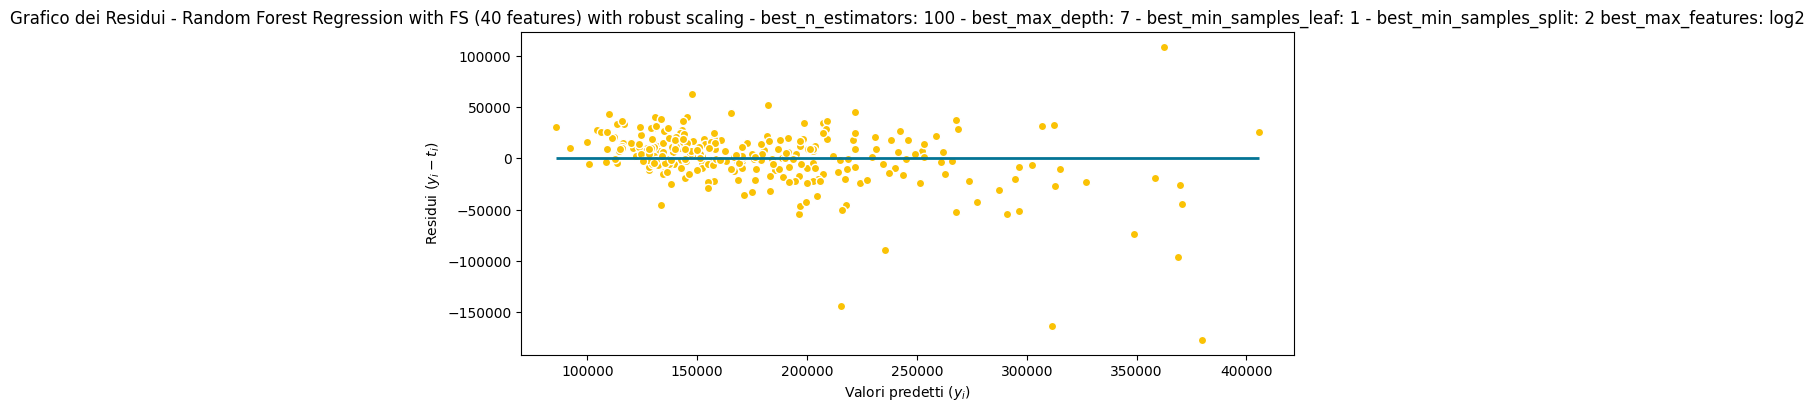

In [75]:
def random_forest_performance(dataset: Dataset) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.FS] # [FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [True]
    k_fs = 40
    k_pca = 40
    params_random_forest = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 3],
        'max_features': ['sqrt', 'log2']
    }
    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)

    curr_iter = 0
    tot_iter = len(scaling) * len(fs_reduct_types)

    for scaled in scaling:
        for fs_reduct in fs_reduct_types:
            curr_iter += 1
            # eseguiamo la grid search cross validation per trovare i migliori parametri tra quelli selezionati
            x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
            best_param_random_forest = raw_grid_search(RandomForestRegressor(random_state=42), x_train, dataset.y_train, params_random_forest)
            best_n_estimators = best_param_random_forest['n_estimators']
            best_max_depth = best_param_random_forest['max_depth']
            best_min_samples_leaf = best_param_random_forest['min_samples_leaf']
            best_min_samples_split = best_param_random_forest['min_samples_split']
            best_max_features = best_param_random_forest['max_features']
            best_random_forest_regr = RandomForestRegressor(random_state=42,
                                                            n_estimators=best_n_estimators,
                                                            max_depth=best_max_depth,
                                                            min_samples_leaf=best_min_samples_leaf,
                                                            min_samples_split=best_min_samples_split,
                                                            max_features=best_max_features)
            param_dict = {"n_estimators": best_n_estimators, "max_depth": best_max_depth, "min_samples_leaf": best_min_samples_leaf, "min_samples_split": best_min_samples_split, "max_features": best_max_features }
            r2_train, rms_train, r2_test, rms_test, y_pred, features = raw_performance_test(best_random_forest_regr, x_train, x_test, dataset.y_train, dataset.y_test)
            description = f"Random Forest Regression with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling"
            print(f"{curr_iter}/{tot_iter} - {description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
            res = BestParameters(description, features, param_dict, r2_test, rms_test, y_pred)
            
            all_models.add(res)
    return all_models

all_models_random_forest = random_forest_performance(dataset)
best_residual_plot(all_models_random_forest)
all_models.add_all(all_models_random_forest)

### 7.1.2 Bagging Regressor
Il bagging regressor è un meta-modello di ensemble per la regressione che può essere utilizzare come modello base diversi algoritmi di regressione, ad esempio DecisionTreeRegressor.

Si addestrano `m` modelli, prendendo un insieme di elementi dal dataset con rimpiazzo (metodo bootstrap) oppure senza rimpiazzo. Dopodiché per la regressione su un nuovo vettore di features, si esegue la media dei valori predetti dai modelli.

L'errore atteso da uno dei predittori rispetto alla funzione vera $h(\bold{x})$:

$$E_\bold{x}[(y_i (\bold{x})-h(\bold{x})^2)] = E_\bold{x}[\varepsilon_i (\bold{x})^2]$$

Se consideriamo l'errore medio su tutti i predittori $E_{av}$, otteniamo:

$$E_{av} = \frac{1}{m} \sum_{i=1}^m E_\bold{x}[\varepsilon_i (\bold{x})^2]$$

L'errore del comitato dei regressori è dato dall'errore della funzione di predizione vista come la media della differenza al quadrato tra la media delle predizioni e la funzione vera $h(\bold{x})$:

$$ E_c = E_\bold{x} [(\frac{1}{m} \sum_{i=1}^m y_i (\bold{x}) - h(\bold{x}))^2] = E_{\bold{x}}[(\frac{1}{m} \sum_{i=1}^m \varepsilon_i (\bold{x}))^2]$$

A differenza del metodo ensemble Random Forest, in questo caso utilizziamo il bootstrap per cambiare i dataset da dare in input agli m regressori, invece in Random Forest, il dataset è sempre lo stesso, ma cambia in modo randomico il modo in cui si scelgono gli split.

Parametri:
- **estimator**: specifica l'algoritmo di regressione da utilizzare come modello base. Di default, viene utilizzato DecisionTreeRegressor;
- **n_estimators**: specifica il numero di modelli base (stimatori) da aggregare nel bagging. Un numero maggiore di stimatori può ridurre la varianza, ma aumenta il costo computazionale;
- **max_samples** (opzionale): specifica la frazione o il numero di campioni da selezionare casualmente per ciascun stimatore durante l'addestramento;
- **max_features** (opzionale): specifica la frazione o il numero di feature da selezionare casualmente per ciascun stimatore durante l'addestramento.
- **bootstrap** (default=True): determina il modo in cui ricavare i campioni del dataset, se True si esegue il metodo bootstrap, ovvero si selezionano dati con rimpiazzo.

precomputing datasets...
precomputed 8 datasets
1/4 - Bagging Regression with Nothing (240 features) with robust scaling -> r2 train: 0.9708681136620901, rms train: 13811.919910483797, r2 mean: 0.9010122365580968 - rms mean: 22979.941241056757 
2/4 - Bagging Regression with FS (40 features) with robust scaling -> r2 train: 0.9698271745219196, rms train: 14056.51752424959, r2 mean: 0.8829387549945362 - rms mean: 24989.91203219477 
3/4 - Bagging Regression with PCA (40 features) with robust scaling -> r2 train: 0.9495120586889595, rms train: 18182.917956472564, r2 mean: 0.8161851689495164 - rms mean: 31314.712779678484 
4/4 - Bagging Regression with FS_PCA (40 features) with robust scaling -> r2 train: 0.9394873201529579, rms train: 19906.40983773799, r2 mean: 0.802309851149623 - rms mean: 32475.113095339155 
The best model of 4 analyzed is:
Bagging Regression with Nothing (240 features) with robust scaling - features: 240 test r2: 0.9010122365580968 test rms: 22979.941241056757 (hyper)p

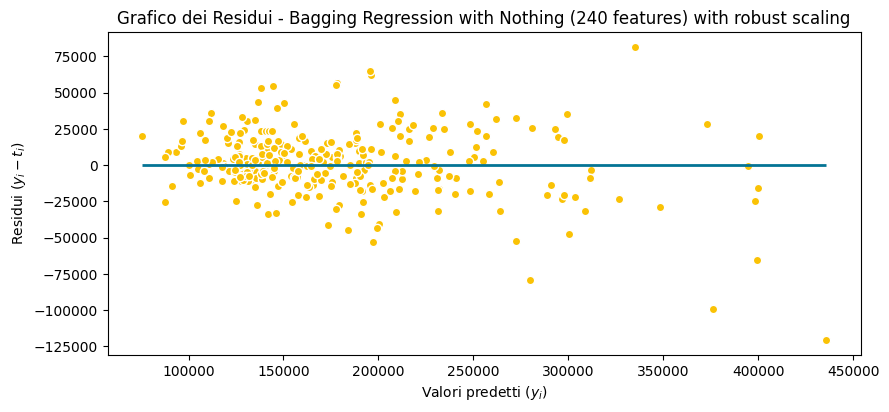

In [77]:
from sklearn.ensemble import BaggingRegressor
def bagging_regressor_performance(dataset: Dataset) -> AllModelBestParameter:
    all_models = AllModelBestParameter()
    # provo tutte le combinazioni di feature reduction e scaling per la linear regression
    fs_reduct_types = [FeatureReduction.Nothing, FeatureReduction.FS, FeatureReduction.PCA, FeatureReduction.FS_PCA]
    scaling = [True]
    k_fs = 40
    k_pca = 40
    params_bagging_regressor = {
        'estimator': [DecisionTreeRegressor()],
        'n_estimators': [15, 20, 25],
        'max_samples': [0.5, 0.7, 0.9],
        'max_features': [0.5, 0.7, 0.9],
        'bootstrap' : [True]
    }
    fspca_datasets = precompute_datasets(dataset, k_fs, k_pca)

    curr_iter = 0
    tot_iter = len(scaling) * len(fs_reduct_types)

    for scaled in scaling:
        for fs_reduct in fs_reduct_types:
            curr_iter += 1
            # eseguiamo la grid search cross validation per trovare i migliori parametri tra quelli selezionati
            x_train, x_test = fspca_datasets[get_precomputed_dataset_key(scaled, fs_reduct.name, k_fs, k_pca)]
            best_param_bagging = raw_grid_search(BaggingRegressor(random_state=42), x_train, dataset.y_train, params_bagging_regressor)
            best_estimator = best_param_bagging['estimator']
            best_n_estimators = best_param_bagging['n_estimators']
            best_max_samples = best_param_bagging['max_samples']
            best_max_features = best_param_bagging['max_features']
            best_bootstrap = best_param_bagging['bootstrap']
            best_random_forest_regr = BaggingRegressor(random_state=42,
                                                        estimator=best_estimator,
                                                        n_estimators=best_n_estimators,
                                                        max_samples=best_max_samples,
                                                        max_features=best_max_features,
                                                        bootstrap=best_bootstrap)
            
            param_dict = {"estimator": best_estimator, "n_estimators": best_n_estimators, "max_samples": best_max_samples, "max_features": best_max_features, "bootstrap": best_bootstrap}
            r2_train, rms_train, r2_test, rms_test, y_pred, features = raw_performance_test(best_random_forest_regr, x_train, x_test, dataset.y_train, dataset.y_test)
            description = f"Bagging Regression with {fs_reduct.name} ({features} features) with {'robust' if scaled else 'no'} scaling"
            print(f"{curr_iter}/{tot_iter} - {description} -> r2 train: {r2_train}, rms train: {rms_train}, r2 mean: {r2_test} - rms mean: {rms_test} ")
            res = BestParameters(description, features, param_dict, r2_test, rms_test, y_pred)
            
            all_models.add(res)
    return all_models

all_models_bagging_regr = bagging_regressor_performance(dataset)
best_residual_plot(all_models_bagging_regr)
all_models.add_all(all_models_bagging_regr)

## 7.2 Boosting
Il **boosting** è una tecnica di apprendimento automatico che combina diversi modelli deboli per creare un modello più potente e adattivo. A differenza di altri approcci di ensemble come il bagging, in cui i modelli vengono addestrati in modo indipendente e poi combinati, il boosting addestra i modelli in modo sequenziale, in cui ogni modello successivo cerca di correggere gli errori dei modelli precedenti.

### 7.2.1 Gradient Boosting
Il **gradient boosting** utilizza una tecnica di ottimizzazione del gradiente per addestrare i modelli successivi in modo che si concentrino sugli errori residui. L'idea chiave del gradient boosting è minimizzare una funzione di perdita attraverso l'aggiunta graduale di modelli che si concentrano sugli errori residui del modello precedente.

Parametri:
- **loss**: la funzione di perdita da utilizzare.
     - **squared_error**: si riferisce all'errore al quadrato per la regressione;
     - **absolute_error** si riferisce all'errore assoluto della regressione ed è una robusta funzione di perdita;
     - **huber** è una combinazione dei due;
     - **quantile** consente la regressione quantile (usa alfa per specificare il quantile).
- **n_estimators**: il numero di stimatori (alberi) da utilizzare;
- **learning_rate**: il tasso di apprendimento che controlla la contribuzione di ogni stimatore all'aggiornamento del modello. Un valore più piccolo richiede più stimatori per raggiungere la stessa capacità di un valore più grande;
- **max_depth**: la massima profondità degli alberi di regressione. Limitare la profondità può aiutare a controllare l'overfitting;
- **min_samples_split**: il numero minimo di campioni richiesti per suddividere un nodo interno;
- **min_samples_leaf**: il numero minimo di campioni richiesti in una foglia dell'albero;
- **max_features**: il numero di feature da considerare per la suddivisione migliore.

#### 7.2.1.1 RandomizedSearchCV

In [90]:
from sklearn.ensemble import GradientBoostingRegressor

params_gradient_boosting = {
    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}
gbr = GradientBoostingRegressor(random_state=42)
r2_gs_gradient_boosting, best_param_gradient_boosting = randomized_searchcv(gbr, dataset, params_gradient_boosting, scaled=False)
print(
    f"Gradient Boosting Regressor without normalization -> r2: {r2_gs_gradient_boosting} - best parameters: {best_param_gradient_boosting}")

gbr = GradientBoostingRegressor(random_state=42)
r2_gs_gradient_boosting_norm, best_param_gradient_boosting_norm = randomized_searchcv(gbr, dataset,
                                                                                      params_gradient_boosting)
print(
    f"Gradient Boosting Regressor with normalization -> r2: {r2_gs_gradient_boosting_norm} - best parameters: {best_param_gradient_boosting_norm}")

Gradient Boosting Regressor without normalization -> r2: 0.867684149799325 - best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'loss': 'huber', 'learning_rate': 0.1}
Gradient Boosting Regressor with normalization -> r2: 0.8745292428536813 - best parameters: {'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 7, 'loss': 'absolute_error', 'learning_rate': 0.1}


#### 7.2.1.2 Performance test
Valutiamo il modello:


In [91]:
gradient_boosting = GradientBoostingRegressor(random_state=42,
                                              n_estimators=best_param_gradient_boosting['n_estimators'],
                                              learning_rate=best_param_gradient_boosting['learning_rate'],
                                              max_depth=best_param_gradient_boosting['max_depth'],
                                        min_samples_split=best_param_gradient_boosting['min_samples_split'],
                                            min_samples_leaf=best_param_gradient_boosting['min_samples_leaf'],
                                              max_features=best_param_gradient_boosting['max_features'])
r2_gradient_boosting, rms_gradient_boosting, r2_test_gradient_boosting, rms_test_gradient_boosting, y_pred_gradient_boosting = performance_test(gradient_boosting, dataset)
print(f"Gradient Boosting Regressor -> r2 mean: {r2_gradient_boosting} - rms mean: {rms_gradient_boosting} - r2 test: {r2_test_gradient_boosting}, rms test: {rms_test_gradient_boosting}")

res_gradient_boosting = BestParameters(f"Gradient Boosting no normalization", 220, best_param_gradient_boosting, r2_test_gradient_boosting, rms_test_gradient_boosting, None)
parameters.append(res_gradient_boosting)

Gradient Boosting Regressor -> r2 mean: 0.9921329549640265 - rms mean: 7177.53908582561 - r2 test: 0.8761833627846329, rms test: 25700.860261262147


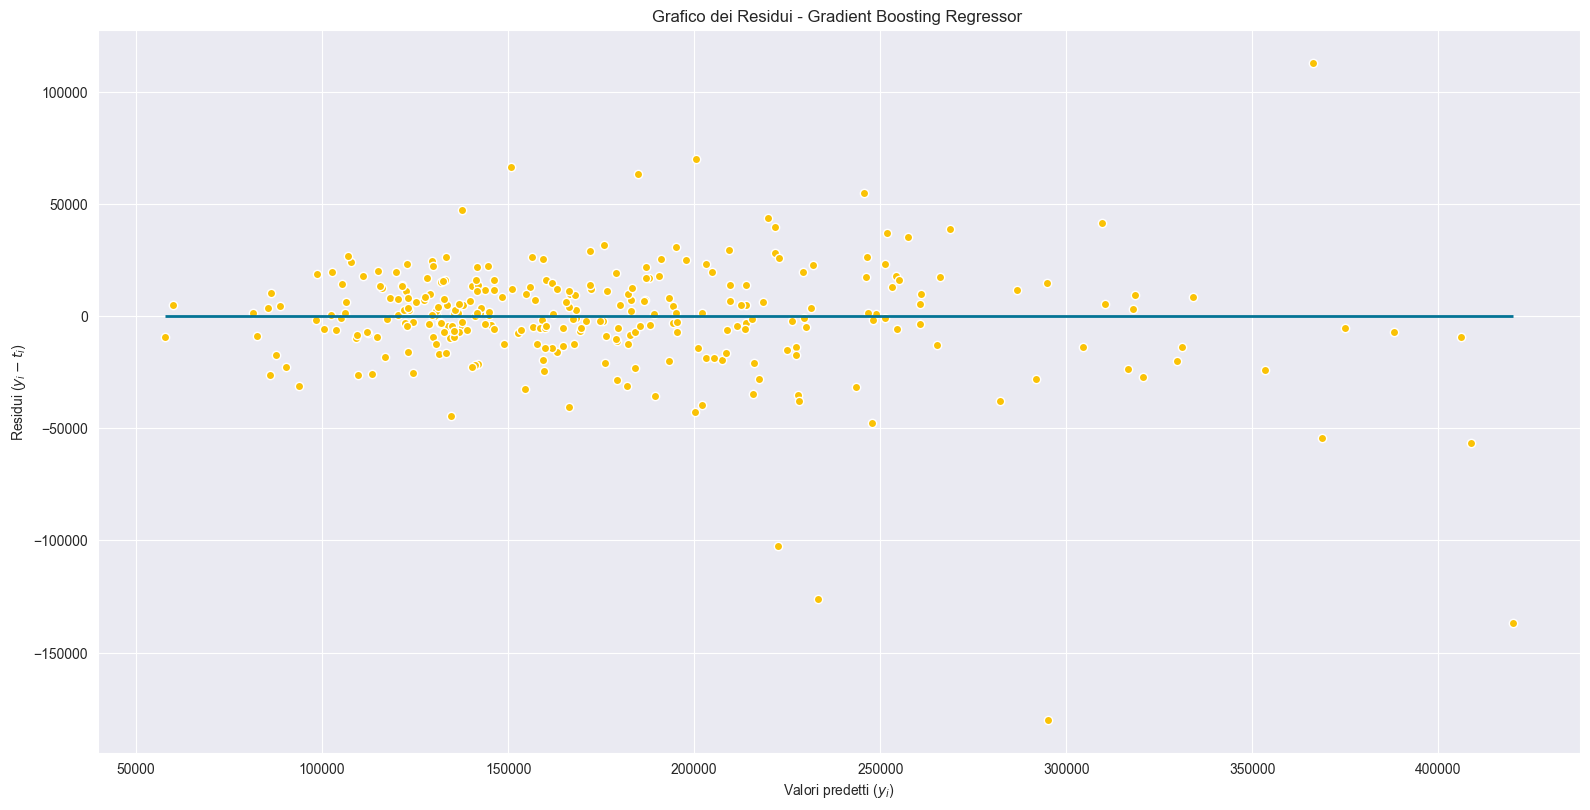

In [92]:
residual_plot(y_pred_gradient_boosting, dataset.y_test, 'Gradient Boosting Regressor ')

Valutiamo il modello con dataset normalizzato:

In [93]:
gradient_boosting = GradientBoostingRegressor(random_state=42,
                                              n_estimators=best_param_gradient_boosting_norm['n_estimators'],
                                              learning_rate=best_param_gradient_boosting_norm['learning_rate'],
                                              max_depth=best_param_gradient_boosting_norm['max_depth'],
                                        min_samples_split=best_param_gradient_boosting_norm['min_samples_split'],
                                            min_samples_leaf=best_param_gradient_boosting_norm['min_samples_leaf'],
                                              max_features=best_param_gradient_boosting_norm['max_features'])

r2_gradient_boosting, rms_gradient_boosting, r2_test_gradient_boosting, rms_test_gradient_boosting, y_pred_gradient_boosting1 = performance_test(gradient_boosting, dataset, scaled=True)
print(f"Gradient Boosting Regressor -> r2 mean: {r2_gradient_boosting} - rms mean: {rms_gradient_boosting} - r2 test: {r2_test_gradient_boosting}, rms test: {rms_test_gradient_boosting}")

res_gradient_boosting = BestParameters(f"Gradient Boosting with normalization", 220, best_param_gradient_boosting_norm, r2_test_gradient_boosting, rms_test_gradient_boosting, None)
parameters.append(res_gradient_boosting)

Gradient Boosting Regressor -> r2 mean: 0.9973563665383137 - rms mean: 4160.73798874488 - r2 test: 0.8712472512808115, rms test: 26208.15283588341


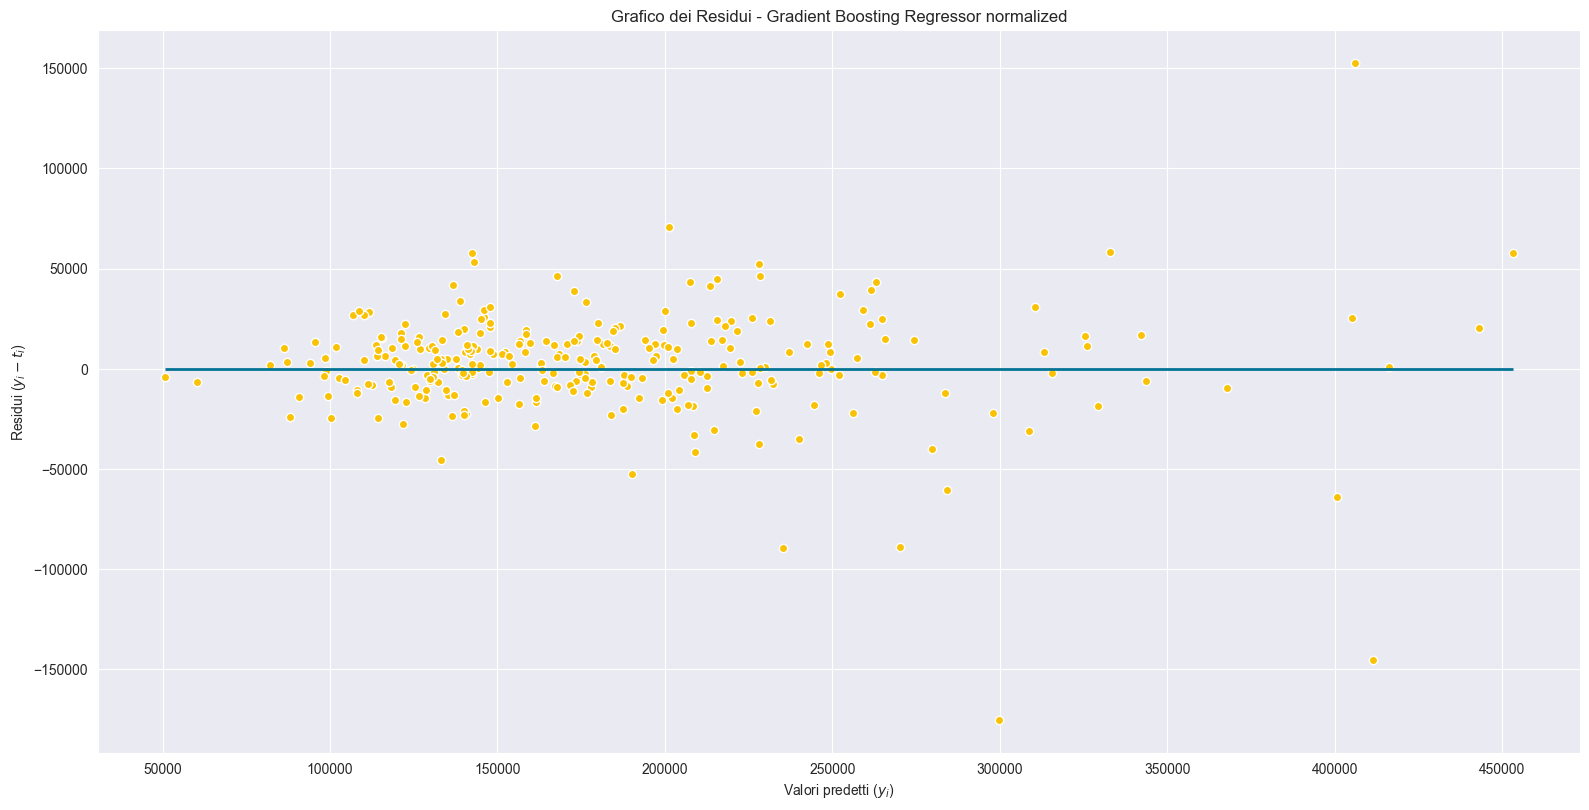

In [94]:
residual_plot(y_pred_gradient_boosting1, dataset.y_test, 'Gradient Boosting Regressor normalized')

#### 7.2.1.3 Performance test con pca, con/senza feature selection
Valutiamo il modello:

In [95]:
X_train_pca, X_test_pca, X_train_fs_pca, X_test_fs_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)

gradient_boosting = GradientBoostingRegressor(random_state=42,
                                              n_estimators=best_param_gradient_boosting['n_estimators'],
                                              learning_rate=best_param_gradient_boosting['learning_rate'],
                                              max_depth=best_param_gradient_boosting['max_depth'],
                                        min_samples_split=best_param_gradient_boosting['min_samples_split'],
                                            min_samples_leaf=best_param_gradient_boosting['min_samples_leaf'],
                                              max_features=best_param_gradient_boosting['max_features'])
score1_gradient_boosting, rms1_gradient_boosting, y_pred_gradient_boosting1 = run_regression_train_test(
    "Gradient Boosting Regressor with PCA", gradient_boosting,
    dataset, X_train_pca,
    X_test_pca, scaled=False)

gradient_boosting = GradientBoostingRegressor(random_state=42,
                                              n_estimators=best_param_gradient_boosting['n_estimators'],
                                              learning_rate=best_param_gradient_boosting['learning_rate'],
                                              max_depth=best_param_gradient_boosting['max_depth'],
                                        min_samples_split=best_param_gradient_boosting['min_samples_split'],
                                            min_samples_leaf=best_param_gradient_boosting['min_samples_leaf'],
                                              max_features=best_param_gradient_boosting['max_features'])
score2_gradient_boosting, rms2_gradient_boosting, y_pred_gradient_boosting2 = run_regression_train_test(
    "Gradient Boosting Regressor with FS and PCA",
    gradient_boosting, dataset,
    X_train_fs_pca, X_test_fs_pca, scaled=False)

res_gradient_boosting = BestParameters(f"Gradient Boosting no normalization con pca", 220, best_param_gradient_boosting, score1_gradient_boosting, rms1_gradient_boosting, None)
parameters.append(res_gradient_boosting)
res_gradient_boosting = BestParameters(f"Gradient Boosting no normalization con pca e fs", 220, best_param_gradient_boosting, score2_gradient_boosting, rms2_gradient_boosting, None)
parameters.append(res_gradient_boosting)

Feature ridotte da (1168, 240) con PCA: (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
Gradient Boosting Regressor with PCA - r2: 0.9736269788151007 - rms: 13141.643745385694 - r2 test: 0.7060197737647376 - rms test: 39602.0089761608
Gradient Boosting Regressor with FS and PCA - r2: 0.9861171906228454 - rms: 9534.73063238997 - r2 test: 0.8594192133249325 - rms test: 27385.529510543867


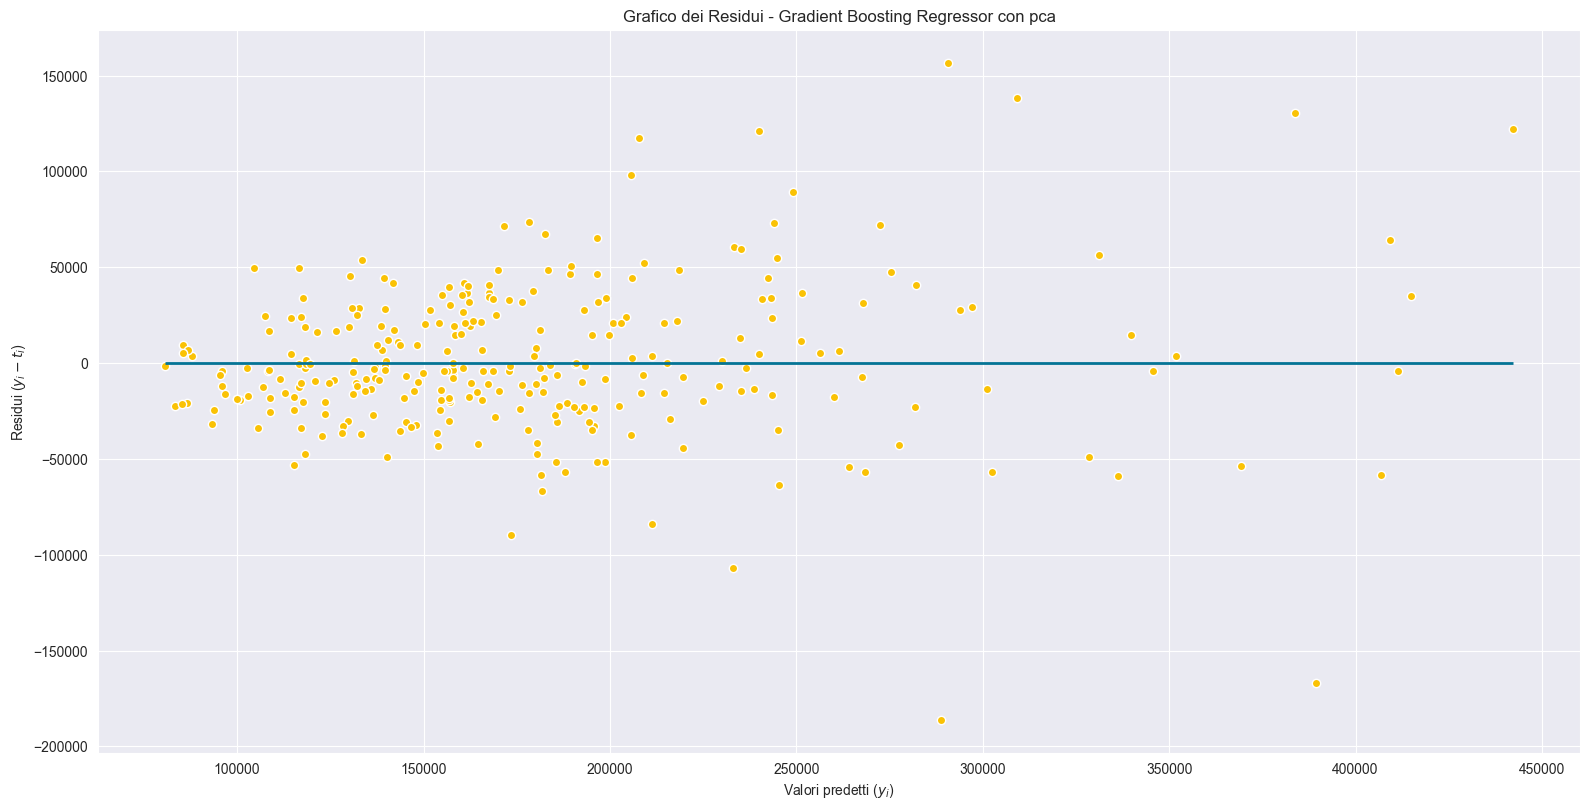

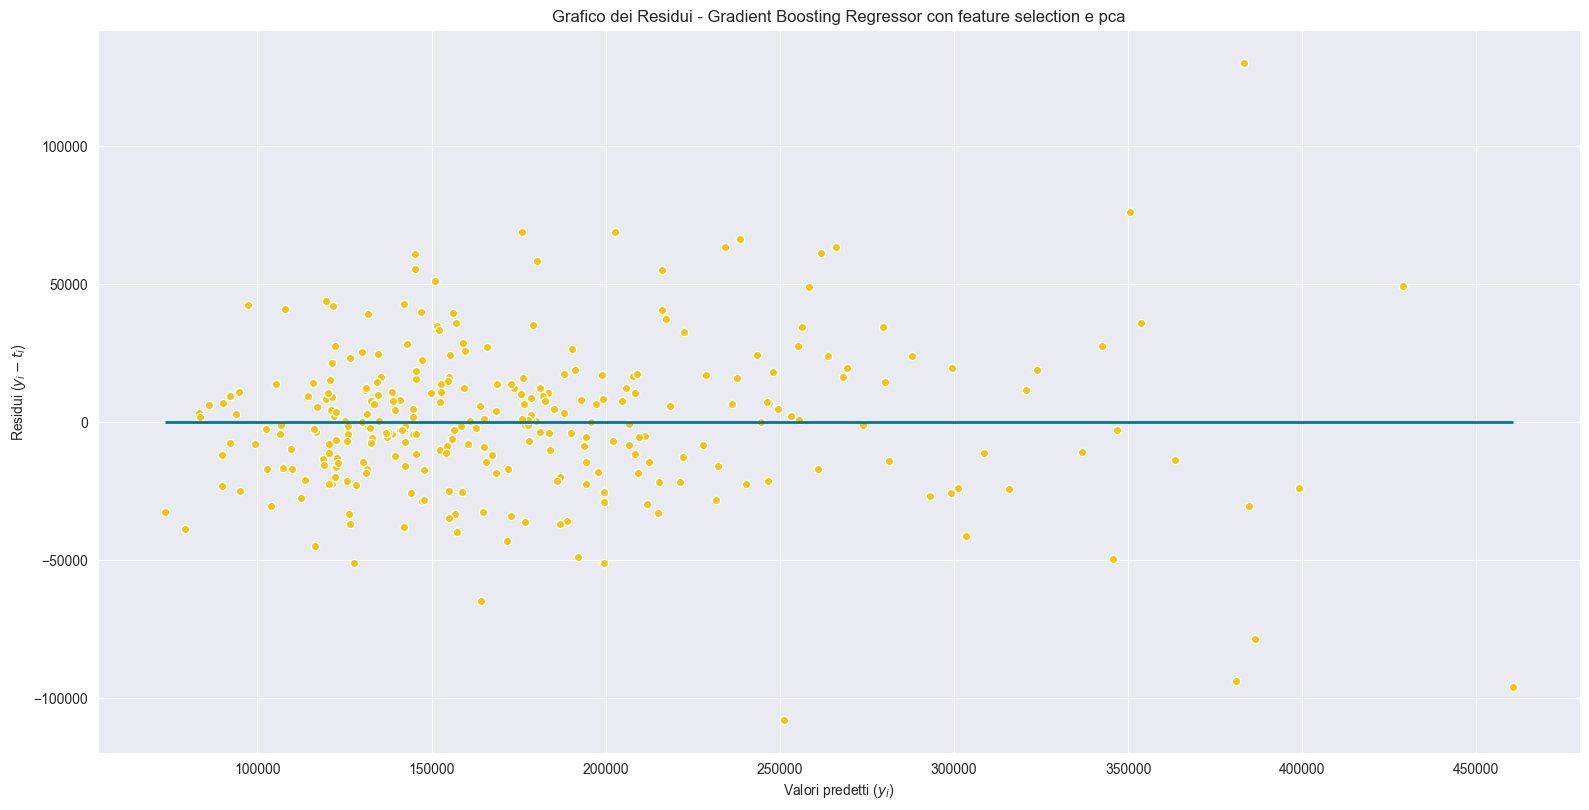

In [96]:
residual_plot(y_pred_gradient_boosting1, dataset.y_test, 'Gradient Boosting Regressor con pca')
residual_plot(y_pred_gradient_boosting2, dataset.y_test, 'Gradient Boosting Regressor con feature selection e pca')

Valutiamo il modello con un dataset normalizzato:

In [97]:
X_train_pca, X_test_pca, X_train_fs_pca, X_test_fs_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=True)

gradient_boosting = GradientBoostingRegressor(random_state=42,
                                              n_estimators=best_param_gradient_boosting_norm['n_estimators'],
                                              learning_rate=best_param_gradient_boosting_norm['learning_rate'],
                                              max_depth=best_param_gradient_boosting_norm['max_depth'],
                                        min_samples_split=best_param_gradient_boosting_norm['min_samples_split'],
                                            min_samples_leaf=best_param_gradient_boosting_norm['min_samples_leaf'],
                                              max_features=best_param_gradient_boosting_norm['max_features'])
score3_gradient_boosting, rms3_gradient_boosting, y_pred_gradient_boosting3 = run_regression_train_test(
    "Gradient Boosting Regressor with PCA", gradient_boosting,
    dataset, X_train_pca,
    X_test_pca, scaled=True)

gradient_boosting = GradientBoostingRegressor(random_state=42,
                                              n_estimators=best_param_gradient_boosting_norm['n_estimators'],
                                              learning_rate=best_param_gradient_boosting_norm['learning_rate'],
                                              max_depth=best_param_gradient_boosting_norm['max_depth'],
                                        min_samples_split=best_param_gradient_boosting_norm['min_samples_split'],
                                            min_samples_leaf=best_param_gradient_boosting_norm['min_samples_leaf'],
                                              max_features=best_param_gradient_boosting_norm['max_features'])
score4_gradient_boosting, rms4_gradient_boosting, y_pred_gradient_boosting4 = run_regression_train_test(
    "Gradient Boosting Regressor with FS and PCA",
    gradient_boosting, dataset,
    X_train_fs_pca, X_test_fs_pca, scaled=True)

res_gradient_boosting = BestParameters(f"Gradient Boosting with normalization con pca", 220, best_param_gradient_boosting_norm, score3_gradient_boosting, rms3_gradient_boosting, None)
parameters.append(res_gradient_boosting)
res_gradient_boostingr = BestParameters(f"Gradient Boosting with normalization con pca e fs", 220, best_param_gradient_boosting_norm, score4_gradient_boosting, rms4_gradient_boosting, None)
parameters.append(res_gradient_boosting)

Feature ridotte da (1168, 240) con PCA: (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
Gradient Boosting Regressor with PCA - r2: 0.9991582105179004 - rms: 2347.8562082032577 - r2 test: 0.7655334122595798 - rms test: 35367.03396668309
Gradient Boosting Regressor with FS and PCA - r2: 0.9989408065128097 - rms: 2633.645998312947 - r2 test: 0.7897094904359089 - rms test: 33494.07547879134


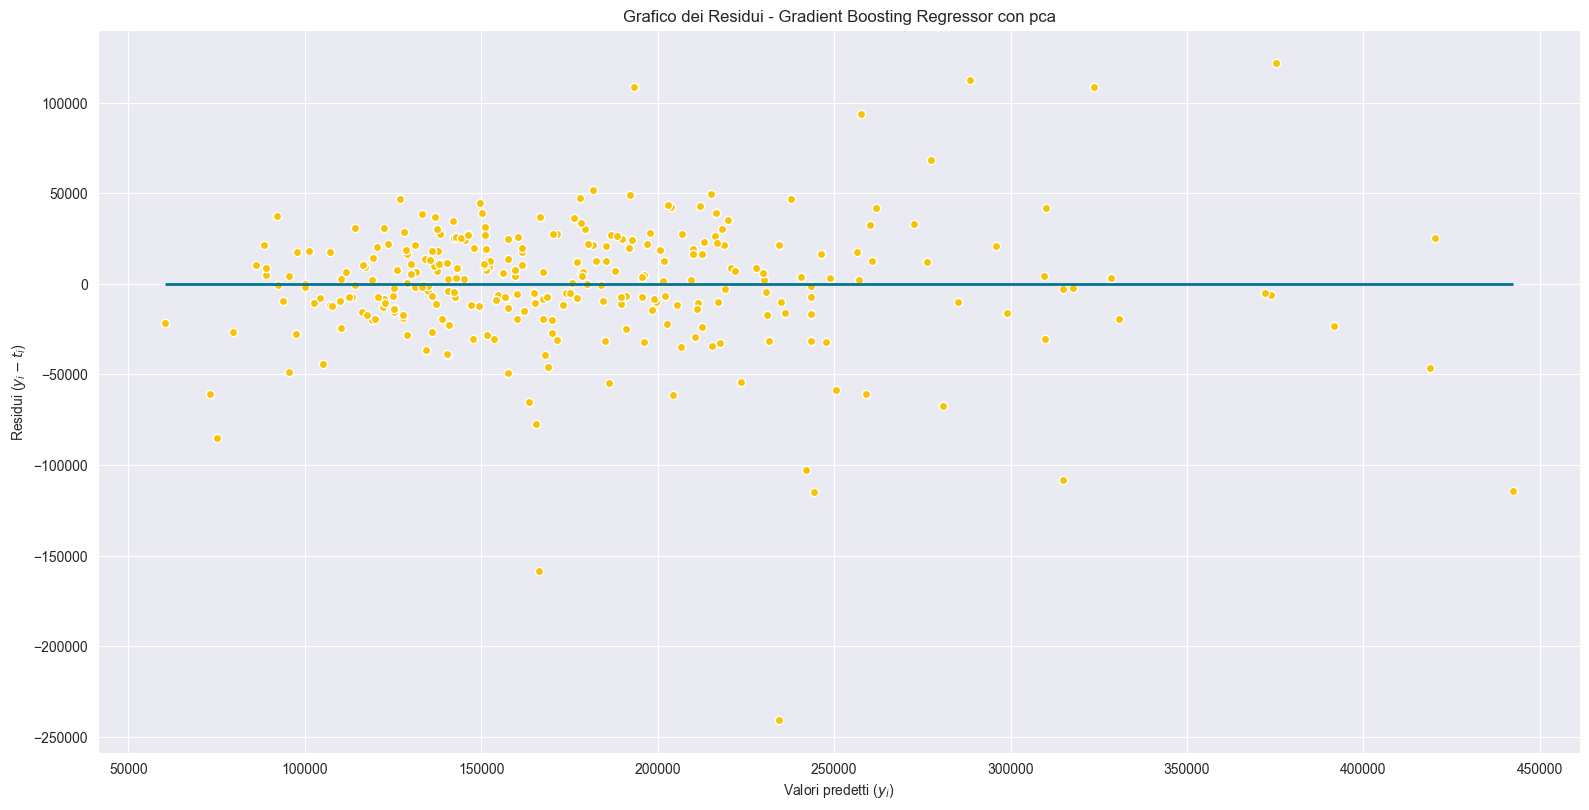

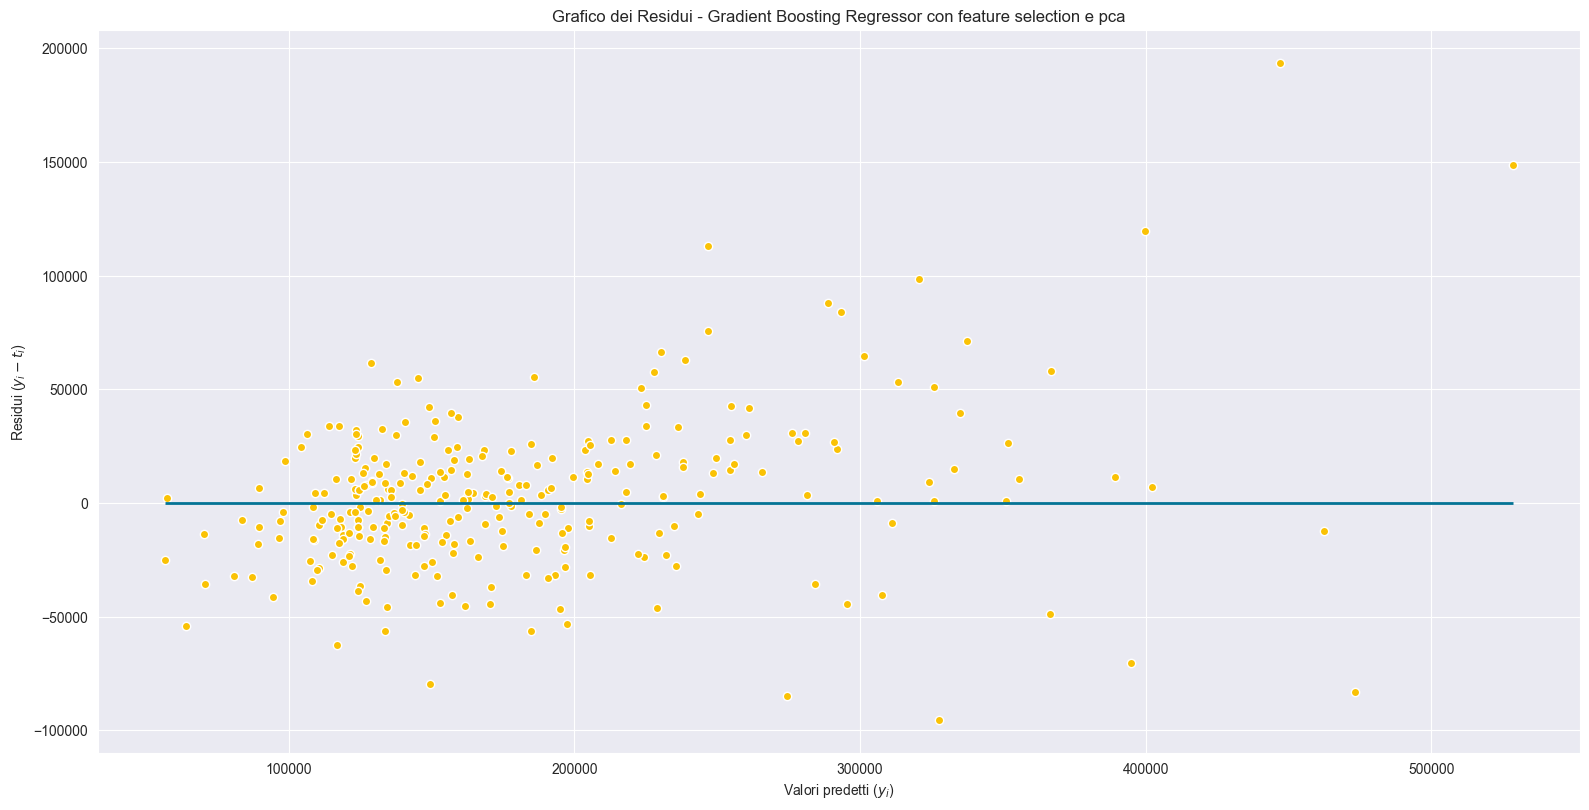

In [98]:
residual_plot(y_pred_gradient_boosting3, dataset.y_test, 'Gradient Boosting Regressor con pca')
residual_plot(y_pred_gradient_boosting4, dataset.y_test, 'Gradient Boosting Regressor con feature selection e pca')

### 7.2.2 AdaBoost

Parametri:
- **base_estimator**: specifica il tipo di modello debole da utilizzare. Di solito, viene utilizzato un albero decisionale di profondità limitata come modello debole, ma è possibile specificare anche altri modelli deboli. Il valore predefinito è DecisionTreeRegressor(max_depth=1);
- **n_estimators**: il numero di modelli deboli da addestrare;
- **learning_rate**: il tasso di apprendimento controlla la velocità con cui AdaBoostRegressor adatta i pesi degli stimatori deboli;
- **loss**: la funzione di perdita utilizzata per misurare l'errore durante l'addestramento del modello. Le opzioni comuni includono:
  - **linear**: la regressione lineare, in cui l'errore viene misurato come la differenza tra i valori predetti e quelli reali;
  - **square**: l'errore quadratico, in cui l'errore viene misurato come il quadrato della differenza tra i valori predetti e quelli reali;
  - **exponential**: l'errore esponenziale, che dà maggiore importanza agli errori più grandi.

#### 7.2.2.1 GridSearch

In [99]:
from sklearn.ensemble import AdaBoostRegressor

params_adaboost = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.05, 0.01],
    'loss': ['linear', 'square', 'exponential']
}

r2_gs_adaboost, best_param_adaboost = grid_search(AdaBoostRegressor(), dataset, params_adaboost,
                                                  scaled=False)
print(
    f"AdaBoost regression without normalization -> r2: {r2_gs_adaboost} - best parameters: {best_param_adaboost}")

r2_gs_adaboost_norm, best_param_adaboost_norm = grid_search(AdaBoostRegressor(), dataset,
                                                            params_adaboost, scaled=True)
print(
    f"AdaBoost regression with normalization -> r2: {r2_gs_adaboost_norm} - best parameters: {best_param_adaboost_norm}")

AdaBoost regression without normalization -> r2: 0.7711932854150583 - best parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
AdaBoost regression with normalization -> r2: 0.7678514955282209 - best parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}


#### 7.2.2.2 Performance test
Valutiamo il modello:

In [100]:
adaboost = AdaBoostRegressor(
    random_state=42,
    n_estimators=best_param_adaboost['n_estimators'],
    learning_rate=best_param_adaboost['learning_rate'],
    loss=best_param_adaboost['loss'])

r2_adaboost, rms_adaboost, r2_test_adaboost, rms_test_adaboost, y_pred_adaboost = performance_test(adaboost, dataset, scaled=False)
print(f"AdaBoost Regressor -> r2 mean: {r2_adaboost} - rms mean: {rms_adaboost} - r2 test {r2_test_adaboost} - rms test: {rms_test_adaboost}")

res_adaboost = BestParameters(f"AdaBoost Regressor no normalization", 220, best_param_adaboost, r2_test_adaboost, rms_test_adaboost, None)
parameters.append(res_adaboost)

AdaBoost Regressor -> r2 mean: 0.856299155713218 - rms mean: 30676.047943722402 - r2 test 0.8068550376806268 - rms test: 32099.616998164565


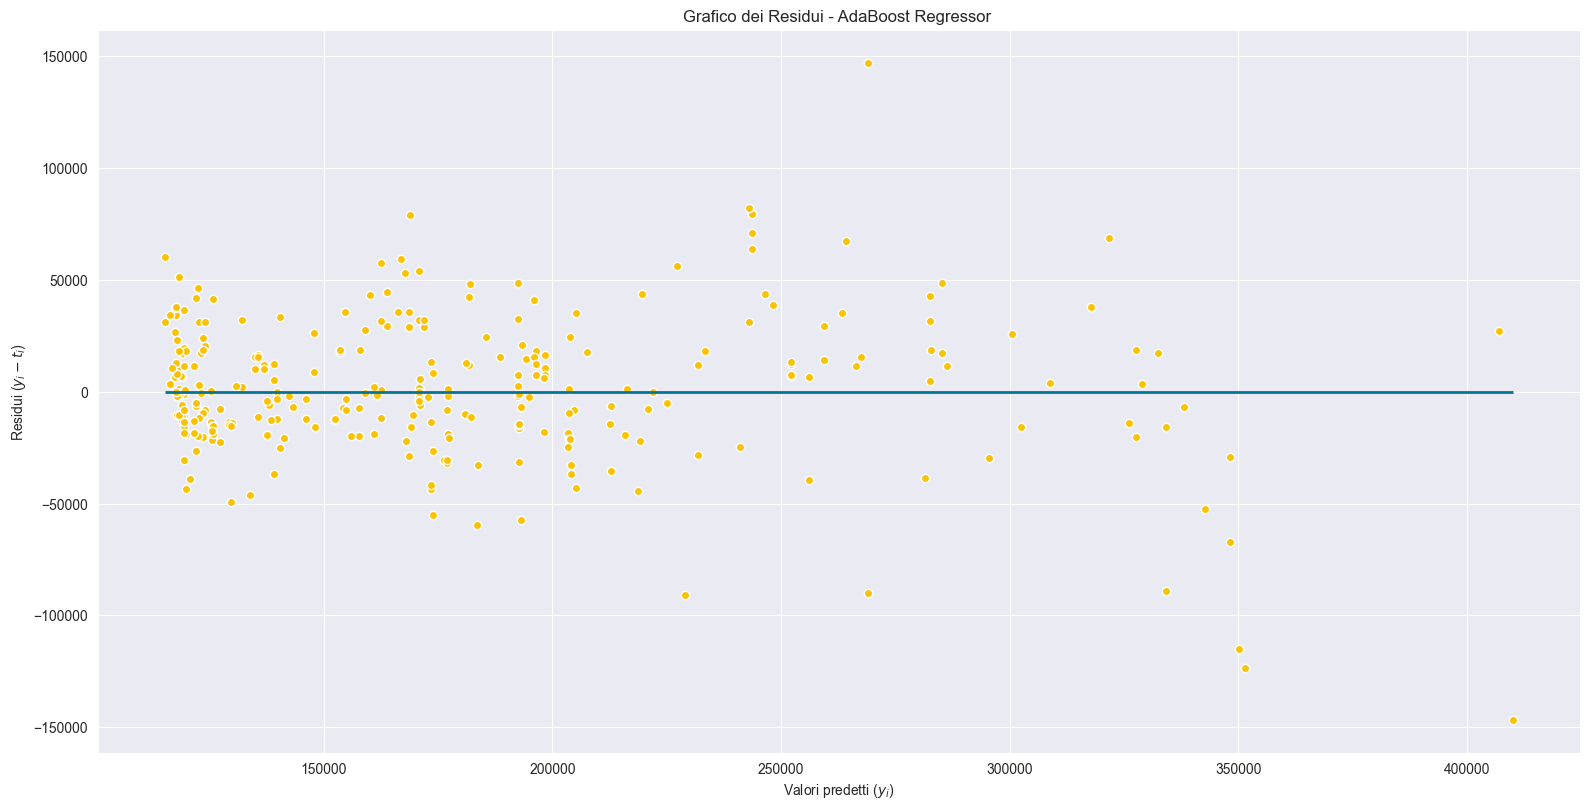

In [101]:
residual_plot(y_pred_adaboost, dataset.y_test, 'AdaBoost Regressor ')

Valutiamo il modello con un dataset normalizzato:

In [102]:
adaboost = AdaBoostRegressor(
    random_state=42,
    n_estimators=best_param_adaboost_norm['n_estimators'],
    learning_rate=best_param_adaboost_norm['learning_rate'],
    loss=best_param_adaboost_norm['loss'])

r2_adaboost, rms_adaboost, r2_test_adaboost, rms_test_adaboost, y_pred_adaboost1 = performance_test(adaboost, dataset, scaled=True)
print(f"AdaBoost Regressor -> r2 mean: {r2_adaboost} - rms mean: {rms_adaboost} - r2 test {r2_test_adaboost} - rms test: {rms_test_adaboost}")

res_adaboost = BestParameters(f"AdaBoost Regressor with normalization", 220, best_param_adaboost_norm, r2_test_adaboost, rms_test_adaboost, None)
parameters.append(res_adaboost)

AdaBoost Regressor -> r2 mean: 0.856299155713218 - rms mean: 30676.047943722402 - r2 test 0.804587944763306 - rms test: 32287.456509578085


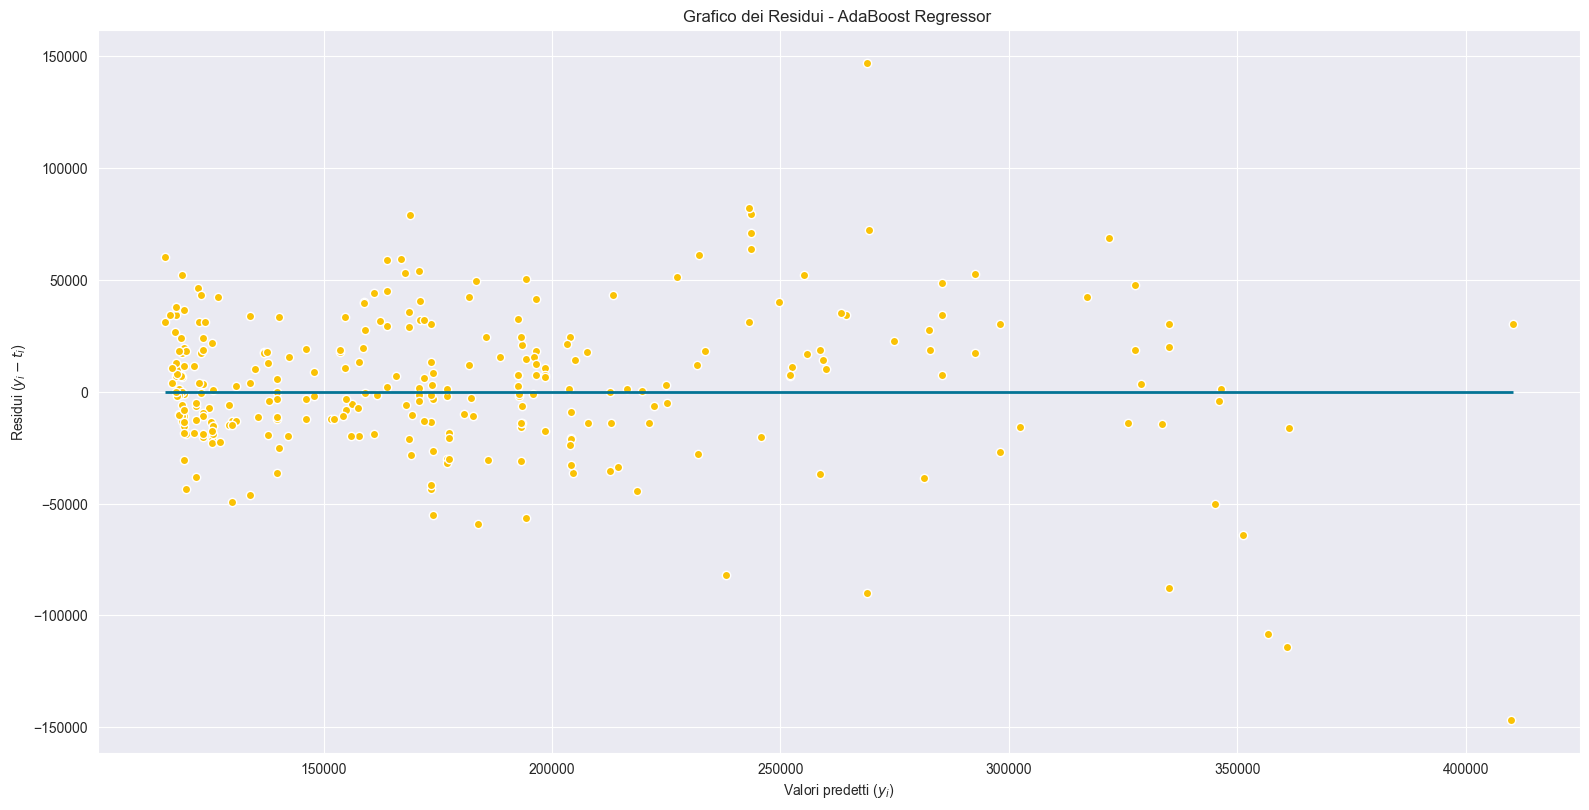

In [103]:
residual_plot(y_pred_adaboost1, dataset.y_test, 'AdaBoost Regressor ')

#### 7.2.2.3 Performance test con pca, con/senza feature selection
Valutiamo il modello:

In [104]:
X_train_pca, X_test_pca, X_train_fs_pca, X_test_fs_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)

adaboost = AdaBoostRegressor(
    random_state=42,
    n_estimators=best_param_adaboost['n_estimators'],
    learning_rate=best_param_adaboost['learning_rate'],
    loss=best_param_adaboost['loss'])
score1_adaboost, rms1_adaboost, y_pred_adaboost1 = run_regression_train_test(
    "AdaBoost Regressor with PCA", adaboost,
    dataset, X_train_pca,
    X_test_pca, scaled=False)

adaboost = AdaBoostRegressor(
    random_state=42,
    n_estimators=best_param_adaboost['n_estimators'],
    learning_rate=best_param_adaboost['learning_rate'],
    loss=best_param_adaboost['loss'])
score2_adaboost, rms2_adaboost, y_pred_adaboost2 = run_regression_train_test(
    "AdaBoost Regressor with FS and PCA",
    adaboost, dataset,
    X_train_fs_pca, X_test_fs_pca, scaled=False)

res_adaboost = BestParameters(f"AdaBoost no normalization con pca", 220, best_param_adaboost, score1_adaboost, rms1_adaboost, None)
parameters.append(res_adaboost)
res_adaboost = BestParameters(f"AdaBoost no normalization con pca e fs", 220, best_param_adaboost, score2_adaboost, rms2_adaboost, None)
parameters.append(res_adaboost)

Feature ridotte da (1168, 240) con PCA: (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
AdaBoost Regressor with PCA - r2: 0.7356105001176485 - rms: 41609.437965101795 - r2 test: 0.6758695620402431 - rms test: 41583.21521938691
AdaBoost Regressor with FS and PCA - r2: 0.8519239603420712 - rms: 31139.536448578507 - r2 test: 0.8272461725183867 - rms test: 30357.918947252292


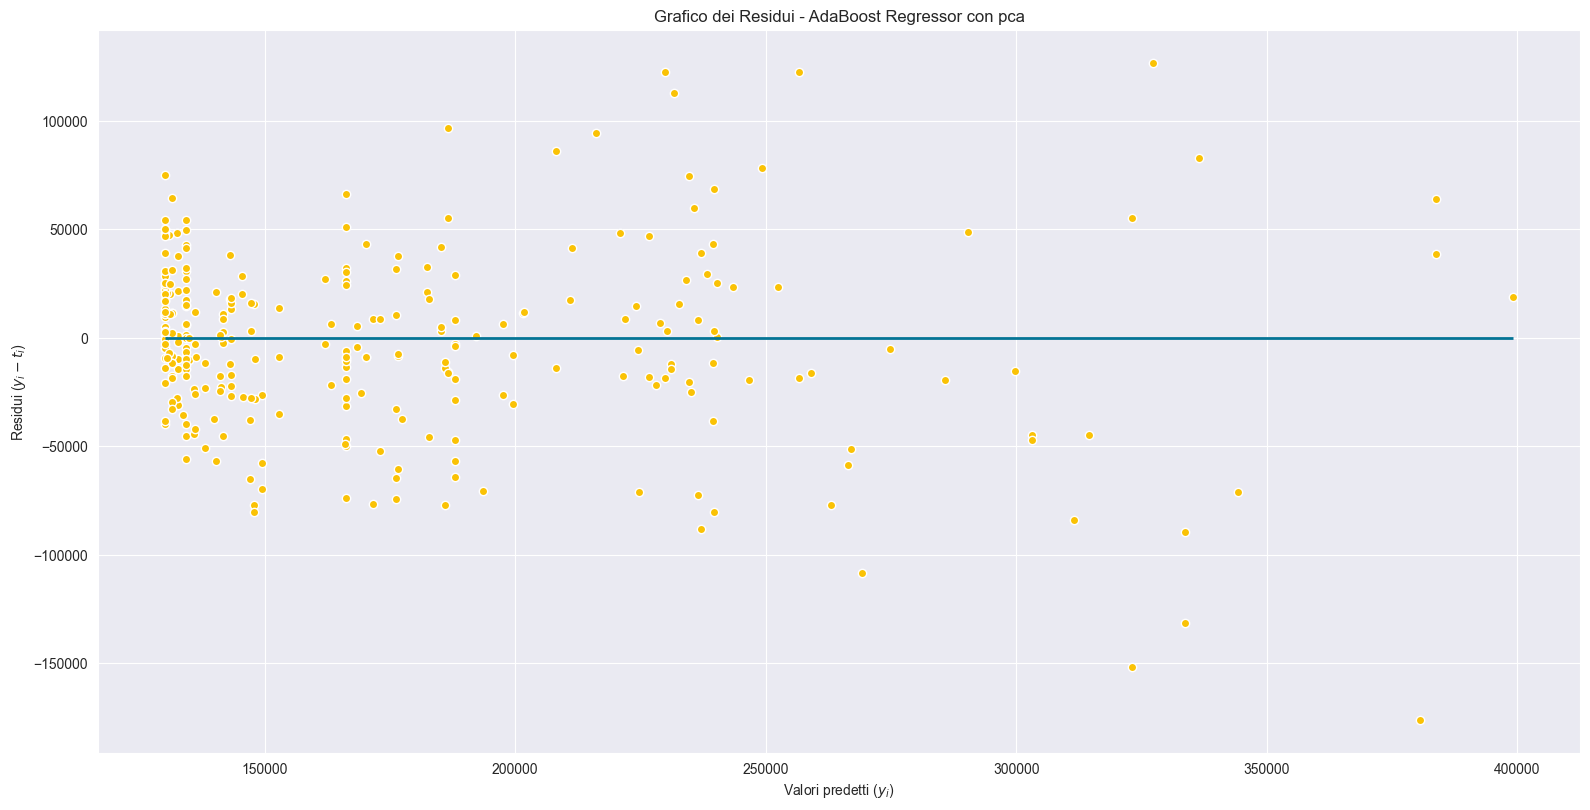

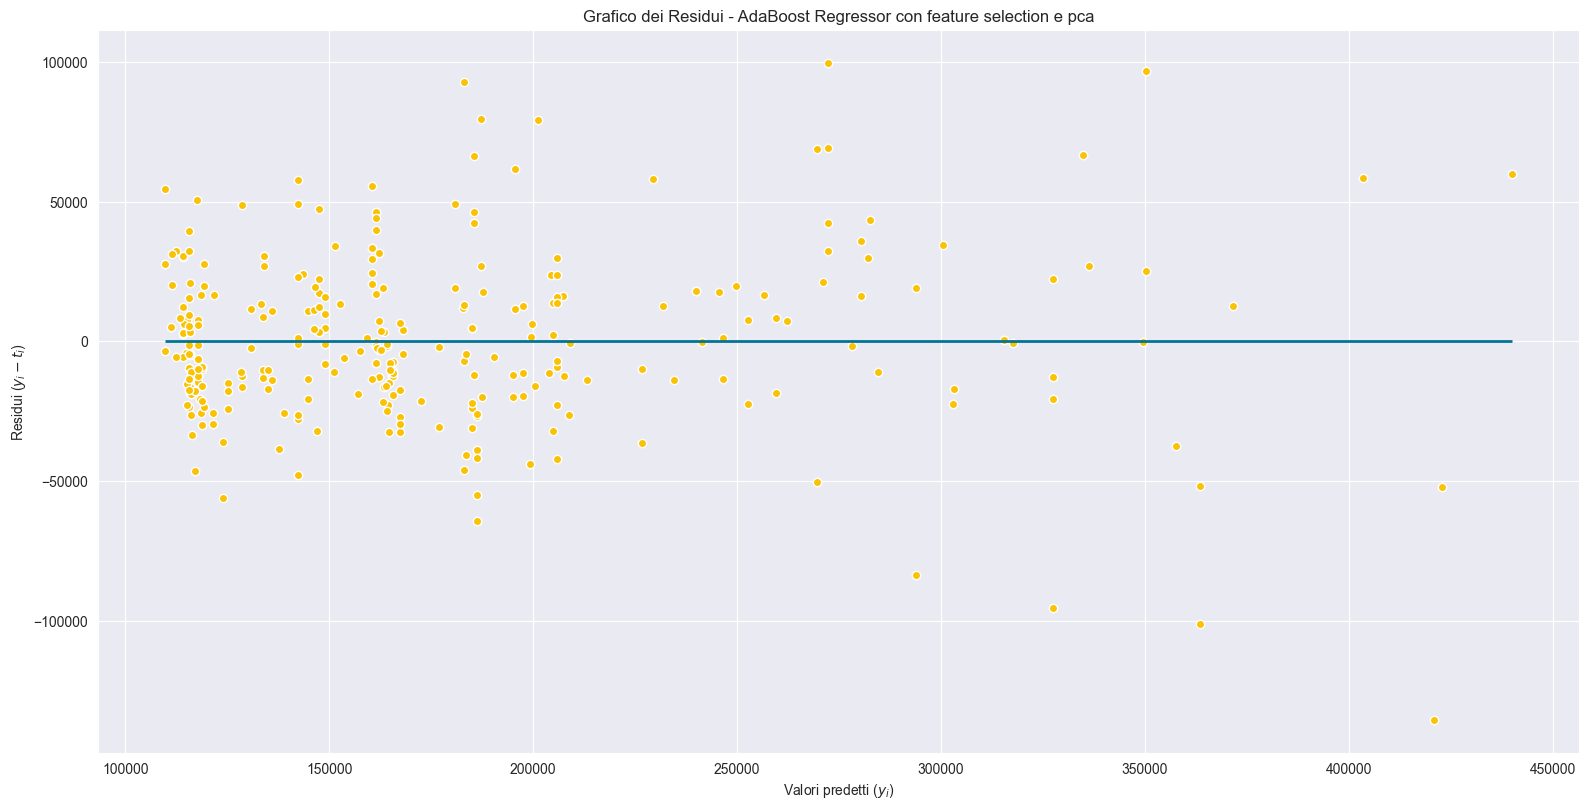

In [105]:
residual_plot(y_pred_adaboost1, dataset.y_test, 'AdaBoost Regressor con pca')
residual_plot(y_pred_adaboost2, dataset.y_test, 'AdaBoost Regressor con feature selection e pca')

In [106]:
X_train_pca, X_test_pca, X_train_fs_pca, X_test_fs_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=True)

adaboost = AdaBoostRegressor(
    random_state=42,
    n_estimators=best_param_adaboost_norm['n_estimators'],
    learning_rate=best_param_adaboost_norm['learning_rate'],
    loss=best_param_adaboost_norm['loss'])
score3_adaboost, rms3_adaboost, y_pred_adaboost3 = run_regression_train_test(
    "AdaBoost Regressor with PCA", adaboost,
    dataset, X_train_pca,
    X_test_pca, scaled=True)

adaboost = AdaBoostRegressor(
    random_state=42,
    n_estimators=best_param_adaboost_norm['n_estimators'],
    learning_rate=best_param_adaboost_norm['learning_rate'],
    loss=best_param_adaboost_norm['loss'])
score4_adaboost, rms4_adaboost, y_pred_adaboost4= run_regression_train_test(
    "AdaBoost Regressor with FS and PCA",
    adaboost, dataset,
    X_train_fs_pca, X_test_fs_pca, scaled=False)

res_adaboost = BestParameters(f"AdaBoost with normalization con pca", 220, best_param_adaboost_norm, score3_adaboost, rms3_adaboost, None)
parameters.append(res_adaboost)
res_adaboost = BestParameters(f"AdaBoost with normalization con pca e fs", 220, best_param_adaboost_norm, score4_adaboost, rms4_adaboost, None)
parameters.append(res_adaboost)

Feature ridotte da (1168, 240) con PCA: (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
AdaBoost Regressor with PCA - r2: 0.7789741963918747 - rms: 38044.44361607185 - r2 test: 0.6979084897989543 - rms test: 40144.62617408991
AdaBoost Regressor with FS and PCA - r2: 0.8623456372492969 - rms: 30023.736377622838 - r2 test: 0.8064647703708817 - rms test: 32132.03075929903


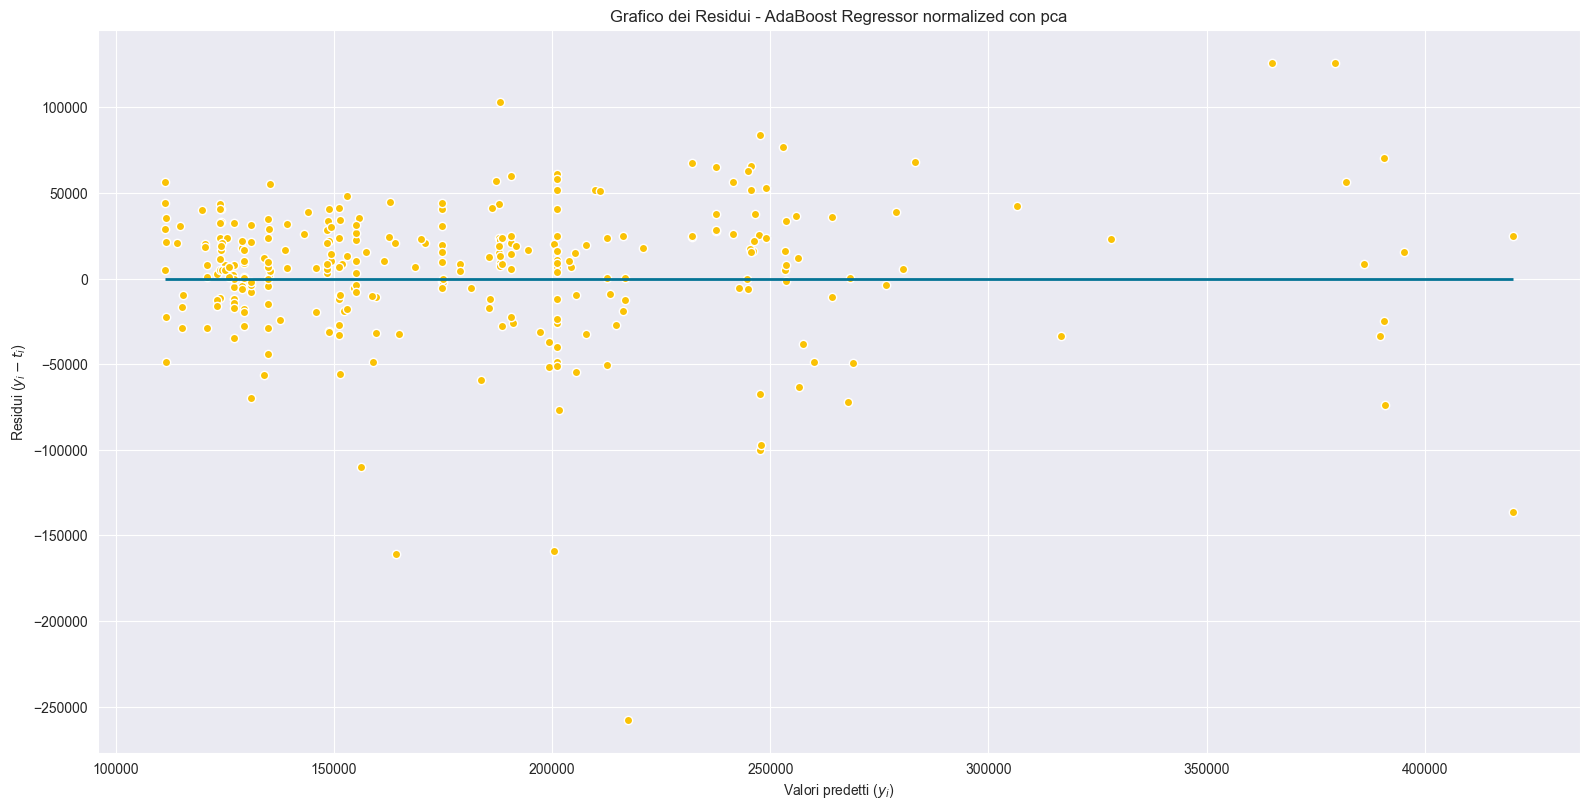

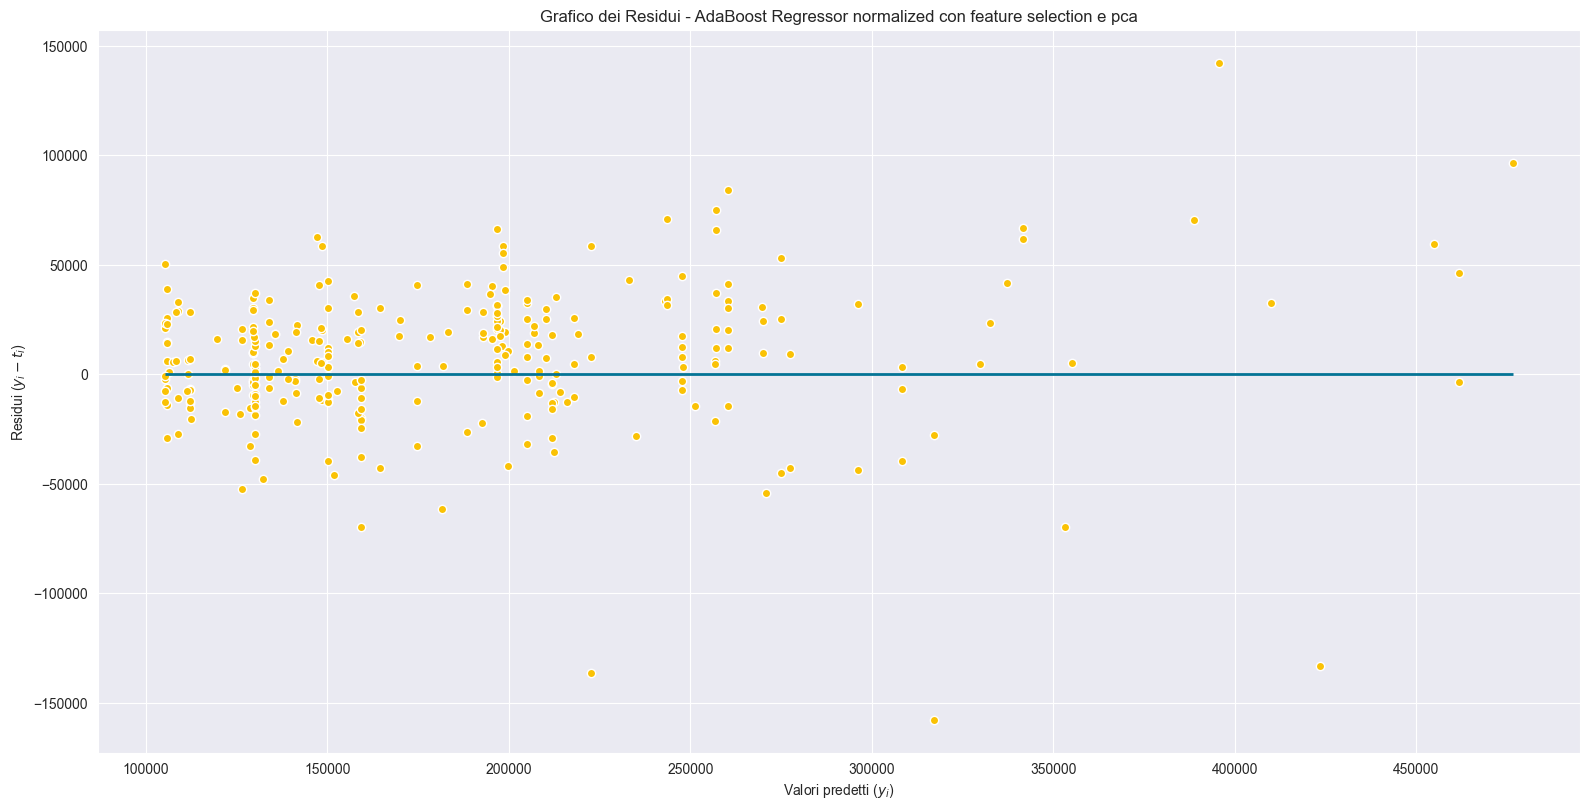

In [107]:
residual_plot(y_pred_adaboost3, dataset.y_test, 'AdaBoost Regressor normalized con pca')
residual_plot(y_pred_adaboost4, dataset.y_test, 'AdaBoost Regressor normalized con feature selection e pca')

# 8 Conclusione

In [ ]:
for param in parameters:
    if param.print_parameters() is not None:
        print(param.print_parameters())